In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
folder = "./LabelMe/"

### Load Data and preprocess

In [4]:
#which X?? max could do overfitting


In [5]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [6]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [40]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

### Load annotations / Generate

In [7]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [8]:
#generate conf matrix...
confe_matrix = np.zeros((T,K,K),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix[t,:,:][~mask_nan],axis=0)
    for value in np.arange(K)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix[t,:,:] = confe_matrix[t,:,:]/confe_matrix[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix

array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

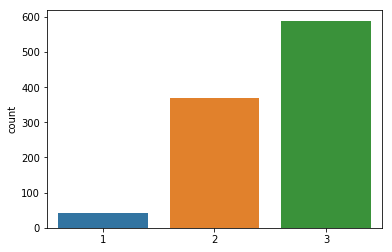

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


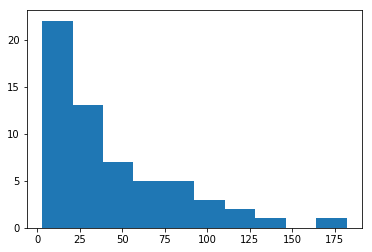

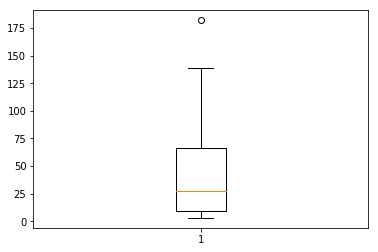

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182


In [7]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())

#### Delta Convergence criteria

In [9]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [9]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Trained IDeal Model, Epochs to converge = 8


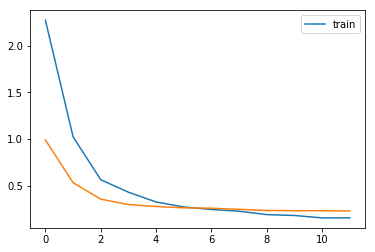

In [42]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [10]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

if y_obs.shape[1] <= 3000:
    ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.6143296389882
2 	 -2762.646210244835 	0.0214	0.065072	0.026419
3 	 -2736.633208243355 	0.0117	0.059334	0.009416
4 	 -2725.378111119757 	0.0071	0.058779	0.004113
5 	 -2719.6973578268603 	0.0041	0.051646	0.002084
6 	 -2716.566654228873 	0.0027	0.040519	0.001151
7 	 -2714.775977808997 	0.0021	0.031279	0.000659
8 	 -2713.6296368849667 	0.0017	0.024918	0.000422
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]


In [46]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [24]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [11]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

Trained model over soft-MV, Epochs to converge = 12


In [107]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

Trained model over hard-MV, Epochs to converge = 13


In [22]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

Trained model over D&S, Epochs to converge = 7


### Raykar Model (joint predict model)

In [12]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 59, 8)


In [13]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(30,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.81 sec)	logL: -3101.304	
Iter 2/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -2736.565	Tol1: 0.11761	Tol2: 0.11227	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2594.501	Tol1: 0.05191	Tol2: 0.04730	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2513.285	Tol1: 0.03130	Tol2: 0.03237	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2462.675	Tol1: 0.02014	Tol2: 0.02595	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.65 sec)	logL: -3091.133	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2609.977	Tol1: 0.15566	Tol2: 0.08711	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2457.280	Tol1: 0.05851	Tol2: 0.04105	
Iter 4/50 
M step: done,  E 

M step: done,  E step: done //  (in 0.74 sec)	logL: -3009.448	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -2607.771	Tol1: 0.13347	Tol2: 0.08820	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2466.756	Tol1: 0.05407	Tol2: 0.04399	
Iter 4/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2402.907	Tol1: 0.02588	Tol2: 0.01918	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.55 sec)	logL: -3163.654	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2678.429	Tol1: 0.15337	Tol2: 0.10301	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2515.901	Tol1: 0.06068	Tol2: 0.04367	
Iter 4/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2439.133	Tol1: 0.03051	Tol2: 0.02476	
Iter 5/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -2388.344	Tol1: 0.02082	Tol2: 0.01330	
Finished training
Initializing new EM...
Betas shape: 

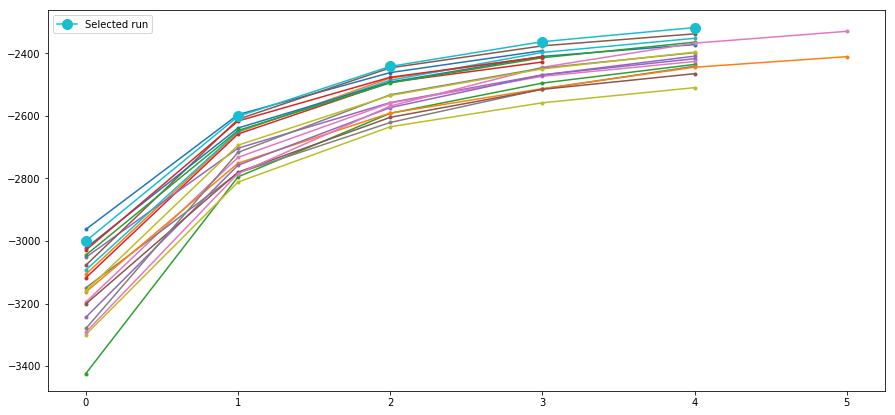

In [67]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [10]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


In [35]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [15]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(2,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Wmean JS"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.003553 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6055228 0.7347975]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -3247.583	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2220.573	Tol1: 0.31624	Tol2: 0.54083	Tol3: 0.17292	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1964.484	Tol1: 0.11533	Tol2: 0.20707	Tol3: 0.10912	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1858.708	Tol1: 0.05384	Tol2: 0.14879	Tol3: 0.10810	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1812.463	Tol1: 0.02488	Tol2: 0.08047	Tol3: 0.08562	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1763.917	Tol1: 0.02678	Tol2: 0.04192	Tol3: 0.07022	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.577

M step: done,  E step: done //  (in 0.06 sec)	logL: -1698.623	Tol1: 0.02765	Tol2: 0.05488	Tol3: 0.08547	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.571	Tol1: 0.02240	Tol2: 0.03883	Tol3: 0.07729	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1626.153	Tol1: 0.02073	Tol2: 0.03182	Tol3: 0.06574	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.139	Tol1: 0.01907	Tol2: 0.02264	Tol3: 0.05037	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.24493426 0.64877623]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3297.749	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2197.451	Tol1: 0.33365	Tol2: 0.54970	Tol3: 0.28633	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1916.137	Tol1: 0.12802	Tol2: 0.23322	Tol3: 0.10268	
Iter 4/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.07 sec)	logL: -1856.590	Tol1: 0.07208	Tol2: 0.14933	Tol3: 0.09261	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.962	Tol1: 0.04127	Tol2: 0.10933	Tol3: 0.07999	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1737.100	Tol1: 0.02408	Tol2: 0.06132	Tol3: 0.08461	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.959	Tol1: 0.02023	Tol2: 0.04445	Tol3: 0.07596	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -1673.917	Tol1: 0.01648	Tol2: 0.03748	Tol3: 0.06751	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1642.808	Tol1: 0.01858	Tol2: 0.02972	Tol3: 0.05548	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15578891 0.24112423]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2863.935	
Iter 2/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.709	Tol1: 0.02068	Tol2: 0.03999	Tol3: 0.07145	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1628.130	Tol1: 0.01784	Tol2: 0.02747	Tol3: 0.06055	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  9.25
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002594 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5794569  0.29936457]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3460.580	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2434.887	Tol1: 0.29639	Tol2: 0.63665	Tol3: 0.23338	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2092.336	Tol1: 0.14068	Tol2: 0.16225	Tol3: 0.09271	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1913.084	Tol1: 0.08567	Tol2: 0.1

M step: done,  E step: done //  (in 0.06 sec)	logL: -2081.110	Tol1: 0.26982	Tol2: 0.52261	Tol3: 0.08141	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1824.706	Tol1: 0.12321	Tol2: 0.15510	Tol3: 0.04696	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.106	Tol1: 0.04527	Tol2: 0.09815	Tol3: 0.10179	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.526	Tol1: 0.03535	Tol2: 0.06751	Tol3: 0.10245	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.501	Tol1: 0.02322	Tol2: 0.05348	Tol3: 0.09644	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1602.209	Tol1: 0.02394	Tol2: 0.04351	Tol3: 0.08527	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1569.531	Tol1: 0.02040	Tol2: 0.03175	Tol3: 0.06726	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1541.513	Tol1: 0.01785	Tol2: 0.02355	Tol3: 0.04700	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.55 sec)	logL: -2722.293	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2087.554	Tol1: 0.23316	Tol2: 0.40709	Tol3: 0.01925	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1892.316	Tol1: 0.09352	Tol2: 0.15893	Tol3: 0.09917	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1798.027	Tol1: 0.04983	Tol2: 0.10432	Tol3: 0.08292	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1741.432	Tol1: 0.03148	Tol2: 0.07116	Tol3: 0.07334	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1704.362	Tol1: 0.02129	Tol2: 0.04719	Tol3: 0.06154	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.600	Tol1: 0.02040	Tol2: 0.03032	Tol3: 0.04924	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.754	Tol1: 0.01428	Tol2: 0.02358	Tol3: 0.03886	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.61502343 0.20315999]
Alphas:  

M step: done,  E step: done //  (in 0.07 sec)	logL: -1872.983	Tol1: 0.12025	Tol2: 0.17770	Tol3: 0.10762	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.211	Tol1: 0.05807	Tol2: 0.12386	Tol3: 0.11517	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1708.473	Tol1: 0.03159	Tol2: 0.08118	Tol3: 0.10445	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1669.413	Tol1: 0.02286	Tol2: 0.05272	Tol3: 0.09602	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1629.295	Tol1: 0.02403	Tol2: 0.04086	Tol3: 0.08215	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.964	Tol1: 0.02046	Tol2: 0.03283	Tol3: 0.06667	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1569.822	Tol1: 0.01638	Tol2: 0.02591	Tol3: 0.04987	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.91322815 0.8829713 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
I

M step: done,  E step: done //  (in 0.05 sec)	logL: -1923.871	Tol1: 0.10441	Tol2: 0.18413	Tol3: 0.10964	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1801.215	Tol1: 0.06375	Tol2: 0.13828	Tol3: 0.09962	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1732.451	Tol1: 0.03818	Tol2: 0.07105	Tol3: 0.09599	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1674.474	Tol1: 0.03347	Tol2: 0.05724	Tol3: 0.08646	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1631.458	Tol1: 0.02569	Tol2: 0.03928	Tol3: 0.07203	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1594.959	Tol1: 0.02237	Tol2: 0.02974	Tol3: 0.05639	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8975459  0.77006614]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2665.973	
Iter 2/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1529.450	Tol1: 0.01213	Tol2: 0.02553	Tol3: 0.05595	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.90457225 0.33665785]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -2709.530	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2039.457	Tol1: 0.24730	Tol2: 0.33975	Tol3: 0.02355	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1849.227	Tol1: 0.09328	Tol2: 0.14867	Tol3: 0.09719	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1769.078	Tol1: 0.04334	Tol2: 0.10469	Tol3: 0.09889	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1714.095	Tol1: 0.03108	Tol2: 0.06213	Tol3: 0.08605	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.897	Tol1: 0.02695	Tol2: 0.04660	Tol3: 0.07793	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.07 sec)	logL: -1958.072	Tol1: 0.08013	Tol2: 0.17354	Tol3: 0.10460	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1851.170	Tol1: 0.05460	Tol2: 0.09751	Tol3: 0.09095	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1770.179	Tol1: 0.04375	Tol2: 0.05753	Tol3: 0.09210	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.636	Tol1: 0.03420	Tol2: 0.05050	Tol3: 0.08558	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.000	Tol1: 0.02962	Tol2: 0.04398	Tol3: 0.07019	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1620.982	Tol1: 0.02292	Tol2: 0.03818	Tol3: 0.05867	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1587.221	Tol1: 0.02083	Tol2: 0.02459	Tol3: 0.04160	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.86474806 0.00415892]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
I

M step: done,  E step: done //  (in 0.05 sec)	logL: -2058.496	Tol1: 0.30238	Tol2: 0.49042	Tol3: 0.16339	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1839.479	Tol1: 0.10640	Tol2: 0.15170	Tol3: 0.09701	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1748.348	Tol1: 0.04954	Tol2: 0.12081	Tol3: 0.10358	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1713.015	Tol1: 0.02021	Tol2: 0.07059	Tol3: 0.09241	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1665.028	Tol1: 0.02801	Tol2: 0.06313	Tol3: 0.08533	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1629.452	Tol1: 0.02137	Tol2: 0.04860	Tol3: 0.07979	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1593.459	Tol1: 0.02209	Tol2: 0.03659	Tol3: 0.06447	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1567.753	Tol1: 0.01613	Tol2: 0.03275	Tol3: 0.05152	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1539.218	Tol1: 0.01820	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1645.200	Tol1: 0.03464	Tol2: 0.02712	Tol3: 0.04157	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1601.592	Tol1: 0.02651	Tol2: 0.02597	Tol3: 0.02918	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97706467 0.28048307]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2763.364	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2106.341	Tol1: 0.23776	Tol2: 0.40755	Tol3: 0.02726	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1917.792	Tol1: 0.08952	Tol2: 0.16052	Tol3: 0.11298	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1810.031	Tol1: 0.05619	Tol2: 0.10878	Tol3: 0.09713	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1729.633	Tol1: 0.04442	Tol2: 0.06318	Tol3: 0.08504	
Iter 6/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.06 sec)	logL: -1817.516	Tol1: 0.05510	Tol2: 0.10613	Tol3: 0.09475	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1761.713	Tol1: 0.03070	Tol2: 0.07216	Tol3: 0.08439	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.162	Tol1: 0.02529	Tol2: 0.05035	Tol3: 0.07397	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.096	Tol1: 0.03032	Tol2: 0.03585	Tol3: 0.05708	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.607	Tol1: 0.01951	Tol2: 0.03526	Tol3: 0.04648	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1601.672	Tol1: 0.01895	Tol2: 0.02273	Tol3: 0.03333	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14604698 0.85177714]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3115.882	
Iter 2/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.05 sec)	logL: -1629.742	Tol1: 0.02358	Tol2: 0.02542	Tol3: 0.04944	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31237283 0.5702741 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3405.575	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2277.280	Tol1: 0.33131	Tol2: 0.62150	Tol3: 0.35976	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1959.345	Tol1: 0.13961	Tol2: 0.20022	Tol3: 0.09377	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1847.849	Tol1: 0.05690	Tol2: 0.15717	Tol3: 0.12336	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1776.128	Tol1: 0.03881	Tol2: 0.08768	Tol3: 0.10684	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1714.060	Tol1: 0.03495	Tol2: 0.06973	Tol3: 0.09937	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.06 sec)	logL: -1754.645	Tol1: 0.02516	Tol2: 0.05981	Tol3: 0.09255	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.380	Tol1: 0.02523	Tol2: 0.04219	Tol3: 0.08279	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1670.999	Tol1: 0.02302	Tol2: 0.04064	Tol3: 0.06992	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1636.154	Tol1: 0.02085	Tol2: 0.03371	Tol3: 0.05821	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1602.668	Tol1: 0.02047	Tol2: 0.02884	Tol3: 0.04205	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04088633 0.5724993 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3616.044	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2433.653	Tol1: 0.32698	Tol2: 1.36751	Tol3: 0.66897	
Iter 3/50
M step: done,  E step: done //  

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.003076 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.41731897 0.14129446]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -3069.334	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2080.401	Tol1: 0.32220	Tol2: 0.57694	Tol3: 0.14619	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1885.379	Tol1: 0.09374	Tol2: 0.14316	Tol3: 0.09407	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1785.547	Tol1: 0.05295	Tol2: 0.10785	Tol3: 0.09561	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1726.154	Tol1: 0.03326	Tol2: 0.08059	Tol3: 0.09777	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1683.545	Tol1: 0.02468	Tol2: 0.06780	Tol3: 0.09348	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1645.8

M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.913	Tol1: 0.02824	Tol2: 0.03755	Tol3: 0.07246	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1619.286	Tol1: 0.02447	Tol2: 0.02808	Tol3: 0.05597	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13054268 0.24155545]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3512.146	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2285.106	Tol1: 0.34937	Tol2: 0.81871	Tol3: 0.42452	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2035.268	Tol1: 0.10933	Tol2: 0.20878	Tol3: 0.07733	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1908.573	Tol1: 0.06225	Tol2: 0.12649	Tol3: 0.10305	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1832.835	Tol1: 0.03968	Tol2: 0.09197	Tol3: 0.10243	
Iter 6/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.61 sec)	logL: -3043.548	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2276.755	Tol1: 0.25194	Tol2: 0.52937	Tol3: 0.17550	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2094.185	Tol1: 0.08019	Tol2: 0.14107	Tol3: 0.09174	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1981.985	Tol1: 0.05358	Tol2: 0.11531	Tol3: 0.10915	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1897.446	Tol1: 0.04265	Tol2: 0.08377	Tol3: 0.10630	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1813.084	Tol1: 0.04446	Tol2: 0.05877	Tol3: 0.09449	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.491	Tol1: 0.04500	Tol2: 0.04733	Tol3: 0.08220	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1672.941	Tol1: 0.03381	Tol2: 0.03662	Tol3: 0.06419	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.664	Tol1: 0.02706	Tol2: 0.02918	Tol3: 0.04756	
Finished training

Doing clustering...Done!
Get init alphas in 0.002688 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5310172 0.5869102]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2718.721	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2039.407	Tol1: 0.24987	Tol2: 0.40608	Tol3: 0.08527	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1884.726	Tol1: 0.07585	Tol2: 0.17816	Tol3: 0.09743	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1806.361	Tol1: 0.04158	Tol2: 0.08634	Tol3: 0.07826	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1743.024	Tol1: 0.03506	Tol2: 0.05387	Tol3: 0.08221	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.268	Tol1: 0.02568	Tol2: 0.04584	Tol3: 0.08016	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.396	Tol1: 0.02524	Tol2: 0.03317	Tol3: 0.065

M step: done,  E step: done //  (in 0.05 sec)	logL: -1675.583	Tol1: 0.03264	Tol2: 0.03039	Tol3: 0.04888	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1626.978	Tol1: 0.02901	Tol2: 0.02158	Tol3: 0.03499	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9766194 0.9111077]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2918.726	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2168.228	Tol1: 0.25713	Tol2: 0.36813	Tol3: 0.01975	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2000.508	Tol1: 0.07735	Tol2: 0.14523	Tol3: 0.10547	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1876.405	Tol1: 0.06204	Tol2: 0.09146	Tol3: 0.09070	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1802.049	Tol1: 0.03963	Tol2: 0.07155	Tol3: 0.09332	
Iter 6/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.07 sec)	logL: -1621.077	Tol1: 0.02019	Tol2: 0.03618	Tol3: 0.05760	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1587.471	Tol1: 0.02073	Tol2: 0.02507	Tol3: 0.04832	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8930958 0.6739123]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3051.961	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2240.170	Tol1: 0.26599	Tol2: 0.43745	Tol3: 0.02162	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1925.578	Tol1: 0.14043	Tol2: 0.17154	Tol3: 0.09663	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -1801.532	Tol1: 0.06442	Tol2: 0.12755	Tol3: 0.11251	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1749.588	Tol1: 0.02883	Tol2: 0.07819	Tol3: 0.08361	
Iter 6/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.120	Tol1: 0.02416	Tol2: 0.05998	Tol3: 0.10217	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1583.866	Tol1: 0.02298	Tol2: 0.04508	Tol3: 0.09410	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1552.548	Tol1: 0.01977	Tol2: 0.04186	Tol3: 0.08215	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1529.177	Tol1: 0.01505	Tol2: 0.03320	Tol3: 0.06863	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1505.448	Tol1: 0.01552	Tol2: 0.02948	Tol3: 0.05719	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  9.45
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002673 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8904297 0.3147126]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 s

M step: done,  E step: done //  (in 0.05 sec)	logL: -2064.113	Tol1: 0.23969	Tol2: 0.43868	Tol3: 0.01774	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1927.166	Tol1: 0.06635	Tol2: 0.15529	Tol3: 0.10077	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1851.384	Tol1: 0.03932	Tol2: 0.08601	Tol3: 0.08632	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1793.844	Tol1: 0.03108	Tol2: 0.06445	Tol3: 0.08192	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1744.709	Tol1: 0.02739	Tol2: 0.04501	Tol3: 0.07311	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1696.820	Tol1: 0.02745	Tol2: 0.03773	Tol3: 0.05946	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.770	Tol1: 0.02184	Tol2: 0.02634	Tol3: 0.04541	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.20476708 0.5992645 ]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
I

M step: done,  E step: done //  (in 0.54 sec)	logL: -2841.413	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2051.283	Tol1: 0.27808	Tol2: 0.39568	Tol3: 0.06821	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1871.544	Tol1: 0.08762	Tol2: 0.13458	Tol3: 0.09459	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.245	Tol1: 0.05145	Tol2: 0.09891	Tol3: 0.10136	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.612	Tol1: 0.03810	Tol2: 0.06026	Tol3: 0.08737	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.277	Tol1: 0.03123	Tol2: 0.04631	Tol3: 0.07871	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1613.952	Tol1: 0.02438	Tol2: 0.04286	Tol3: 0.06432	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1577.490	Tol1: 0.02259	Tol2: 0.03144	Tol3: 0.05282	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1540.583	Tol1: 0.02340	Tol2: 0.02227	Tol3: 0.03923	
Finished training

Doing clustering...Done!
Get init alphas in 0.002725 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73413384 0.94748086]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2863.134	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2091.553	Tol1: 0.26949	Tol2: 0.40452	Tol3: 0.11604	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1919.985	Tol1: 0.08203	Tol2: 0.17782	Tol3: 0.11987	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1836.000	Tol1: 0.04374	Tol2: 0.08806	Tol3: 0.09600	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1778.659	Tol1: 0.03123	Tol2: 0.05506	Tol3: 0.08687	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1732.128	Tol1: 0.02616	Tol2: 0.03894	Tol3: 0.07943	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1699.662	Tol1: 0.01874	Tol2: 0.02915	Tol3: 0.0

Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3005.336	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2127.872	Tol1: 0.29197	Tol2: 0.38962	Tol3: 0.06294	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1903.734	Tol1: 0.10533	Tol2: 0.20840	Tol3: 0.10316	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1827.174	Tol1: 0.04022	Tol2: 0.12453	Tol3: 0.08339	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1751.537	Tol1: 0.04140	Tol2: 0.06910	Tol3: 0.08109	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1709.136	Tol1: 0.02421	Tol2: 0.05034	Tol3: 0.08286	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1682.655	Tol1: 0.01549	Tol2: 0.03447	Tol3: 0.06605	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1658.772	Tol1: 0.01419	Tol2: 0.02340	Tol3: 0.05183	
Finished training!
Initializing new EM...

M step: done,  E step: done //  (in 0.05 sec)	logL: -2052.365	Tol1: 0.25342	Tol2: 0.43085	Tol3: 0.00129	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1864.787	Tol1: 0.09140	Tol2: 0.15390	Tol3: 0.07020	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1780.428	Tol1: 0.04524	Tol2: 0.09383	Tol3: 0.09051	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1716.960	Tol1: 0.03565	Tol2: 0.06978	Tol3: 0.08493	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1674.578	Tol1: 0.02468	Tol2: 0.04520	Tol3: 0.07609	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1638.327	Tol1: 0.02165	Tol2: 0.03877	Tol3: 0.06377	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1608.386	Tol1: 0.01828	Tol2: 0.02403	Tol3: 0.05049	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9952274  0.88341755]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
I

M step: done,  E step: done //  (in 0.07 sec)	logL: -1600.727	Tol1: 0.00955	Tol2: 0.03036	Tol3: 0.02743	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1591.215	Tol1: 0.00594	Tol2: 0.02123	Tol3: 0.01989	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  9.3
Model with 2 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002705 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3647894  0.36283338]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3738.741	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2364.672	Tol1: 0.36752	Tol2: 0.57746	Tol3: 0.24873	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2023.927	Tol1: 0.14410	Tol2: 0.18253	Tol3: 0.07401	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1908.853	Tol1: 0.05686	Tol2: 0.1

M step: done,  E step: done //  (in 0.05 sec)	logL: -1741.838	Tol1: 0.01974	Tol2: 0.04480	Tol3: 0.06216	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1706.799	Tol1: 0.02012	Tol2: 0.02424	Tol3: 0.04594	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36653522 0.51365584]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -2919.865	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2080.458	Tol1: 0.28748	Tol2: 0.42119	Tol3: 0.12092	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1870.557	Tol1: 0.10089	Tol2: 0.23732	Tol3: 0.08857	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.067	Tol1: 0.04036	Tol2: 0.10399	Tol3: 0.07997	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1743.714	Tol1: 0.02861	Tol2: 0.06420	Tol3: 0.08436	
Iter 6/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -1748.510	Tol1: 0.03417	Tol2: 0.07642	Tol3: 0.08954	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1714.625	Tol1: 0.01938	Tol2: 0.04881	Tol3: 0.08444	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.910	Tol1: 0.01966	Tol2: 0.04473	Tol3: 0.07141	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1654.565	Tol1: 0.01567	Tol2: 0.02940	Tol3: 0.06234	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5784448  0.13357553]
Alphas:  (2,)
MV init:  (1000, 8)
Betas:  (2, 8, 8)
Q estimate:  (1000, 8, 2, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3225.952	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2236.278	Tol1: 0.30679	Tol2: 0.56473	Tol3: 0.10899	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2006.243	Tol1: 0.10287	Tol2: 0.14081	Tol3: 0.09936	
Iter 4/50
M step: done,  E step: done //  (

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8400132  0.85892963 0.4618176 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -2737.680	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2111.998	Tol1: 0.22854	Tol2: 0.30913	Tol3: 0.05724	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1904.685	Tol1: 0.09816	Tol2: 0.16634	Tol3: 0.09495	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.351	Tol1: 0.04533	Tol2: 0.08145	Tol3: 0.10400	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1761.259	Tol1: 0.03140	Tol2: 0.05474	Tol3: 0.09079	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1717.171	Tol1: 0.02503	Tol2: 0.03222	Tol3: 0.06887	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.456	Tol1: 0.02255	Tol2: 0.02407	Tol3: 0.05313	
Finished training!
Initializing new EM...
Pre-train network on 0

M step: done,  E step: done //  (in 0.06 sec)	logL: -1911.374	Tol1: 0.11017	Tol2: 0.16270	Tol3: 0.10677	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1793.470	Tol1: 0.06169	Tol2: 0.10362	Tol3: 0.12740	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.887	Tol1: 0.03880	Tol2: 0.07348	Tol3: 0.11577	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1680.872	Tol1: 0.02495	Tol2: 0.05182	Tol3: 0.10921	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1641.202	Tol1: 0.02360	Tol2: 0.03928	Tol3: 0.09582	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1608.087	Tol1: 0.02018	Tol2: 0.03187	Tol3: 0.07682	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.333	Tol1: 0.02348	Tol2: 0.02946	Tol3: 0.05679	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14597967 0.9834526  0.5671478 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000,

M step: done,  E step: done //  (in 0.05 sec)	logL: -1682.801	Tol1: 0.03160	Tol2: 0.05472	Tol3: 0.11347	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1643.589	Tol1: 0.02330	Tol2: 0.04944	Tol3: 0.10925	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1616.261	Tol1: 0.01663	Tol2: 0.03847	Tol3: 0.08955	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.312	Tol1: 0.01296	Tol2: 0.02596	Tol3: 0.07294	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.42535263 0.47933882 0.02662367]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3112.673	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2262.089	Tol1: 0.27326	Tol2: 0.48567	Tol3: 0.25434	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2003.114	Tol1: 0.11449	Tol2: 0.13450	Tol3: 0.09790	
Iter 4/50
M step: done,  E step

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7967411  0.22218153 0.08095586]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3044.636	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2147.791	Tol1: 0.29457	Tol2: 0.37941	Tol3: 0.11229	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1925.108	Tol1: 0.10368	Tol2: 0.15613	Tol3: 0.11727	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1825.849	Tol1: 0.05156	Tol2: 0.07872	Tol3: 0.10002	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.908	Tol1: 0.03502	Tol2: 0.05038	Tol3: 0.08867	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.471	Tol1: 0.02125	Tol2: 0.03901	Tol3: 0.07045	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.982	Tol1: 0.01768	Tol2: 0.02361	Tol3: 0.05484	
Finished training!
Initializing new EM...
Pre-train network on 0

M step: done,  E step: done //  (in 0.06 sec)	logL: -1780.635	Tol1: 0.03925	Tol2: 0.06135	Tol3: 0.11349	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1730.763	Tol1: 0.02801	Tol2: 0.05050	Tol3: 0.09849	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.764	Tol1: 0.02253	Tol2: 0.03247	Tol3: 0.07690	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1648.549	Tol1: 0.02554	Tol2: 0.03012	Tol3: 0.06136	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1615.914	Tol1: 0.01980	Tol2: 0.02476	Tol3: 0.04303	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.10888785 0.17056611 0.32302386]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -3488.602	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2346.753	Tol1: 0.32731	Tol2: 0.79429	Tol3: 0.61409	
Iter 3/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.61 sec)	logL: -2723.575	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2029.354	Tol1: 0.25489	Tol2: 0.35800	Tol3: 0.08039	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1866.741	Tol1: 0.08013	Tol2: 0.13543	Tol3: 0.11917	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1787.975	Tol1: 0.04219	Tol2: 0.08250	Tol3: 0.09456	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.853	Tol1: 0.03251	Tol2: 0.05341	Tol3: 0.08807	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1690.728	Tol1: 0.02262	Tol2: 0.03428	Tol3: 0.07519	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1644.223	Tol1: 0.02751	Tol2: 0.02644	Tol3: 0.05119	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7609453  0.3509999  0.81331617]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -2003.835	Tol1: 0.14521	Tol2: 0.19600	Tol3: 0.07443	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1885.357	Tol1: 0.05913	Tol2: 0.12731	Tol3: 0.13691	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1810.732	Tol1: 0.03958	Tol2: 0.07089	Tol3: 0.12728	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1762.934	Tol1: 0.02640	Tol2: 0.05214	Tol3: 0.11594	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1719.861	Tol1: 0.02443	Tol2: 0.04177	Tol3: 0.09784	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.775	Tol1: 0.01633	Tol2: 0.03268	Tol3: 0.08439	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1664.317	Tol1: 0.01623	Tol2: 0.02577	Tol3: 0.06777	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4154105  0.601652   0.83084744]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000,

M step: done,  E step: done //  (in 0.05 sec)	logL: -1820.595	Tol1: 0.05988	Tol2: 0.11133	Tol3: 0.11196	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1755.901	Tol1: 0.03553	Tol2: 0.07170	Tol3: 0.11039	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1706.301	Tol1: 0.02825	Tol2: 0.05278	Tol3: 0.10597	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.094	Tol1: 0.02591	Tol2: 0.04590	Tol3: 0.10545	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.622	Tol1: 0.02435	Tol2: 0.03794	Tol3: 0.08874	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1593.072	Tol1: 0.01761	Tol2: 0.03455	Tol3: 0.06908	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1565.141	Tol1: 0.01753	Tol2: 0.02525	Tol3: 0.04619	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4406225  0.62865466 0.18997872]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000

M step: done,  E step: done //  (in 0.05 sec)	logL: -1766.672	Tol1: 0.03601	Tol2: 0.05553	Tol3: 0.10366	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1706.612	Tol1: 0.03400	Tol2: 0.04472	Tol3: 0.09378	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.267	Tol1: 0.02598	Tol2: 0.03548	Tol3: 0.07135	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1605.599	Tol1: 0.03409	Tol2: 0.03243	Tol3: 0.04943	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1578.356	Tol1: 0.01697	Tol2: 0.03173	Tol3: 0.03752	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1547.938	Tol1: 0.01927	Tol2: 0.01617	Tol3: 0.02033	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1327025  0.48754045 0.1993995 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3266.401	
Iter 2/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.58 sec)	logL: -2795.149	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2068.981	Tol1: 0.25980	Tol2: 0.41347	Tol3: 0.24742	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1874.870	Tol1: 0.09382	Tol2: 0.14480	Tol3: 0.02455	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1780.130	Tol1: 0.05053	Tol2: 0.09132	Tol3: 0.10743	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1722.580	Tol1: 0.03233	Tol2: 0.06119	Tol3: 0.10747	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.092	Tol1: 0.02350	Tol2: 0.04700	Tol3: 0.09815	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1644.281	Tol1: 0.02248	Tol2: 0.03369	Tol3: 0.08817	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1611.662	Tol1: 0.01984	Tol2: 0.02765	Tol3: 0.07371	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.90304834 0.8122136  0.43819627

M step: done,  E step: done //  (in 0.05 sec)	logL: -1720.550	Tol1: 0.02358	Tol2: 0.05027	Tol3: 0.10057	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1684.445	Tol1: 0.02098	Tol2: 0.03238	Tol3: 0.08328	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1649.971	Tol1: 0.02047	Tol2: 0.02452	Tol3: 0.06533	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16449636 0.01840652 0.13499506]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -3605.801	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2243.228	Tol1: 0.37788	Tol2: 0.67052	Tol3: 0.49117	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1987.963	Tol1: 0.11379	Tol2: 0.18295	Tol3: 0.11522	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1873.441	Tol1: 0.05761	Tol2: 0.11510	Tol3: 0.11642	
Iter 5/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -2281.296	Tol1: 0.32138	Tol2: 0.90303	Tol3: 0.68515	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2007.775	Tol1: 0.11990	Tol2: 0.21346	Tol3: 0.01262	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1891.537	Tol1: 0.05789	Tol2: 0.11573	Tol3: 0.08273	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1831.878	Tol1: 0.03154	Tol2: 0.08046	Tol3: 0.10691	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1789.258	Tol1: 0.02327	Tol2: 0.06098	Tol3: 0.10946	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1751.958	Tol1: 0.02085	Tol2: 0.05096	Tol3: 0.10210	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1716.813	Tol1: 0.02006	Tol2: 0.04033	Tol3: 0.09804	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.494	Tol1: 0.02057	Tol2: 0.03547	Tol3: 0.09415	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.688	Tol1: 0.01832	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1702.665	Tol1: 0.03364	Tol2: 0.04878	Tol3: 0.08171	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.284	Tol1: 0.02137	Tol2: 0.02787	Tol3: 0.06889	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.45854217 0.860573   0.4251775 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -3469.103	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2286.737	Tol1: 0.34083	Tol2: 0.44532	Tol3: 0.29599	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2004.707	Tol1: 0.12333	Tol2: 0.17371	Tol3: 0.15391	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1863.837	Tol1: 0.07027	Tol2: 0.10330	Tol3: 0.12637	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.404	Tol1: 0.04745	Tol2: 0.06542	Tol3: 0.11145	
Iter 6/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1968.712	Tol1: 0.11620	Tol2: 0.18763	Tol3: 0.10468	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1865.655	Tol1: 0.05235	Tol2: 0.10809	Tol3: 0.12865	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1793.345	Tol1: 0.03876	Tol2: 0.06010	Tol3: 0.12102	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1741.804	Tol1: 0.02874	Tol2: 0.04963	Tol3: 0.10867	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1696.319	Tol1: 0.02611	Tol2: 0.03663	Tol3: 0.09302	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1660.705	Tol1: 0.02099	Tol2: 0.02862	Tol3: 0.07509	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8543255  0.64162976 0.52203774]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3204.786	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1868.798	Tol1: 0.12956	Tol2: 0.16185	Tol3: 0.10052	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1772.091	Tol1: 0.05175	Tol2: 0.12086	Tol3: 0.12403	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1727.548	Tol1: 0.02514	Tol2: 0.06167	Tol3: 0.10360	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1675.669	Tol1: 0.03003	Tol2: 0.04354	Tol3: 0.09366	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.037	Tol1: 0.02067	Tol2: 0.03582	Tol3: 0.08503	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1610.041	Tol1: 0.01889	Tol2: 0.02307	Tol3: 0.06948	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05224391 0.61843044 0.40486732]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3135.759	
Iter 2/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1819.533	Tol1: 0.04228	Tol2: 0.06405	Tol3: 0.09748	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1746.874	Tol1: 0.03993	Tol2: 0.04541	Tol3: 0.09431	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.777	Tol1: 0.03097	Tol2: 0.04231	Tol3: 0.08060	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1651.031	Tol1: 0.02466	Tol2: 0.02684	Tol3: 0.05865	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6268488  0.17043121 0.1626554 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3132.242	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2172.171	Tol1: 0.30651	Tol2: 0.35761	Tol3: 0.12029	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1945.461	Tol1: 0.10437	Tol2: 0.15002	Tol3: 0.12797	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.07 sec)	logL: -2083.296	Tol1: 0.28509	Tol2: 0.44237	Tol3: 0.22854	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1885.230	Tol1: 0.09507	Tol2: 0.13782	Tol3: 0.07592	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1774.339	Tol1: 0.05882	Tol2: 0.10469	Tol3: 0.10265	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1713.415	Tol1: 0.03434	Tol2: 0.05752	Tol3: 0.10783	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.057	Tol1: 0.02122	Tol2: 0.04678	Tol3: 0.09619	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.307	Tol1: 0.01834	Tol2: 0.03593	Tol3: 0.08119	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1611.077	Tol1: 0.02140	Tol2: 0.02732	Tol3: 0.06878	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5713323  0.7899914  0.52816087]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000,

M step: done,  E step: done //  (in 0.06 sec)	logL: -1744.199	Tol1: 0.03670	Tol2: 0.03873	Tol3: 0.07662	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1699.833	Tol1: 0.02544	Tol2: 0.02731	Tol3: 0.06163	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.30283695 0.26216757 0.31710696]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3130.296	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2132.689	Tol1: 0.31869	Tol2: 0.44312	Tol3: 0.29145	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1924.218	Tol1: 0.09775	Tol2: 0.16433	Tol3: 0.10961	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1801.344	Tol1: 0.06386	Tol2: 0.10276	Tol3: 0.10346	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1748.981	Tol1: 0.02907	Tol2: 0.06886	Tol3: 0.09911	
Iter 6/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1941.379	Tol1: 0.03035	Tol2: 0.07763	Tol3: 0.09271	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1888.079	Tol1: 0.02745	Tol2: 0.04724	Tol3: 0.07973	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1842.683	Tol1: 0.02404	Tol2: 0.03559	Tol3: 0.07326	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1815.707	Tol1: 0.01464	Tol2: 0.02808	Tol3: 0.06237	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.11579309 0.7441834  0.29206923]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3396.594	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2247.243	Tol1: 0.33838	Tol2: 0.58415	Tol3: 0.45272	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1979.304	Tol1: 0.11923	Tol2: 0.18780	Tol3: 0.07312	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1889.801	Tol1: 0.04230	Tol2: 0.06250	Tol3: 0.09946	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1830.724	Tol1: 0.03126	Tol2: 0.04625	Tol3: 0.08016	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1778.354	Tol1: 0.02861	Tol2: 0.03316	Tol3: 0.06238	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1732.713	Tol1: 0.02566	Tol2: 0.02452	Tol3: 0.05177	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5986264 0.5889391 0.8425978]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -3031.464	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2217.939	Tol1: 0.26836	Tol2: 0.30075	Tol3: 0.14328	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.243	Tol1: 0.10401	Tol2: 0.14948	Tol3: 0.12026	
Iter 4/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.07 sec)	logL: -1725.915	Tol1: 0.04231	Tol2: 0.03273	Tol3: 0.06609	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.886	Tol1: 0.03246	Tol2: 0.03210	Tol3: 0.05047	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.085	Tol1: 0.02563	Tol2: 0.02128	Tol3: 0.03833	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6899353  0.53371525 0.04472467]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -2755.304	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2099.372	Tol1: 0.23806	Tol2: 0.32833	Tol3: 0.04390	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1870.739	Tol1: 0.10891	Tol2: 0.13105	Tol3: 0.08630	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1780.643	Tol1: 0.04816	Tol2: 0.07853	Tol3: 0.10464	
Iter 5/50
M step: done,  E step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2205.053	Tol1: 0.27347	Tol2: 0.40062	Tol3: 0.16859	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2005.631	Tol1: 0.09044	Tol2: 0.13346	Tol3: 0.10092	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1892.327	Tol1: 0.05649	Tol2: 0.08103	Tol3: 0.12021	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1821.569	Tol1: 0.03739	Tol2: 0.05975	Tol3: 0.11556	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1754.108	Tol1: 0.03703	Tol2: 0.04204	Tol3: 0.10076	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1699.550	Tol1: 0.03110	Tol2: 0.02914	Tol3: 0.07463	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1656.606	Tol1: 0.02527	Tol2: 0.02042	Tol3: 0.05414	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78398204 0.3407628  0.41867158]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000,

M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.483	Tol1: 0.02203	Tol2: 0.04540	Tol3: 0.09791	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.910	Tol1: 0.02288	Tol2: 0.03618	Tol3: 0.08638	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.458	Tol1: 0.01920	Tol2: 0.02686	Tol3: 0.07390	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.57884103 0.6794697  0.5547736 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -3082.357	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2126.358	Tol1: 0.31015	Tol2: 0.37822	Tol3: 0.15255	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1930.079	Tol1: 0.09231	Tol2: 0.14498	Tol3: 0.13807	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1824.627	Tol1: 0.05464	Tol2: 0.09908	Tol3: 0.11614	
Iter 5/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.08 sec)	logL: -2251.606	Tol1: 0.26781	Tol2: 0.36439	Tol3: 0.09505	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2105.924	Tol1: 0.06470	Tol2: 0.12882	Tol3: 0.10128	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1998.357	Tol1: 0.05108	Tol2: 0.09370	Tol3: 0.07334	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1895.626	Tol1: 0.05141	Tol2: 0.06364	Tol3: 0.08120	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1809.754	Tol1: 0.04530	Tol2: 0.05193	Tol3: 0.07776	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1742.330	Tol1: 0.03726	Tol2: 0.04248	Tol3: 0.06704	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1693.338	Tol1: 0.02812	Tol2: 0.02847	Tol3: 0.05197	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.45137987 0.38702446 0.6891488 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000,

M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.649	Tol1: 0.02697	Tol2: 0.02890	Tol3: 0.04080	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6714724  0.15323627 0.9883188 ]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -2967.675	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2029.429	Tol1: 0.31616	Tol2: 0.31485	Tol3: 0.04374	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1828.735	Tol1: 0.09889	Tol2: 0.13818	Tol3: 0.14456	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1746.605	Tol1: 0.04491	Tol2: 0.07407	Tol3: 0.09817	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1686.760	Tol1: 0.03426	Tol2: 0.04153	Tol3: 0.07458	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1646.792	Tol1: 0.02370	Tol2: 0.03212	Tol3: 0.06464	
Iter 7/50
M step: done,  E step:

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6443704  0.9993461  0.11294998]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -2968.729	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2152.699	Tol1: 0.27488	Tol2: 0.29517	Tol3: 0.06752	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1931.377	Tol1: 0.10281	Tol2: 0.13036	Tol3: 0.09488	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1836.210	Tol1: 0.04927	Tol2: 0.08393	Tol3: 0.09661	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1765.959	Tol1: 0.03826	Tol2: 0.05575	Tol3: 0.08177	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1722.437	Tol1: 0.02465	Tol2: 0.03381	Tol3: 0.06856	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1683.338	Tol1: 0.02270	Tol2: 0.02932	Tol3: 0.05214	
Finished training!
Initializing new EM...
Pre-train network on 0

M step: done,  E step: done //  (in 0.56 sec)	logL: -2739.411	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2112.709	Tol1: 0.22877	Tol2: 0.33415	Tol3: 0.04319	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1961.185	Tol1: 0.07172	Tol2: 0.12930	Tol3: 0.09491	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1873.553	Tol1: 0.04468	Tol2: 0.09101	Tol3: 0.07919	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1815.854	Tol1: 0.03080	Tol2: 0.04599	Tol3: 0.07807	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.064	Tol1: 0.03017	Tol2: 0.03087	Tol3: 0.06450	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1717.363	Tol1: 0.02482	Tol2: 0.02860	Tol3: 0.05201	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0737301  0.01266236 0.34570935]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1920.602	Tol1: 0.04565	Tol2: 0.12202	Tol3: 0.11504	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1856.526	Tol1: 0.03336	Tol2: 0.07121	Tol3: 0.09457	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1808.071	Tol1: 0.02610	Tol2: 0.05828	Tol3: 0.08890	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1768.509	Tol1: 0.02188	Tol2: 0.03900	Tol3: 0.07659	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1723.765	Tol1: 0.02530	Tol2: 0.03145	Tol3: 0.05914	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1682.140	Tol1: 0.02415	Tol2: 0.03608	Tol3: 0.04919	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.438	Tol1: 0.01468	Tol2: 0.02624	Tol3: 0.03588	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6215008 0.8147234 0.8675589]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8

M step: done,  E step: done //  (in 0.71 sec)	logL: -2683.215	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2087.948	Tol1: 0.22185	Tol2: 0.35263	Tol3: 0.06024	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1907.839	Tol1: 0.08626	Tol2: 0.13582	Tol3: 0.11309	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1831.653	Tol1: 0.03993	Tol2: 0.07473	Tol3: 0.12012	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1756.628	Tol1: 0.04096	Tol2: 0.05318	Tol3: 0.10540	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.745	Tol1: 0.03010	Tol2: 0.04736	Tol3: 0.09839	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.196	Tol1: 0.02263	Tol2: 0.03594	Tol3: 0.08145	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1636.355	Tol1: 0.01732	Tol2: 0.02416	Tol3: 0.06435	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.84189516 0.5832164  0.6871255 

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78974986 0.35586974 0.8630913  0.7608512 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3390.672	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2309.835	Tol1: 0.31877	Tol2: 0.45678	Tol3: 0.32719	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2045.753	Tol1: 0.11433	Tol2: 0.18117	Tol3: 0.09385	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1902.842	Tol1: 0.06986	Tol2: 0.10010	Tol3: 0.13891	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1807.283	Tol1: 0.05022	Tol2: 0.08649	Tol3: 0.14137	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.838	Tol1: 0.03566	Tol2: 0.06874	Tol3: 0.13771	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1695.229	Tol1: 0.02732	Tol2: 0.04862	Tol3: 0.12109	
Iter 8/50
M step: done,  E ste

M step: done,  E step: done //  (in 0.06 sec)	logL: -1855.894	Tol1: 0.06774	Tol2: 0.09300	Tol3: 0.12577	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1793.949	Tol1: 0.03338	Tol2: 0.07915	Tol3: 0.13423	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.255	Tol1: 0.02436	Tol2: 0.05261	Tol3: 0.11712	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1708.695	Tol1: 0.02375	Tol2: 0.04041	Tol3: 0.09996	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.370	Tol1: 0.02067	Tol2: 0.03347	Tol3: 0.08532	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1631.549	Tol1: 0.02499	Tol2: 0.02507	Tol3: 0.06915	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2939963  0.85897225 0.05361565 0.17345053]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2942.970	
Iter 2/50
M step: don

M step: done,  E step: done //  (in 0.56 sec)	logL: -3371.960	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2333.747	Tol1: 0.30790	Tol2: 0.53901	Tol3: 0.32194	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2024.916	Tol1: 0.13233	Tol2: 0.14668	Tol3: 0.06206	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1902.311	Tol1: 0.06055	Tol2: 0.12027	Tol3: 0.14854	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1831.253	Tol1: 0.03735	Tol2: 0.08921	Tol3: 0.14695	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1784.918	Tol1: 0.02530	Tol2: 0.06531	Tol3: 0.13400	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1736.437	Tol1: 0.02716	Tol2: 0.05311	Tol3: 0.11774	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1697.777	Tol1: 0.02226	Tol2: 0.04206	Tol3: 0.10466	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.133	Tol1: 0.02158	Tol2: 0.03257	Tol3: 0.08420	
Iter 10/50
M step

Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3256.341	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2399.411	Tol1: 0.26316	Tol2: 0.47201	Tol3: 0.17166	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2096.289	Tol1: 0.12633	Tol2: 0.15054	Tol3: 0.13142	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1943.052	Tol1: 0.07310	Tol2: 0.11653	Tol3: 0.16326	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.794	Tol1: 0.04594	Tol2: 0.07119	Tol3: 0.13559	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1789.717	Tol1: 0.03457	Tol2: 0.04977	Tol3: 0.12089	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1719.467	Tol1: 0.03925	Tol2: 0.03891	Tol3: 0.09968	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1666.334	Tol1: 0.03090	Tol2: 0.03154	Tol3: 0.08487	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1786.737	Tol1: 0.02618	Tol2: 0.05409	Tol3: 0.12466	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.427	Tol1: 0.02816	Tol2: 0.03976	Tol3: 0.10889	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.792	Tol1: 0.02686	Tol2: 0.03295	Tol3: 0.09171	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1639.245	Tol1: 0.02991	Tol2: 0.02287	Tol3: 0.07047	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1042363  0.03789015 0.50318426 0.6627413 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2985.281	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2053.343	Tol1: 0.31218	Tol2: 0.55180	Tol3: 0.28386	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1885.500	Tol1: 0.08174	Tol2: 0.17237	Tol3: 0.08515	
Iter 4/50
M step: don

M step: done,  E step: done //  (in 0.55 sec)	logL: -3867.985	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2548.412	Tol1: 0.34115	Tol2: 0.75162	Tol3: 0.58132	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2138.726	Tol1: 0.16076	Tol2: 0.18413	Tol3: 0.05875	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1945.424	Tol1: 0.09038	Tol2: 0.15705	Tol3: 0.13763	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.159	Tol1: 0.05102	Tol2: 0.10277	Tol3: 0.15207	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1776.315	Tol1: 0.03783	Tol2: 0.07062	Tol3: 0.13756	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1717.724	Tol1: 0.03298	Tol2: 0.05726	Tol3: 0.11747	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.291	Tol1: 0.02936	Tol2: 0.04634	Tol3: 0.10712	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1635.806	Tol1: 0.01888	Tol2: 0.04210	Tol3: 0.09749	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1742.999	Tol1: 0.03414	Tol2: 0.06385	Tol3: 0.11993	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1696.469	Tol1: 0.02670	Tol2: 0.04454	Tol3: 0.10406	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1646.629	Tol1: 0.02938	Tol2: 0.03324	Tol3: 0.09468	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1604.961	Tol1: 0.02530	Tol2: 0.02568	Tol3: 0.07657	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19128269 0.6126987  0.9461109  0.4751139 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2998.179	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2207.144	Tol1: 0.26384	Tol2: 0.37203	Tol3: 0.05743	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1975.089	Tol1: 0.10514	Tol2: 0.13564	Tol3: 0.14874	
Iter 4/50
M step: don

M step: done,  E step: done //  (in 0.19 sec)	logL: -1981.245	Tol1: 0.11084	Tol2: 0.15247	Tol3: 0.10402	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1887.703	Tol1: 0.04721	Tol2: 0.11324	Tol3: 0.13282	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1818.634	Tol1: 0.03659	Tol2: 0.07589	Tol3: 0.11804	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1768.493	Tol1: 0.02757	Tol2: 0.05818	Tol3: 0.12062	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1731.890	Tol1: 0.02070	Tol2: 0.05290	Tol3: 0.11364	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1693.818	Tol1: 0.02198	Tol2: 0.04116	Tol3: 0.10438	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1660.638	Tol1: 0.01959	Tol2: 0.03061	Tol3: 0.09472	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1621.362	Tol1: 0.02365	Tol2: 0.02825	Tol3: 0.08538	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.372	Tol1: 0.02096	Tol2: 0.03749	Tol3: 0.09360	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1618.964	Tol1: 0.02317	Tol2: 0.03150	Tol3: 0.07930	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1584.044	Tol1: 0.02157	Tol2: 0.02126	Tol3: 0.06561	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.46956944 0.62229145 0.8905816  0.89185494]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3088.763	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2248.781	Tol1: 0.27195	Tol2: 0.33936	Tol3: 0.04898	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1982.849	Tol1: 0.11826	Tol2: 0.13129	Tol3: 0.15656	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1867.171	Tol1: 0.05834	Tol2: 0.10093	Tol3: 0.14399	
Iter 5/50
M step: do

M step: done,  E step: done //  (in 0.05 sec)	logL: -1753.527	Tol1: 0.03839	Tol2: 0.06993	Tol3: 0.12557	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1707.037	Tol1: 0.02651	Tol2: 0.05299	Tol3: 0.11760	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1668.911	Tol1: 0.02233	Tol2: 0.04555	Tol3: 0.11263	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1630.446	Tol1: 0.02305	Tol2: 0.03484	Tol3: 0.09078	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1604.500	Tol1: 0.01591	Tol2: 0.02855	Tol3: 0.06790	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.86781913 0.62930924 0.28578296 0.02562201]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -2838.458	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2102.197	Tol1: 0.25939	Tol2: 0.38904	Tol3: 0.07859	
Iter 3/50
M step: don

M step: done,  E step: done //  (in 0.06 sec)	logL: -2106.464	Tol1: 0.26359	Tol2: 0.36680	Tol3: 0.05184	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1907.623	Tol1: 0.09440	Tol2: 0.12125	Tol3: 0.13787	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1804.181	Tol1: 0.05423	Tol2: 0.08196	Tol3: 0.11593	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1746.140	Tol1: 0.03217	Tol2: 0.06691	Tol3: 0.11122	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -1699.416	Tol1: 0.02676	Tol2: 0.04594	Tol3: 0.09279	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.218	Tol1: 0.02307	Tol2: 0.02907	Tol3: 0.08206	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.99088305 0.09180274 0.46520743 0.53407097]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3143.638	
Iter 2/50
M step: don

M step: done,  E step: done //  (in 0.06 sec)	logL: -1610.979	Tol1: 0.02060	Tol2: 0.03819	Tol3: 0.09891	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1575.798	Tol1: 0.02184	Tol2: 0.03290	Tol3: 0.08346	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1547.554	Tol1: 0.01792	Tol2: 0.03165	Tol3: 0.07112	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1521.270	Tol1: 0.01698	Tol2: 0.01983	Tol3: 0.05520	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.94038963 0.34394988 0.39235705 0.88457334]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3177.871	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2216.944	Tol1: 0.30238	Tol2: 0.42795	Tol3: 0.11847	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1936.950	Tol1: 0.12630	Tol2: 0.12556	Tol3: 0.11131	
Iter 4/50
M step: 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1835.831	Tol1: 0.07399	Tol2: 0.13535	Tol3: 0.08571	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1757.416	Tol1: 0.04271	Tol2: 0.08635	Tol3: 0.10950	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1708.605	Tol1: 0.02777	Tol2: 0.05792	Tol3: 0.10909	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.871	Tol1: 0.01916	Tol2: 0.04604	Tol3: 0.10246	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1646.997	Tol1: 0.01723	Tol2: 0.03638	Tol3: 0.09050	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1618.257	Tol1: 0.01745	Tol2: 0.03063	Tol3: 0.08014	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1586.214	Tol1: 0.01980	Tol2: 0.02405	Tol3: 0.06286	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.41895798 0.07196881 0.44124317 0.40005603]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estima

M step: done,  E step: done //  (in 0.56 sec)	logL: -3366.901	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2328.628	Tol1: 0.30838	Tol2: 0.47205	Tol3: 0.29013	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2086.498	Tol1: 0.10398	Tol2: 0.16023	Tol3: 0.11119	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1958.518	Tol1: 0.06134	Tol2: 0.11814	Tol3: 0.12424	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1877.446	Tol1: 0.04139	Tol2: 0.07727	Tol3: 0.13386	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1795.020	Tol1: 0.04390	Tol2: 0.05951	Tol3: 0.13065	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1727.900	Tol1: 0.03739	Tol2: 0.05360	Tol3: 0.12420	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1678.031	Tol1: 0.02886	Tol2: 0.04342	Tol3: 0.10224	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.689	Tol1: 0.02702	Tol2: 0.03156	Tol3: 0.08099	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.348	Tol1: 0.02087	Tol2: 0.06332	Tol3: 0.11542	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1702.219	Tol1: 0.01682	Tol2: 0.05526	Tol3: 0.11014	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.039	Tol1: 0.02067	Tol2: 0.04203	Tol3: 0.10107	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1632.407	Tol1: 0.02077	Tol2: 0.03515	Tol3: 0.09542	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1609.989	Tol1: 0.01373	Tol2: 0.03523	Tol3: 0.08095	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1583.760	Tol1: 0.01629	Tol2: 0.02624	Tol3: 0.06829	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3097449  0.5988323  0.51191336 0.0285038 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2979.169	
Iter 2/50
M step: do

M step: done,  E step: done //  (in 0.05 sec)	logL: -2519.952	Tol1: 0.36907	Tol2: 0.58371	Tol3: 0.29513	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2181.847	Tol1: 0.13417	Tol2: 0.19820	Tol3: 0.18147	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2008.947	Tol1: 0.07924	Tol2: 0.12313	Tol3: 0.14719	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1909.800	Tol1: 0.04935	Tol2: 0.07860	Tol3: 0.12464	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1840.293	Tol1: 0.03639	Tol2: 0.05447	Tol3: 0.11197	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1787.558	Tol1: 0.02866	Tol2: 0.04575	Tol3: 0.09629	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1752.552	Tol1: 0.01958	Tol2: 0.03541	Tol3: 0.07756	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1713.249	Tol1: 0.02243	Tol2: 0.03233	Tol3: 0.05733	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1682.844	Tol1: 0.01775	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1585.948	Tol1: 0.01861	Tol2: 0.04035	Tol3: 0.10712	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1561.079	Tol1: 0.01568	Tol2: 0.03132	Tol3: 0.08638	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1535.086	Tol1: 0.01665	Tol2: 0.02435	Tol3: 0.06849	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.784389   0.108008   0.5241516  0.16808753]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2925.696	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2085.150	Tol1: 0.28730	Tol2: 0.52783	Tol3: 0.24911	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1843.020	Tol1: 0.11612	Tol2: 0.12157	Tol3: 0.06383	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1787.085	Tol1: 0.03035	Tol2: 0.12404	Tol3: 0.13222	
Iter 5/50
M step: d

M step: done,  E step: done //  (in 0.56 sec)	logL: -3185.917	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2193.418	Tol1: 0.31153	Tol2: 0.50360	Tol3: 0.22280	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1943.103	Tol1: 0.11412	Tol2: 0.13200	Tol3: 0.11936	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1834.683	Tol1: 0.05580	Tol2: 0.10591	Tol3: 0.14913	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.581	Tol1: 0.03221	Tol2: 0.06588	Tol3: 0.13749	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.897	Tol1: 0.02460	Tol2: 0.05360	Tol3: 0.12631	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.602	Tol1: 0.02211	Tol2: 0.04326	Tol3: 0.10895	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.539	Tol1: 0.02247	Tol2: 0.03453	Tol3: 0.08630	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.183	Tol1: 0.02075	Tol2: 0.02607	Tol3: 0.07189	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -1666.728	Tol1: 0.03027	Tol2: 0.04877	Tol3: 0.11525	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1625.688	Tol1: 0.02462	Tol2: 0.03936	Tol3: 0.10052	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1588.287	Tol1: 0.02301	Tol2: 0.03049	Tol3: 0.08359	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1556.780	Tol1: 0.01984	Tol2: 0.02277	Tol3: 0.06132	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9122124  0.48259118 0.82189155 0.6108475 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3026.851	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2205.327	Tol1: 0.27141	Tol2: 0.44672	Tol3: 0.15777	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2010.126	Tol1: 0.08851	Tol2: 0.15021	Tol3: 0.13402	
Iter 4/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.476	Tol1: 0.02157	Tol2: 0.02603	Tol3: 0.06663	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78646505 0.30012804 0.1612891  0.37549043]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2730.090	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2018.986	Tol1: 0.26047	Tol2: 0.41509	Tol3: 0.05880	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1842.126	Tol1: 0.08760	Tol2: 0.14054	Tol3: 0.10657	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1767.811	Tol1: 0.04034	Tol2: 0.09178	Tol3: 0.11426	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1721.876	Tol1: 0.02598	Tol2: 0.05988	Tol3: 0.11452	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.638	Tol1: 0.02337	Tol2: 0.05371	Tol3: 0.11313	
Iter 7/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1984.111	Tol1: 0.10898	Tol2: 0.15314	Tol3: 0.12815	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1883.559	Tol1: 0.05068	Tol2: 0.09467	Tol3: 0.13592	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1834.593	Tol1: 0.02600	Tol2: 0.06500	Tol3: 0.12228	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1778.171	Tol1: 0.03075	Tol2: 0.04666	Tol3: 0.10371	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1739.918	Tol1: 0.02151	Tol2: 0.04284	Tol3: 0.10134	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1704.562	Tol1: 0.02032	Tol2: 0.02896	Tol3: 0.08187	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4613233 0.8188856 0.8030043 0.9303262]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3127.681	
Iter 2/50
M step: done,  

M step: done,  E step: done //  (in 0.05 sec)	logL: -1767.850	Tol1: 0.03032	Tol2: 0.06411	Tol3: 0.11145	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1733.809	Tol1: 0.01926	Tol2: 0.05273	Tol3: 0.10339	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1690.122	Tol1: 0.02520	Tol2: 0.04023	Tol3: 0.09295	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1647.958	Tol1: 0.02495	Tol2: 0.03462	Tol3: 0.08873	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1610.864	Tol1: 0.02251	Tol2: 0.02778	Tol3: 0.07789	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6059557  0.70451015 0.2730517  0.7913563 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3110.093	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2211.439	Tol1: 0.28895	Tol2: 0.48506	Tol3: 0.17385	
Iter 3/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1552.410	Tol1: 0.02334	Tol2: 0.02590	Tol3: 0.05768	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9451985  0.59546864 0.1254923  0.17612031]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3091.977	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2132.876	Tol1: 0.31019	Tol2: 0.48000	Tol3: 0.14419	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1914.949	Tol1: 0.10217	Tol2: 0.15408	Tol3: 0.15050	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1817.981	Tol1: 0.05064	Tol2: 0.08794	Tol3: 0.14187	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1763.466	Tol1: 0.02999	Tol2: 0.06658	Tol3: 0.12158	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1713.195	Tol1: 0.02851	Tol2: 0.04412	Tol3: 0.10351	
Iter 7/50
M step: don

M step: done,  E step: done //  (in 0.08 sec)	logL: -1764.238	Tol1: 0.02759	Tol2: 0.05880	Tol3: 0.12501	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1726.528	Tol1: 0.02137	Tol2: 0.04915	Tol3: 0.11104	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.125	Tol1: 0.02630	Tol2: 0.03336	Tol3: 0.09467	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1648.923	Tol1: 0.01916	Tol2: 0.03038	Tol3: 0.08074	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1619.458	Tol1: 0.01787	Tol2: 0.02325	Tol3: 0.05837	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09877739 0.7654735  0.8074275  0.5882832 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3108.343	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2371.205	Tol1: 0.23715	Tol2: 0.44104	Tol3: 0.13843	
Iter 3/50
M step: do

M step: done,  E step: done //  (in 0.05 sec)	logL: -2112.114	Tol1: 0.12182	Tol2: 0.14997	Tol3: 0.12297	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1962.722	Tol1: 0.07073	Tol2: 0.11481	Tol3: 0.14315	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.882	Tol1: 0.04832	Tol2: 0.07952	Tol3: 0.13032	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1805.796	Tol1: 0.03324	Tol2: 0.05340	Tol3: 0.11913	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.129	Tol1: 0.03304	Tol2: 0.04475	Tol3: 0.10412	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1702.727	Tol1: 0.02486	Tol2: 0.03535	Tol3: 0.09184	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.138	Tol1: 0.02090	Tol2: 0.02639	Tol3: 0.07500	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.23239033 0.02846755 0.65395975 0.90404946]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estima

M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.516	Tol1: 0.03537	Tol2: 0.05862	Tol3: 0.12226	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1672.198	Tol1: 0.02525	Tol2: 0.04343	Tol3: 0.10320	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1632.383	Tol1: 0.02381	Tol2: 0.03180	Tol3: 0.08347	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1597.807	Tol1: 0.02118	Tol2: 0.02683	Tol3: 0.06523	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.902997   0.8941722  0.41353446 0.2867596 ]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -2849.349	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2098.180	Tol1: 0.26363	Tol2: 0.43714	Tol3: 0.08695	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1908.175	Tol1: 0.09056	Tol2: 0.17031	Tol3: 0.14671	
Iter 4/50
M step: do

M step: done,  E step: done //  (in 0.66 sec)	logL: -3106.746	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2114.345	Tol1: 0.31943	Tol2: 0.42643	Tol3: 0.11943	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1852.935	Tol1: 0.12364	Tol2: 0.14149	Tol3: 0.12209	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1779.105	Tol1: 0.03984	Tol2: 0.09133	Tol3: 0.15404	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.158	Tol1: 0.02414	Tol2: 0.06423	Tol3: 0.12477	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.910	Tol1: 0.02549	Tol2: 0.04746	Tol3: 0.11015	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1648.863	Tol1: 0.02544	Tol2: 0.03784	Tol3: 0.09868	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1613.878	Tol1: 0.02122	Tol2: 0.03544	Tol3: 0.07853	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1583.991	Tol1: 0.01852	Tol2: 0.02524	Tol3: 0.06315	
Finished training

M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.891	Tol1: 0.02862	Tol2: 0.06813	Tol3: 0.12090	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1727.068	Tol1: 0.02749	Tol2: 0.04744	Tol3: 0.11132	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.948	Tol1: 0.02497	Tol2: 0.03702	Tol3: 0.10080	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.213	Tol1: 0.02300	Tol2: 0.03136	Tol3: 0.08386	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1623.226	Tol1: 0.01336	Tol2: 0.02514	Tol3: 0.06789	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.39837536 0.65182287 0.09120492 0.09116862]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3442.431	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2401.963	Tol1: 0.30225	Tol2: 0.55644	Tol3: 0.18492	
Iter 3/50
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -1562.988	Tol1: 0.02055	Tol2: 0.03515	Tol3: 0.09596	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1535.564	Tol1: 0.01755	Tol2: 0.02872	Tol3: 0.07705	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.90674937 0.624724   0.4019196  0.37974173]
Alphas:  (4,)
MV init:  (1000, 8)
Betas:  (4, 8, 8)
Q estimate:  (1000, 8, 4, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3279.478	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2332.922	Tol1: 0.28863	Tol2: 0.47772	Tol3: 0.20190	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2026.861	Tol1: 0.13119	Tol2: 0.13748	Tol3: 0.11013	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1879.563	Tol1: 0.07267	Tol2: 0.12834	Tol3: 0.14815	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1814.200	Tol1: 0.03478	Tol2: 0.08714	Tol3: 0.14206	
Iter 6/50
M step: do

M step: done,  E step: done //  (in 0.55 sec)	logL: -3202.239	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2237.353	Tol1: 0.30132	Tol2: 0.47209	Tol3: 0.13005	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2003.829	Tol1: 0.10438	Tol2: 0.14985	Tol3: 0.13820	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1886.149	Tol1: 0.05873	Tol2: 0.09389	Tol3: 0.12021	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1814.792	Tol1: 0.03783	Tol2: 0.06398	Tol3: 0.11780	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1761.127	Tol1: 0.02957	Tol2: 0.05069	Tol3: 0.11016	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1706.456	Tol1: 0.03104	Tol2: 0.04268	Tol3: 0.09769	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1666.705	Tol1: 0.02329	Tol2: 0.03761	Tol3: 0.08708	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1626.895	Tol1: 0.02389	Tol2: 0.03253	Tol3: 0.07123	
Iter 10/50
M step

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.66466075 0.41241294 0.39458707 0.7812196  0.5784014 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3050.112	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2194.700	Tol1: 0.28045	Tol2: 0.46379	Tol3: 0.10967	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1921.201	Tol1: 0.12462	Tol2: 0.13574	Tol3: 0.10724	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.811	Tol1: 0.05902	Tol2: 0.09692	Tol3: 0.12313	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.937	Tol1: 0.03920	Tol2: 0.07024	Tol3: 0.10668	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1702.084	Tol1: 0.02007	Tol2: 0.06472	Tol3: 0.11178	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1664.270	Tol1: 0.02222	Tol2: 0.04252	Tol3: 0.09056	
Iter 8/50
M step: d

M step: done,  E step: done //  (in 0.05 sec)	logL: -1820.780	Tol1: 0.03007	Tol2: 0.05569	Tol3: 0.12122	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1767.434	Tol1: 0.02930	Tol2: 0.04656	Tol3: 0.09812	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1714.156	Tol1: 0.03014	Tol2: 0.04311	Tol3: 0.09041	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -1684.848	Tol1: 0.01710	Tol2: 0.03962	Tol3: 0.07689	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1661.920	Tol1: 0.01361	Tol2: 0.03352	Tol3: 0.05836	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1637.194	Tol1: 0.01488	Tol2: 0.02745	Tol3: 0.05065	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4501046  0.8923525  0.713542   0.39912644 0.2678812 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -2930.095	
Iter 2/5

M step: done,  E step: done //  (in 0.08 sec)	logL: -2291.899	Tol1: 0.31797	Tol2: 0.58508	Tol3: 0.22534	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2071.368	Tol1: 0.09622	Tol2: 0.14895	Tol3: 0.10011	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1933.773	Tol1: 0.06643	Tol2: 0.10407	Tol3: 0.09335	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1856.985	Tol1: 0.03971	Tol2: 0.07086	Tol3: 0.10925	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1789.110	Tol1: 0.03655	Tol2: 0.05819	Tol3: 0.10635	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1742.727	Tol1: 0.02593	Tol2: 0.04854	Tol3: 0.10832	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1703.338	Tol1: 0.02260	Tol2: 0.04200	Tol3: 0.10016	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1664.169	Tol1: 0.02300	Tol2: 0.03688	Tol3: 0.08514	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1632.346	Tol1: 0.01912	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.879	Tol1: 0.03355	Tol2: 0.06332	Tol3: 0.11996	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1733.120	Tol1: 0.02845	Tol2: 0.04868	Tol3: 0.10908	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1687.475	Tol1: 0.02634	Tol2: 0.04057	Tol3: 0.08879	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1652.079	Tol1: 0.02098	Tol2: 0.03981	Tol3: 0.07746	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1624.965	Tol1: 0.01641	Tol2: 0.03459	Tol3: 0.06777	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1605.700	Tol1: 0.01186	Tol2: 0.03068	Tol3: 0.06061	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1579.639	Tol1: 0.01623	Tol2: 0.02960	Tol3: 0.05163	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7237634  0.07811442 0.62247735 0.71151227 0.712892  ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 

M step: done,  E step: done //  (in 0.59 sec)	logL: -3616.051	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2453.375	Tol1: 0.32153	Tol2: 0.63849	Tol3: 0.26978	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2220.056	Tol1: 0.09510	Tol2: 0.18126	Tol3: 0.10285	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2115.691	Tol1: 0.04701	Tol2: 0.09564	Tol3: 0.10754	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2038.836	Tol1: 0.03633	Tol2: 0.06876	Tol3: 0.10895	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1958.324	Tol1: 0.03949	Tol2: 0.05551	Tol3: 0.10961	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1880.101	Tol1: 0.03994	Tol2: 0.04924	Tol3: 0.11564	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1830.011	Tol1: 0.02664	Tol2: 0.04809	Tol3: 0.11072	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1780.419	Tol1: 0.02710	Tol2: 0.04048	Tol3: 0.08939	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.09 sec)	logL: -1685.609	Tol1: 0.02644	Tol2: 0.04880	Tol3: 0.11386	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.170	Tol1: 0.02280	Tol2: 0.04117	Tol3: 0.09451	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1618.038	Tol1: 0.01769	Tol2: 0.03326	Tol3: 0.07876	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.963	Tol1: 0.01364	Tol2: 0.02972	Tol3: 0.06519	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19526489 0.0397986  0.08221009 0.76078266 0.8975102 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3244.118	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2330.396	Tol1: 0.28165	Tol2: 0.49676	Tol3: 0.18051	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2091.322	Tol1: 0.10259	Tol2: 0.14617	Tol3: 0.07206	
Iter 4/50

M step: done,  E step: done //  (in 0.56 sec)	logL: -3598.852	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2477.344	Tol1: 0.31163	Tol2: 0.50935	Tol3: 0.22674	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2175.409	Tol1: 0.12188	Tol2: 0.16322	Tol3: 0.14777	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2016.136	Tol1: 0.07321	Tol2: 0.10112	Tol3: 0.13519	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1915.292	Tol1: 0.05002	Tol2: 0.07802	Tol3: 0.12578	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1851.206	Tol1: 0.03346	Tol2: 0.05313	Tol3: 0.11476	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1798.120	Tol1: 0.02868	Tol2: 0.04880	Tol3: 0.10238	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1760.164	Tol1: 0.02111	Tol2: 0.03650	Tol3: 0.08813	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1738.313	Tol1: 0.01241	Tol2: 0.03350	Tol3: 0.07383	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1658.995	Tol1: 0.02485	Tol2: 0.03331	Tol3: 0.07002	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1626.985	Tol1: 0.01929	Tol2: 0.03030	Tol3: 0.05738	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1602.267	Tol1: 0.01519	Tol2: 0.02779	Tol3: 0.05094	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.40544823 0.6412911  0.14259109 0.35999995 0.61898637]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3215.987	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2334.263	Tol1: 0.27417	Tol2: 0.48170	Tol3: 0.15793	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2136.426	Tol1: 0.08475	Tol2: 0.12866	Tol3: 0.09877	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1969.469	Tol1: 0.07815	Tol2: 0.10386	Tol3: 0.10714	
Iter 5/5

M step: done,  E step: done //  (in 0.54 sec)	logL: -3437.694	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2552.152	Tol1: 0.25760	Tol2: 0.55601	Tol3: 0.27122	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2196.106	Tol1: 0.13951	Tol2: 0.15357	Tol3: 0.06049	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2020.974	Tol1: 0.07975	Tol2: 0.12500	Tol3: 0.13491	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1921.787	Tol1: 0.04908	Tol2: 0.09290	Tol3: 0.13478	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1848.988	Tol1: 0.03788	Tol2: 0.06578	Tol3: 0.12440	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1784.509	Tol1: 0.03487	Tol2: 0.04955	Tol3: 0.10643	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1722.106	Tol1: 0.03497	Tol2: 0.04296	Tol3: 0.09478	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1671.697	Tol1: 0.02927	Tol2: 0.03973	Tol3: 0.08901	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.948	Tol1: 0.02828	Tol2: 0.03817	Tol3: 0.07669	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1660.440	Tol1: 0.02782	Tol2: 0.03306	Tol3: 0.06542	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1628.369	Tol1: 0.01931	Tol2: 0.03330	Tol3: 0.05926	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1602.261	Tol1: 0.01603	Tol2: 0.02751	Tol3: 0.05121	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34168372 0.04725213 0.7227123  0.613665   0.19923893]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2796.926	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2143.716	Tol1: 0.23355	Tol2: 0.40729	Tol3: 0.06671	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1971.378	Tol1: 0.08039	Tol2: 0.14401	Tol3: 0.09427	
Iter 4/

M step: done,  E step: done //  (in 0.05 sec)	logL: -2256.174	Tol1: 0.25637	Tol2: 0.44096	Tol3: 0.07855	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2047.200	Tol1: 0.09262	Tol2: 0.13194	Tol3: 0.10752	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1899.643	Tol1: 0.07208	Tol2: 0.09455	Tol3: 0.09893	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1820.696	Tol1: 0.04156	Tol2: 0.07294	Tol3: 0.11173	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1763.656	Tol1: 0.03133	Tol2: 0.05642	Tol3: 0.10514	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1723.923	Tol1: 0.02253	Tol2: 0.04727	Tol3: 0.09821	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1689.309	Tol1: 0.02008	Tol2: 0.03642	Tol3: 0.08705	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1659.863	Tol1: 0.01743	Tol2: 0.03254	Tol3: 0.07628	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.336	Tol1: 0.01538	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.430	Tol1: 0.02382	Tol2: 0.03338	Tol3: 0.06259	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1602.267	Tol1: 0.01848	Tol2: 0.02914	Tol3: 0.05321	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15444279 0.81092304 0.6484955  0.09548447 0.70052695]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3105.025	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2266.071	Tol1: 0.27019	Tol2: 0.45406	Tol3: 0.17149	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2060.650	Tol1: 0.09065	Tol2: 0.13848	Tol3: 0.07064	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1968.096	Tol1: 0.04492	Tol2: 0.09954	Tol3: 0.08778	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1879.232	Tol1: 0.04515	Tol2: 0.05835	Tol3: 0.09315	
Iter 6/50

M step: done,  E step: done //  (in 0.05 sec)	logL: -1829.647	Tol1: 0.02039	Tol2: 0.05665	Tol3: 0.11913	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1796.679	Tol1: 0.01802	Tol2: 0.05208	Tol3: 0.11426	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1759.562	Tol1: 0.02066	Tol2: 0.04393	Tol3: 0.10413	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.712	Tol1: 0.01696	Tol2: 0.03804	Tol3: 0.09523	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.396	Tol1: 0.01464	Tol2: 0.03326	Tol3: 0.08157	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.814	Tol1: 0.01266	Tol2: 0.02936	Tol3: 0.07155	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.823915   0.11071261 0.67375094 0.81268084 0.47924504]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2898.463	
Iter 2/5

M step: done,  E step: done //  (in 0.65 sec)	logL: -3428.186	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2509.644	Tol1: 0.26794	Tol2: 0.44238	Tol3: 0.18061	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2182.073	Tol1: 0.13052	Tol2: 0.15820	Tol3: 0.07901	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2027.183	Tol1: 0.07098	Tol2: 0.10066	Tol3: 0.14201	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1921.852	Tol1: 0.05196	Tol2: 0.07334	Tol3: 0.12725	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1852.090	Tol1: 0.03630	Tol2: 0.07154	Tol3: 0.12130	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1781.417	Tol1: 0.03816	Tol2: 0.05198	Tol3: 0.11395	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1718.858	Tol1: 0.03512	Tol2: 0.04534	Tol3: 0.10187	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1673.436	Tol1: 0.02643	Tol2: 0.04218	Tol3: 0.08398	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.474	Tol1: 0.02267	Tol2: 0.03747	Tol3: 0.07883	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1604.745	Tol1: 0.02416	Tol2: 0.03592	Tol3: 0.05953	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1569.602	Tol1: 0.02190	Tol2: 0.03491	Tol3: 0.05575	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1546.882	Tol1: 0.01448	Tol2: 0.02840	Tol3: 0.05216	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22151817 0.18545198 0.82280684 0.7295303  0.14980033]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3275.720	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2306.411	Tol1: 0.29591	Tol2: 0.54159	Tol3: 0.22964	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2038.783	Tol1: 0.11604	Tol2: 0.14201	Tol3: 0.10769	
Iter 4/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1813.687	Tol1: 0.03368	Tol2: 0.05368	Tol3: 0.10609	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1755.869	Tol1: 0.03188	Tol2: 0.04457	Tol3: 0.09997	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1703.795	Tol1: 0.02966	Tol2: 0.03680	Tol3: 0.08767	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1662.046	Tol1: 0.02450	Tol2: 0.03641	Tol3: 0.07609	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.801	Tol1: 0.02241	Tol2: 0.03079	Tol3: 0.06072	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1592.224	Tol1: 0.02005	Tol2: 0.02849	Tol3: 0.05559	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.61769444 0.16475509 0.6492093  0.09197716 0.9199307 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3237.821	
Iter 2/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -2082.373	Tol1: 0.11219	Tol2: 0.14132	Tol3: 0.06246	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1934.110	Tol1: 0.07120	Tol2: 0.10274	Tol3: 0.11017	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1838.129	Tol1: 0.04963	Tol2: 0.07644	Tol3: 0.12551	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1775.965	Tol1: 0.03382	Tol2: 0.06174	Tol3: 0.12699	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1733.633	Tol1: 0.02384	Tol2: 0.05078	Tol3: 0.11146	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.732	Tol1: 0.01725	Tol2: 0.03838	Tol3: 0.09361	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1658.770	Tol1: 0.02639	Tol2: 0.03831	Tol3: 0.07780	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.248	Tol1: 0.01900	Tol2: 0.03407	Tol3: 0.06804	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1602.438	Tol1: 0.01525	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -1910.193	Tol1: 0.03532	Tol2: 0.05868	Tol3: 0.10921	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1859.936	Tol1: 0.02631	Tol2: 0.04605	Tol3: 0.10004	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1819.658	Tol1: 0.02166	Tol2: 0.04051	Tol3: 0.08959	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1782.798	Tol1: 0.02026	Tol2: 0.03153	Tol3: 0.07409	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1755.981	Tol1: 0.01504	Tol2: 0.02912	Tol3: 0.06077	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47305086 0.07784183 0.06362503 0.9111248  0.77542394]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3455.658	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2490.155	Tol1: 0.27940	Tol2: 0.53055	Tol3: 0.21835	
Iter 3/50

M step: done,  E step: done //  (in 0.54 sec)	logL: -3687.660	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2581.363	Tol1: 0.30000	Tol2: 0.49409	Tol3: 0.27703	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2242.921	Tol1: 0.13111	Tol2: 0.14358	Tol3: 0.07382	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2048.710	Tol1: 0.08659	Tol2: 0.10676	Tol3: 0.14121	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1938.846	Tol1: 0.05363	Tol2: 0.09769	Tol3: 0.14155	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1864.920	Tol1: 0.03813	Tol2: 0.06474	Tol3: 0.11618	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1818.499	Tol1: 0.02489	Tol2: 0.04618	Tol3: 0.09966	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1762.618	Tol1: 0.03073	Tol2: 0.03745	Tol3: 0.08846	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1716.717	Tol1: 0.02604	Tol2: 0.03565	Tol3: 0.08223	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1732.413	Tol1: 0.02573	Tol2: 0.04547	Tol3: 0.09571	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1689.615	Tol1: 0.02470	Tol2: 0.03969	Tol3: 0.07968	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.224	Tol1: 0.01917	Tol2: 0.03533	Tol3: 0.06689	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1632.671	Tol1: 0.01482	Tol2: 0.02931	Tol3: 0.05379	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.69929314 0.8580287  0.15161668 0.4847632  0.6145989 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -2938.324	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2182.169	Tol1: 0.25734	Tol2: 0.41113	Tol3: 0.03081	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1968.981	Tol1: 0.09770	Tol2: 0.12914	Tol3: 0.11259	
Iter 4/50

M step: done,  E step: done //  (in 0.06 sec)	logL: -2071.671	Tol1: 0.05241	Tol2: 0.08926	Tol3: 0.12804	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1985.615	Tol1: 0.04154	Tol2: 0.07793	Tol3: 0.13399	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1911.069	Tol1: 0.03754	Tol2: 0.06056	Tol3: 0.12902	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1850.001	Tol1: 0.03196	Tol2: 0.05459	Tol3: 0.12307	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.266	Tol1: 0.03499	Tol2: 0.05189	Tol3: 0.11611	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.144	Tol1: 0.02864	Tol2: 0.04020	Tol3: 0.10145	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.092	Tol1: 0.02425	Tol2: 0.03754	Tol3: 0.08625	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1652.159	Tol1: 0.02360	Tol2: 0.03022	Tol3: 0.07595	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1619.094	Tol1: 0.02001	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -2155.564	Tol1: 0.23964	Tol2: 0.35331	Tol3: 0.03427	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1985.460	Tol1: 0.07891	Tol2: 0.14297	Tol3: 0.12920	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1882.925	Tol1: 0.05164	Tol2: 0.08263	Tol3: 0.10923	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1796.356	Tol1: 0.04598	Tol2: 0.05662	Tol3: 0.11122	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.617	Tol1: 0.03604	Tol2: 0.04860	Tol3: 0.10494	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1688.273	Tol1: 0.02503	Tol2: 0.04340	Tol3: 0.09477	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1651.842	Tol1: 0.02158	Tol2: 0.03381	Tol3: 0.07732	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1615.082	Tol1: 0.02225	Tol2: 0.03064	Tol3: 0.06481	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1588.364	Tol1: 0.01654	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1651.265	Tol1: 0.01545	Tol2: 0.03346	Tol3: 0.07741	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1624.202	Tol1: 0.01639	Tol2: 0.03126	Tol3: 0.06077	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1601.115	Tol1: 0.01421	Tol2: 0.02854	Tol3: 0.05662	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.95790094 0.10017803 0.40300983 0.9462698  0.4973306 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3025.768	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2261.361	Tol1: 0.25263	Tol2: 0.34728	Tol3: 0.05749	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2038.108	Tol1: 0.09872	Tol2: 0.13205	Tol3: 0.14692	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1918.290	Tol1: 0.05879	Tol2: 0.08950	Tol3: 0.12246	
Iter 5/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1967.218	Tol1: 0.07001	Tol2: 0.11081	Tol3: 0.12562	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1876.355	Tol1: 0.04619	Tol2: 0.07076	Tol3: 0.12005	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1794.335	Tol1: 0.04371	Tol2: 0.06221	Tol3: 0.12407	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1733.850	Tol1: 0.03371	Tol2: 0.05112	Tol3: 0.11649	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1683.851	Tol1: 0.02884	Tol2: 0.04296	Tol3: 0.09944	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1645.325	Tol1: 0.02288	Tol2: 0.03722	Tol3: 0.08015	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1615.306	Tol1: 0.01825	Tol2: 0.03304	Tol3: 0.06839	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1592.655	Tol1: 0.01402	Tol2: 0.03006	Tol3: 0.05817	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1570.849	Tol1: 0.01369	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1764.008	Tol1: 0.03297	Tol2: 0.05245	Tol3: 0.10463	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.386	Tol1: 0.02586	Tol2: 0.04269	Tol3: 0.09749	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.310	Tol1: 0.02332	Tol2: 0.03546	Tol3: 0.08476	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1641.557	Tol1: 0.02190	Tol2: 0.03410	Tol3: 0.07482	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1616.809	Tol1: 0.01508	Tol2: 0.03333	Tol3: 0.06193	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1591.077	Tol1: 0.01592	Tol2: 0.02731	Tol3: 0.05227	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7559708  0.43577784 0.28368247 0.51427436 0.30040252]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3287.644	
Iter 2/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -2008.122	Tol1: 0.07377	Tol2: 0.10215	Tol3: 0.14238	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1902.048	Tol1: 0.05282	Tol2: 0.07773	Tol3: 0.13408	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1829.634	Tol1: 0.03807	Tol2: 0.05931	Tol3: 0.12647	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.666	Tol1: 0.02512	Tol2: 0.05209	Tol3: 0.10941	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1748.039	Tol1: 0.01997	Tol2: 0.03977	Tol3: 0.09285	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.988	Tol1: 0.02062	Tol2: 0.03350	Tol3: 0.07987	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1675.783	Tol1: 0.02115	Tol2: 0.03023	Tol3: 0.07379	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1649.634	Tol1: 0.01560	Tol2: 0.02994	Tol3: 0.06610	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda 

M step: done,  E step: done //  (in 0.08 sec)	logL: -1670.642	Tol1: 0.02872	Tol2: 0.03315	Tol3: 0.07088	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1628.665	Tol1: 0.02513	Tol2: 0.03178	Tol3: 0.06771	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1596.030	Tol1: 0.02004	Tol2: 0.02677	Tol3: 0.05784	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3787724  0.39540464 0.96012866 0.03194739 0.7287363 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3350.490	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2370.218	Tol1: 0.29258	Tol2: 0.42746	Tol3: 0.17478	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2098.143	Tol1: 0.11479	Tol2: 0.15411	Tol3: 0.11001	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1943.384	Tol1: 0.07376	Tol2: 0.08716	Tol3: 0.12150	
Iter 5/5

M step: done,  E step: done //  (in 0.06 sec)	logL: -2012.696	Tol1: 0.06695	Tol2: 0.08654	Tol3: 0.13240	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1932.541	Tol1: 0.03982	Tol2: 0.06625	Tol3: 0.12220	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1860.252	Tol1: 0.03741	Tol2: 0.05539	Tol3: 0.10953	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1803.746	Tol1: 0.03038	Tol2: 0.04238	Tol3: 0.10222	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1769.916	Tol1: 0.01876	Tol2: 0.03710	Tol3: 0.09343	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1740.080	Tol1: 0.01686	Tol2: 0.03864	Tol3: 0.08168	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1711.711	Tol1: 0.01630	Tol2: 0.03211	Tol3: 0.06923	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1687.908	Tol1: 0.01391	Tol2: 0.02750	Tol3: 0.06098	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1603.585	Tol1: 0.02178	Tol2: 0.03070	Tol3: 0.05526	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.583	Tol1: 0.01684	Tol2: 0.03005	Tol3: 0.05606	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1550.653	Tol1: 0.01645	Tol2: 0.02618	Tol3: 0.04986	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01737865 0.91367525 0.9984532  0.4469279  0.00313025]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3074.618	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2199.870	Tol1: 0.28451	Tol2: 0.60638	Tol3: 0.19507	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1965.746	Tol1: 0.10643	Tol2: 0.17376	Tol3: 0.04781	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1877.625	Tol1: 0.04483	Tol2: 0.09544	Tol3: 0.09558	
Iter 5/5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1941.364	Tol1: 0.10549	Tol2: 0.12221	Tol3: 0.11057	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1835.060	Tol1: 0.05476	Tol2: 0.09144	Tol3: 0.12784	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1771.951	Tol1: 0.03439	Tol2: 0.06845	Tol3: 0.11028	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1723.165	Tol1: 0.02753	Tol2: 0.04769	Tol3: 0.09959	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.221	Tol1: 0.01796	Tol2: 0.04603	Tol3: 0.09746	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1658.308	Tol1: 0.02004	Tol2: 0.03754	Tol3: 0.07974	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1625.129	Tol1: 0.02001	Tol2: 0.03208	Tol3: 0.06781	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1593.471	Tol1: 0.01948	Tol2: 0.02995	Tol3: 0.05843	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.690	Tol1: 0.02050	Tol2: 0.04200	Tol3: 0.07395	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1707.670	Tol1: 0.01558	Tol2: 0.03623	Tol3: 0.06987	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1678.940	Tol1: 0.01682	Tol2: 0.03367	Tol3: 0.05784	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1662.605	Tol1: 0.00973	Tol2: 0.02900	Tol3: 0.04557	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3183952  0.70321757 0.76139086 0.28727484 0.8707593 ]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3345.210	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2312.471	Tol1: 0.30872	Tol2: 0.44118	Tol3: 0.14355	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2067.094	Tol1: 0.10611	Tol2: 0.17850	Tol3: 0.13455	
Iter 4/5

M step: done,  E step: done //  (in 0.62 sec)	logL: -2853.454	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -2108.525	Tol1: 0.26106	Tol2: 0.35845	Tol3: 0.04132	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1911.642	Tol1: 0.09337	Tol2: 0.14584	Tol3: 0.13002	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1805.056	Tol1: 0.05576	Tol2: 0.08037	Tol3: 0.11413	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1736.727	Tol1: 0.03785	Tol2: 0.05914	Tol3: 0.10281	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1685.821	Tol1: 0.02931	Tol2: 0.04260	Tol3: 0.09211	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1645.105	Tol1: 0.02415	Tol2: 0.03862	Tol3: 0.08476	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1616.975	Tol1: 0.01710	Tol2: 0.03447	Tol3: 0.07624	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1592.963	Tol1: 0.01485	Tol2: 0.03337	Tol3: 0.06422	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1567.484	Tol1: 0.01807	Tol2: 0.02952	Tol3: 0.04863	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03393835 0.8111013  0.2813949  0.75011617 0.35005775]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3174.468	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2193.734	Tol1: 0.30894	Tol2: 0.58853	Tol3: 0.25947	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1980.584	Tol1: 0.09716	Tol2: 0.17887	Tol3: 0.07587	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1879.539	Tol1: 0.05102	Tol2: 0.09737	Tol3: 0.10238	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1823.187	Tol1: 0.02998	Tol2: 0.07670	Tol3: 0.10719	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.603	Tol1: 0.03213	Tol2: 0.05900	Tol3: 0.11085	
Iter 7/50


M step: done,  E step: done //  (in 0.08 sec)	logL: -1737.633	Tol1: 0.03887	Tol2: 0.04854	Tol3: 0.10926	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1686.732	Tol1: 0.02929	Tol2: 0.04140	Tol3: 0.09614	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1648.769	Tol1: 0.02251	Tol2: 0.03423	Tol3: 0.07932	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1613.490	Tol1: 0.02140	Tol2: 0.02991	Tol3: 0.07064	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3159641  0.74234635 0.5106301  0.7781213  0.43609583]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2960.154	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2199.816	Tol1: 0.25686	Tol2: 0.39920	Tol3: 0.05477	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1949.568	Tol1: 0.11376	Tol2: 0.12571	Tol3: 0.09851	
Iter 4/50

M step: done,  E step: done //  (in 0.56 sec)	logL: -3177.009	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2389.761	Tol1: 0.24780	Tol2: 0.48629	Tol3: 0.07438	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2181.938	Tol1: 0.08696	Tol2: 0.12708	Tol3: 0.12739	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2032.763	Tol1: 0.06837	Tol2: 0.08310	Tol3: 0.12464	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1925.763	Tol1: 0.05264	Tol2: 0.06416	Tol3: 0.13147	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1853.217	Tol1: 0.03767	Tol2: 0.05625	Tol3: 0.12270	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1782.515	Tol1: 0.03815	Tol2: 0.04528	Tol3: 0.10473	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1712.483	Tol1: 0.03929	Tol2: 0.03921	Tol3: 0.08924	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.369	Tol1: 0.02926	Tol2: 0.04080	Tol3: 0.07661	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1818.441	Tol1: 0.01624	Tol2: 0.03967	Tol3: 0.08563	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.331	Tol1: 0.01546	Tol2: 0.03580	Tol3: 0.07832	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1767.616	Tol1: 0.01269	Tol2: 0.03189	Tol3: 0.07219	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1737.404	Tol1: 0.01709	Tol2: 0.02570	Tol3: 0.06353	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4131612  0.98089606 0.7573054  0.3200825  0.97195977 0.4882391 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2990.476	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2194.184	Tol1: 0.26628	Tol2: 0.35001	Tol3: 0.21544	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1951.894	Tol1: 0.11042	Tol2: 0.13877	Tol3: 0.136

M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.948	Tol1: 0.03568	Tol2: 0.04442	Tol3: 0.10722	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1696.406	Tol1: 0.03992	Tol2: 0.03877	Tol3: 0.09738	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.691	Tol1: 0.03284	Tol2: 0.03495	Tol3: 0.08782	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1602.265	Tol1: 0.02342	Tol2: 0.02588	Tol3: 0.06700	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.66345763 0.84540194 0.8774677  0.19178277 0.24368072 0.05736797]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2901.375	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2170.377	Tol1: 0.25195	Tol2: 0.34104	Tol3: 0.18476	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1963.171	Tol1: 0.09547	Tol2: 0.11815	Tol3: 0.14252	

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1472606  0.9132491  0.4280308  0.49931845 0.060396   0.4627815 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -2982.898	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2279.895	Tol1: 0.23568	Tol2: 0.39287	Tol3: 0.19012	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2043.509	Tol1: 0.10368	Tol2: 0.13185	Tol3: 0.13605	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1922.655	Tol1: 0.05914	Tol2: 0.08454	Tol3: 0.13405	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1843.627	Tol1: 0.04110	Tol2: 0.06566	Tol3: 0.12880	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1789.882	Tol1: 0.02915	Tol2: 0.04999	Tol3: 0.11487	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1739.968	Tol1: 0.02789	Tol2: 0.04134	Tol3: 0.09777	
Iter 8/50
M step: done,  E step

M step: done,  E step: done //  (in 0.07 sec)	logL: -2034.139	Tol1: 0.07493	Tol2: 0.11536	Tol3: 0.11568	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1926.321	Tol1: 0.05300	Tol2: 0.07396	Tol3: 0.11315	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1849.251	Tol1: 0.04001	Tol2: 0.06549	Tol3: 0.11628	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1802.392	Tol1: 0.02534	Tol2: 0.05395	Tol3: 0.10622	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.854	Tol1: 0.02915	Tol2: 0.04554	Tol3: 0.09388	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.565	Tol1: 0.02760	Tol2: 0.04337	Tol3: 0.09241	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1661.649	Tol1: 0.02346	Tol2: 0.04188	Tol3: 0.08642	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.909	Tol1: 0.01970	Tol2: 0.03846	Tol3: 0.07672	
Iter 12/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1602.797	Tol1: 0.01603	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -2005.966	Tol1: 0.11037	Tol2: 0.14659	Tol3: 0.10883	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1887.103	Tol1: 0.05926	Tol2: 0.08999	Tol3: 0.09710	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1814.602	Tol1: 0.03842	Tol2: 0.05824	Tol3: 0.10292	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1762.654	Tol1: 0.02863	Tol2: 0.05625	Tol3: 0.10196	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1717.179	Tol1: 0.02580	Tol2: 0.04570	Tol3: 0.09601	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1675.586	Tol1: 0.02422	Tol2: 0.04223	Tol3: 0.09069	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1646.939	Tol1: 0.01710	Tol2: 0.03743	Tol3: 0.08622	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1617.343	Tol1: 0.01797	Tol2: 0.03352	Tol3: 0.07608	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.313	Tol1: 0.01362	To

M step: done,  E step: done //  (in 0.08 sec)	logL: -1979.948	Tol1: 0.11626	Tol2: 0.15828	Tol3: 0.15787	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1848.021	Tol1: 0.06663	Tol2: 0.09265	Tol3: 0.13157	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1782.181	Tol1: 0.03563	Tol2: 0.06382	Tol3: 0.12195	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.821	Tol1: 0.02545	Tol2: 0.05016	Tol3: 0.10851	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.066	Tol1: 0.02059	Tol2: 0.04207	Tol3: 0.09660	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1670.380	Tol1: 0.01804	Tol2: 0.03224	Tol3: 0.08136	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1643.425	Tol1: 0.01614	Tol2: 0.02626	Tol3: 0.06745	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.25031433 0.83020264 0.9717923  0.81208223 0.2643417  0.07362843]
Alphas:  (6,)
MV init:  (1000, 8)
Beta

M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.182	Tol1: 0.04519	Tol2: 0.07044	Tol3: 0.12650	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1894.979	Tol1: 0.04012	Tol2: 0.05689	Tol3: 0.11358	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1839.409	Tol1: 0.02933	Tol2: 0.04876	Tol3: 0.10000	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.740	Tol1: 0.02646	Tol2: 0.04256	Tol3: 0.09032	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1753.013	Tol1: 0.02107	Tol2: 0.03466	Tol3: 0.08614	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.293	Tol1: 0.01981	Tol2: 0.02757	Tol3: 0.07133	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  9.9
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.003084 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.48626018 0.15925835 0.985722   0.4505845

M step: done,  E step: done //  (in 0.06 sec)	logL: -1745.674	Tol1: 0.02086	Tol2: 0.03578	Tol3: 0.08397	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1718.211	Tol1: 0.01573	Tol2: 0.03035	Tol3: 0.07443	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.113	Tol1: 0.01635	Tol2: 0.02331	Tol3: 0.06374	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5469808  0.7783468  0.19882892 0.971849   0.6394579  0.95383924]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3078.021	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2313.829	Tol1: 0.24827	Tol2: 0.45085	Tol3: 0.38028	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2063.427	Tol1: 0.10822	Tol2: 0.12022	Tol3: 0.09300	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1889.221	Tol1: 0.08443	Tol2: 0.09943	Tol3: 0.13206	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.884	Tol1: 0.02591	Tol2: 0.03771	Tol3: 0.09855	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1696.610	Tol1: 0.02262	Tol2: 0.03282	Tol3: 0.08180	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.488	Tol1: 0.01834	Tol2: 0.02680	Tol3: 0.06651	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6098168 0.7326707 0.8031165 0.5109038 0.7561492 0.7374538]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2593.870	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2059.741	Tol1: 0.20592	Tol2: 0.30193	Tol3: 0.16235	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1894.653	Tol1: 0.08015	Tol2: 0.11711	Tol3: 0.14199	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1820.180	Tol1: 0.03931	Tol2: 0.07208	Tol3: 0.12866	
Iter 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1980.068	Tol1: 0.01852	Tol2: 0.02815	Tol3: 0.06499	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9175024  0.770275   0.20662035 0.47094253 0.7687311  0.17546724]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -3709.946	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2547.665	Tol1: 0.31329	Tol2: 0.57894	Tol3: 0.60115	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2319.573	Tol1: 0.08953	Tol2: 0.14221	Tol3: 0.08491	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2214.521	Tol1: 0.04529	Tol2: 0.10325	Tol3: 0.10002	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2139.762	Tol1: 0.03376	Tol2: 0.06888	Tol3: 0.09037	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2081.609	Tol1: 0.02718	Tol2: 0.06460	Tol3: 0.09913	

M step: done,  E step: done //  (in 0.07 sec)	logL: -1716.241	Tol1: 0.02510	Tol2: 0.03643	Tol3: 0.09355	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1680.920	Tol1: 0.02058	Tol2: 0.03353	Tol3: 0.08048	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.332	Tol1: 0.01641	Tol2: 0.02599	Tol3: 0.06759	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.42469066 0.18530919 0.7393363  0.83916485 0.6868981  0.25649315]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.72 sec)	logL: -3192.040	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2332.693	Tol1: 0.26922	Tol2: 0.34800	Tol3: 0.16272	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2093.426	Tol1: 0.10257	Tol2: 0.12672	Tol3: 0.14402	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1954.264	Tol1: 0.06648	Tol2: 0.07606	Tol3: 0.12481	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1585.809	Tol1: 0.01742	Tol2: 0.02814	Tol3: 0.07358	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.17683534 0.30387026 0.29394677 0.6611259  0.91649276 0.3641253 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3375.764	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2321.523	Tol1: 0.31230	Tol2: 0.41866	Tol3: 0.32434	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2037.636	Tol1: 0.12228	Tol2: 0.12056	Tol3: 0.11581	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1910.945	Tol1: 0.06218	Tol2: 0.09752	Tol3: 0.12108	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1842.917	Tol1: 0.03560	Tol2: 0.07127	Tol3: 0.11066	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1793.242	Tol1: 0.02695	Tol2: 0.04704	Tol3: 0.09414	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1628.219	Tol1: 0.02609	Tol2: 0.04491	Tol3: 0.09723	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1595.598	Tol1: 0.02003	Tol2: 0.03322	Tol3: 0.08293	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1567.791	Tol1: 0.01743	Tol2: 0.02525	Tol3: 0.07400	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5587143  0.3081428  0.9604862  0.8974118  0.01563384 0.5909028 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3460.896	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2456.025	Tol1: 0.29035	Tol2: 0.45205	Tol3: 0.28516	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2143.950	Tol1: 0.12707	Tol2: 0.14091	Tol3: 0.14383	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1985.052	Tol1: 0.07411	Tol2: 0.09470	Tol3: 0.1405

M step: done,  E step: done //  (in 0.07 sec)	logL: -2224.011	Tol1: 0.14021	Tol2: 0.13815	Tol3: 0.10972	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2049.307	Tol1: 0.07855	Tol2: 0.10451	Tol3: 0.14433	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1946.804	Tol1: 0.05002	Tol2: 0.08248	Tol3: 0.13593	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1845.499	Tol1: 0.05204	Tol2: 0.05920	Tol3: 0.11473	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1768.134	Tol1: 0.04192	Tol2: 0.04933	Tol3: 0.10618	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.559	Tol1: 0.02634	Tol2: 0.04369	Tol3: 0.09560	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1683.469	Tol1: 0.02212	Tol2: 0.03165	Tol3: 0.07475	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1653.486	Tol1: 0.01781	Tol2: 0.02281	Tol3: 0.06016	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.55 sec)	logL: -3019.773	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2128.593	Tol1: 0.29511	Tol2: 0.29702	Tol3: 0.16535	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1893.528	Tol1: 0.11043	Tol2: 0.13101	Tol3: 0.15333	
Iter 4/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -1801.907	Tol1: 0.04839	Tol2: 0.07573	Tol3: 0.12811	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1764.269	Tol1: 0.02089	Tol2: 0.05903	Tol3: 0.10774	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1722.999	Tol1: 0.02339	Tol2: 0.04482	Tol3: 0.09125	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1687.984	Tol1: 0.02032	Tol2: 0.03853	Tol3: 0.08154	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1657.404	Tol1: 0.01812	Tol2: 0.03395	Tol3: 0.07487	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1627.321	Tol1: 0.01815	Tol2: 0.02420	Tol3: 0.05970	
Finished training

M step: done,  E step: done //  (in 0.05 sec)	logL: -2100.010	Tol1: 0.11045	Tol2: 0.13038	Tol3: 0.12242	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1988.557	Tol1: 0.05307	Tol2: 0.08910	Tol3: 0.11786	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -1919.882	Tol1: 0.03454	Tol2: 0.05944	Tol3: 0.10634	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1850.190	Tol1: 0.03630	Tol2: 0.04975	Tol3: 0.10213	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.356	Tol1: 0.03288	Tol2: 0.04380	Tol3: 0.09565	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1746.216	Tol1: 0.02411	Tol2: 0.03779	Tol3: 0.08593	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1705.414	Tol1: 0.02337	Tol2: 0.03286	Tol3: 0.08209	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1673.587	Tol1: 0.01866	Tol2: 0.02531	Tol3: 0.07579	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.05 sec)	logL: -1897.020	Tol1: 0.05881	Tol2: 0.08356	Tol3: 0.12592	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1827.278	Tol1: 0.03676	Tol2: 0.05667	Tol3: 0.11333	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1789.928	Tol1: 0.02044	Tol2: 0.04953	Tol3: 0.10532	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1747.211	Tol1: 0.02387	Tol2: 0.03961	Tol3: 0.09322	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1712.122	Tol1: 0.02008	Tol2: 0.03024	Tol3: 0.07861	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.797	Tol1: 0.01654	Tol2: 0.02429	Tol3: 0.06466	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  10.0
Model with 6 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.004134 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07038531 0.42428342 0.27893406 0.0092316

M step: done,  E step: done //  (in 0.64 sec)	logL: -3173.125	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2307.457	Tol1: 0.27281	Tol2: 0.37469	Tol3: 0.20780	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2030.155	Tol1: 0.12018	Tol2: 0.11987	Tol3: 0.13212	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1892.259	Tol1: 0.06792	Tol2: 0.09054	Tol3: 0.13123	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1806.919	Tol1: 0.04510	Tol2: 0.06855	Tol3: 0.12861	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1743.691	Tol1: 0.03499	Tol2: 0.05402	Tol3: 0.11940	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.476	Tol1: 0.03052	Tol2: 0.04760	Tol3: 0.10930	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.041	Tol1: 0.02688	Tol2: 0.03696	Tol3: 0.09618	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1606.214	Tol1: 0.02360	Tol2: 0.02918	Tol3: 0.07770	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -2204.711	Tol1: 0.29489	Tol2: 0.36842	Tol3: 0.21901	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2003.943	Tol1: 0.09106	Tol2: 0.14642	Tol3: 0.14365	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1905.495	Tol1: 0.04913	Tol2: 0.08157	Tol3: 0.11498	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1830.952	Tol1: 0.03912	Tol2: 0.06267	Tol3: 0.11290	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1779.129	Tol1: 0.02830	Tol2: 0.05556	Tol3: 0.11227	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1741.621	Tol1: 0.02108	Tol2: 0.04101	Tol3: 0.09773	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1700.099	Tol1: 0.02384	Tol2: 0.03664	Tol3: 0.08739	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1664.253	Tol1: 0.02108	Tol2: 0.02858	Tol3: 0.07621	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.265	Tol1: 0.02620	Tol2: 0.04584	Tol3: 0.09814	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1694.238	Tol1: 0.01741	Tol2: 0.03601	Tol3: 0.08974	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1669.744	Tol1: 0.01446	Tol2: 0.03510	Tol3: 0.07416	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1639.862	Tol1: 0.01790	Tol2: 0.02628	Tol3: 0.06589	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7792547  0.1684087  0.77628726 0.21117742 0.23453172 0.80421585]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2780.240	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2094.702	Tol1: 0.24658	Tol2: 0.33436	Tol3: 0.18501	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1859.286	Tol1: 0.11239	Tol2: 0.12741	Tol3: 0.13760

M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.848	Tol1: 0.02238	Tol2: 0.05070	Tol3: 0.10040	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1656.628	Tol1: 0.02428	Tol2: 0.04207	Tol3: 0.08916	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1617.041	Tol1: 0.02390	Tol2: 0.03404	Tol3: 0.07997	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1590.526	Tol1: 0.01640	Tol2: 0.02803	Tol3: 0.07241	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.55433637 0.26774982 0.71883893 0.48660496 0.5876069  0.02232111]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2752.273	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2132.685	Tol1: 0.22512	Tol2: 0.31536	Tol3: 0.15311	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1951.598	Tol1: 0.08491	Tol2: 0.12768	Tol3: 0.14317

M step: done,  E step: done //  (in 0.06 sec)	logL: -1845.436	Tol1: 0.02866	Tol2: 0.05655	Tol3: 0.09856	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1805.296	Tol1: 0.02175	Tol2: 0.04709	Tol3: 0.09931	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.200	Tol1: 0.02276	Tol2: 0.04207	Tol3: 0.09434	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.496	Tol1: 0.02137	Tol2: 0.03770	Tol3: 0.09065	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1692.423	Tol1: 0.01974	Tol2: 0.03277	Tol3: 0.08668	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1653.801	Tol1: 0.02282	Tol2: 0.02849	Tol3: 0.07452	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.44593337 0.03748308 0.816894   0.26396176 0.11523404 0.60529727]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -2854.02

M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.154	Tol1: 0.02559	Tol2: 0.05519	Tol3: 0.10047	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.621	Tol1: 0.02227	Tol2: 0.04572	Tol3: 0.08561	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.898	Tol1: 0.01597	Tol2: 0.04262	Tol3: 0.08020	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.466	Tol1: 0.01548	Tol2: 0.03511	Tol3: 0.07152	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.269	Tol1: 0.01558	Tol2: 0.03384	Tol3: 0.06863	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1636.854	Tol1: 0.01113	Tol2: 0.02538	Tol3: 0.06272	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.838694   0.74518764 0.3059541  0.26460353 0.9480312  0.5480204 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3316.5

M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.541	Tol1: 0.04960	Tol2: 0.06645	Tol3: 0.12180	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.727	Tol1: 0.03560	Tol2: 0.06057	Tol3: 0.11503	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.142	Tol1: 0.03031	Tol2: 0.05942	Tol3: 0.11189	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1608.637	Tol1: 0.02515	Tol2: 0.04225	Tol3: 0.10107	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1576.482	Tol1: 0.01999	Tol2: 0.03603	Tol3: 0.08515	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1547.822	Tol1: 0.01818	Tol2: 0.02639	Tol3: 0.06873	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22072728 0.5853246  0.9614661  0.0092651  0.8082259  0.14680952]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -3190.875

M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.239	Tol1: 0.02581	Tol2: 0.04542	Tol3: 0.09618	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1648.083	Tol1: 0.02494	Tol2: 0.03886	Tol3: 0.08161	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1611.709	Tol1: 0.02207	Tol2: 0.03097	Tol3: 0.07198	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1581.767	Tol1: 0.01858	Tol2: 0.02644	Tol3: 0.05841	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28819543 0.2976663  0.00164326 0.46301898 0.24455753 0.45483643]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -3314.682	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2375.451	Tol1: 0.28335	Tol2: 0.61559	Tol3: 0.48558	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2124.206	Tol1: 0.10577	Tol2: 0.14103	Tol3: 0.05616

M step: done,  E step: done //  (in 0.06 sec)	logL: -1917.068	Tol1: 0.09574	Tol2: 0.13076	Tol3: 0.13310	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1827.430	Tol1: 0.04676	Tol2: 0.07500	Tol3: 0.12050	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1776.203	Tol1: 0.02803	Tol2: 0.05706	Tol3: 0.11301	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.643	Tol1: 0.02790	Tol2: 0.04665	Tol3: 0.10389	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1688.721	Tol1: 0.02196	Tol2: 0.04025	Tol3: 0.09275	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1657.021	Tol1: 0.01877	Tol2: 0.03406	Tol3: 0.07976	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.451	Tol1: 0.02026	Tol2: 0.02618	Tol3: 0.06736	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29071862 0.08755346 0.5652007  0.61424804 0.94173235 0.35100996]
Alphas:  (6,)
MV init:  (1000, 8)
Beta

M step: done,  E step: done //  (in 0.07 sec)	logL: -2234.797	Tol1: 0.29993	Tol2: 0.43250	Tol3: 0.21153	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1966.888	Tol1: 0.11988	Tol2: 0.14271	Tol3: 0.14214	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.953	Tol1: 0.05589	Tol2: 0.08305	Tol3: 0.12899	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.448	Tol1: 0.03312	Tol2: 0.06454	Tol3: 0.11776	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1747.942	Tol1: 0.02646	Tol2: 0.05182	Tol3: 0.10803	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.558	Tol1: 0.02310	Tol2: 0.04537	Tol3: 0.09912	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.462	Tol1: 0.01997	Tol2: 0.03117	Tol3: 0.08693	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.398	Tol1: 0.01677	Tol2: 0.02480	Tol3: 0.06875	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  10.05
Model with 

M step: done,  E step: done //  (in 0.55 sec)	logL: -3059.599	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2218.049	Tol1: 0.27505	Tol2: 0.34206	Tol3: 0.17521	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1984.867	Tol1: 0.10513	Tol2: 0.13053	Tol3: 0.14625	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1867.287	Tol1: 0.05924	Tol2: 0.07878	Tol3: 0.11833	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1797.890	Tol1: 0.03716	Tol2: 0.05806	Tol3: 0.11058	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1749.250	Tol1: 0.02705	Tol2: 0.05072	Tol3: 0.10022	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1717.365	Tol1: 0.01823	Tol2: 0.04148	Tol3: 0.09035	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1691.824	Tol1: 0.01487	Tol2: 0.03214	Tol3: 0.07912	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1667.105	Tol1: 0.01461	Tol2: 0.02769	Tol3: 0.06911	
Finished training

M step: done,  E step: done //  (in 0.08 sec)	logL: -1805.591	Tol1: 0.02574	Tol2: 0.04869	Tol3: 0.08772	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.437	Tol1: 0.02169	Tol2: 0.04715	Tol3: 0.08598	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1728.733	Tol1: 0.02134	Tol2: 0.03432	Tol3: 0.07711	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1692.647	Tol1: 0.02087	Tol2: 0.02652	Tol3: 0.06721	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73580414 0.2628843  0.77490973 0.5068119  0.32739764 0.52461725]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3018.594	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2289.125	Tol1: 0.24166	Tol2: 0.38736	Tol3: 0.21639	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2041.114	Tol1: 0.10834	Tol2: 0.14049	Tol3: 0.13097	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1780.386	Tol1: 0.03379	Tol2: 0.05965	Tol3: 0.11669	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1725.926	Tol1: 0.03059	Tol2: 0.04765	Tol3: 0.10592	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1676.852	Tol1: 0.02843	Tol2: 0.04174	Tol3: 0.09322	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1637.334	Tol1: 0.02357	Tol2: 0.03226	Tol3: 0.08045	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1611.902	Tol1: 0.01553	Tol2: 0.02626	Tol3: 0.06475	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08257619 0.3099967  0.05117133 0.4517506  0.9391162  0.82712746]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3225.499	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2302.669	Tol1: 0.28610	Tol2: 0.44706	Tol3: 0.36750	

M step: done,  E step: done //  (in 0.06 sec)	logL: -2015.662	Tol1: 0.08359	Tol2: 0.13151	Tol3: 0.13052	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1918.101	Tol1: 0.04840	Tol2: 0.07361	Tol3: 0.11711	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1845.542	Tol1: 0.03783	Tol2: 0.05704	Tol3: 0.10905	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1788.184	Tol1: 0.03108	Tol2: 0.05003	Tol3: 0.10297	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1736.184	Tol1: 0.02908	Tol2: 0.04409	Tol3: 0.09364	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1696.740	Tol1: 0.02272	Tol2: 0.03640	Tol3: 0.08324	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.636	Tol1: 0.01715	Tol2: 0.02960	Tol3: 0.07462	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.983102   0.5420065  0.18472846 0.1538766  0.812004   0.8082257 ]
Alphas:  (6,)
MV init:  (1000, 8)
Beta

M step: done,  E step: done //  (in 0.05 sec)	logL: -2440.544	Tol1: 0.30578	Tol2: 0.47170	Tol3: 0.38674	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2155.693	Tol1: 0.11672	Tol2: 0.14865	Tol3: 0.06279	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2051.114	Tol1: 0.04851	Tol2: 0.09445	Tol3: 0.09622	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1971.879	Tol1: 0.03863	Tol2: 0.06071	Tol3: 0.08587	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1900.036	Tol1: 0.03643	Tol2: 0.05101	Tol3: 0.09776	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1827.389	Tol1: 0.03823	Tol2: 0.05090	Tol3: 0.10350	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1766.773	Tol1: 0.03317	Tol2: 0.05409	Tol3: 0.10537	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1711.210	Tol1: 0.03145	Tol2: 0.04633	Tol3: 0.09913	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1663.519	Tol1: 0.02787	Tol

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5232479  0.31490734 0.54438984 0.2686708  0.7998751  0.5196319 ]
Alphas:  (6,)
MV init:  (1000, 8)
Betas:  (6, 8, 8)
Q estimate:  (1000, 8, 6, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3217.917	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2338.718	Tol1: 0.27322	Tol2: 0.42524	Tol3: 0.31867	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2083.748	Tol1: 0.10902	Tol2: 0.11507	Tol3: 0.11137	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1980.850	Tol1: 0.04938	Tol2: 0.09910	Tol3: 0.12652	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1900.741	Tol1: 0.04044	Tol2: 0.06372	Tol3: 0.10535	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1832.869	Tol1: 0.03571	Tol2: 0.05551	Tol3: 0.11175	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1773.694	Tol1: 0.03229	Tol2: 0.05554	Tol3: 0.11063	
Iter 8/50
M step: done,  E step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.461	Tol1: 0.02109	Tol2: 0.03430	Tol3: 0.08074	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1668.063	Tol1: 0.01790	Tol2: 0.02863	Tol3: 0.07366	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.662155   0.6906489  0.4002556  0.09687976 0.8177691  0.29919928
 0.6794946 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -2795.686	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2168.626	Tol1: 0.22430	Tol2: 0.31174	Tol3: 0.23590	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1968.709	Tol1: 0.09219	Tol2: 0.12737	Tol3: 0.12139	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1895.259	Tol1: 0.03731	Tol2: 0.08627	Tol3: 0.10873	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1857.734	Tol1: 0.01980	Tol2: 0.05988	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.881	Tol1: 0.02271	Tol2: 0.03396	Tol3: 0.08491	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1616.211	Tol1: 0.01743	Tol2: 0.02579	Tol3: 0.07047	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34684023 0.7475554  0.42768267 0.14892928 0.40463927 0.01680766
 0.8251468 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3173.531	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2372.935	Tol1: 0.25227	Tol2: 0.38807	Tol3: 0.34499	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2107.173	Tol1: 0.11200	Tol2: 0.11544	Tol3: 0.09452	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1955.843	Tol1: 0.07182	Tol2: 0.07312	Tol3: 0.09536	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1889.548	Tol1: 0.03390	Tol2: 0.06401	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -1636.049	Tol1: 0.02089	Tol2: 0.03014	Tol3: 0.07452	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1606.514	Tol1: 0.01805	Tol2: 0.02488	Tol3: 0.07107	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7555098  0.8825242  0.98597425 0.75206316 0.48264596 0.33386812
 0.21675256]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -3419.915	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2407.105	Tol1: 0.29615	Tol2: 0.37355	Tol3: 0.31954	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2103.897	Tol1: 0.12596	Tol2: 0.13203	Tol3: 0.12668	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1967.811	Tol1: 0.06468	Tol2: 0.07913	Tol3: 0.11155	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.083	Tol1: 0.05322	Tol2: 0.06565	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -1615.014	Tol1: 0.01928	Tol2: 0.03880	Tol3: 0.08852	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1581.293	Tol1: 0.02088	Tol2: 0.02968	Tol3: 0.07747	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16629387 0.17183761 0.4905513  0.28586963 0.93657863 0.3608309
 0.48648787]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2781.951	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2134.212	Tol1: 0.23284	Tol2: 0.33650	Tol3: 0.24189	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1955.005	Tol1: 0.08397	Tol2: 0.11644	Tol3: 0.12551	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1876.674	Tol1: 0.04007	Tol2: 0.06721	Tol3: 0.11015	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1816.128	Tol1: 0.03226	Tol2: 0.05234	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -2405.033	Tol1: 0.31415	Tol2: 0.44287	Tol3: 0.50915	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2054.453	Tol1: 0.14577	Tol2: 0.12602	Tol3: 0.06474	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1923.316	Tol1: 0.06383	Tol2: 0.10039	Tol3: 0.11717	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1842.292	Tol1: 0.04213	Tol2: 0.07667	Tol3: 0.11134	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.079	Tol1: 0.03214	Tol2: 0.06418	Tol3: 0.10941	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1736.272	Tol1: 0.02625	Tol2: 0.04985	Tol3: 0.10656	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.738	Tol1: 0.02104	Tol2: 0.04903	Tol3: 0.10128	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.825	Tol1: 0.02348	Tol2: 0.04400	Tol3: 0.09503	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.704	Tol1: 0.02116	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1922.206	Tol1: 0.02144	Tol2: 0.05540	Tol3: 0.09239	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1867.026	Tol1: 0.02871	Tol2: 0.04402	Tol3: 0.08609	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1812.603	Tol1: 0.02915	Tol2: 0.03796	Tol3: 0.08421	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1765.511	Tol1: 0.02598	Tol2: 0.03616	Tol3: 0.08511	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1728.501	Tol1: 0.02096	Tol2: 0.03078	Tol3: 0.07679	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.841	Tol1: 0.01542	Tol2: 0.02525	Tol3: 0.07077	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.99316925 0.56534547 0.03456394 0.06458317 0.95887035 0.6640313
 0.9175122 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL

M step: done,  E step: done //  (in 0.05 sec)	logL: -2151.022	Tol1: 0.21490	Tol2: 0.33023	Tol3: 0.24367	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1915.256	Tol1: 0.10961	Tol2: 0.11368	Tol3: 0.13562	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1803.676	Tol1: 0.05826	Tol2: 0.07747	Tol3: 0.11945	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.927	Tol1: 0.04089	Tol2: 0.06103	Tol3: 0.11000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1683.616	Tol1: 0.02677	Tol2: 0.04553	Tol3: 0.10030	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1642.829	Tol1: 0.02423	Tol2: 0.04209	Tol3: 0.08773	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1614.073	Tol1: 0.01750	Tol2: 0.02911	Tol3: 0.07865	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.74210775 0.6451288  0.27798507 0.07770157 0.92402154 0.5314459
 0.18931866]
Alphas:  (7,)
MV init:  (10

M step: done,  E step: done //  (in 0.06 sec)	logL: -2040.795	Tol1: 0.11561	Tol2: 0.12121	Tol3: 0.11121	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1915.948	Tol1: 0.06118	Tol2: 0.08396	Tol3: 0.10151	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1837.730	Tol1: 0.04082	Tol2: 0.06150	Tol3: 0.10479	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.510	Tol1: 0.03386	Tol2: 0.05083	Tol3: 0.10798	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1727.659	Tol1: 0.02695	Tol2: 0.04526	Tol3: 0.10055	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1672.256	Tol1: 0.03207	Tol2: 0.03702	Tol3: 0.08925	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1630.950	Tol1: 0.02470	Tol2: 0.03086	Tol3: 0.08069	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1602.078	Tol1: 0.01770	Tol2: 0.02406	Tol3: 0.07036	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.55 sec)	logL: -2744.981	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2196.851	Tol1: 0.19968	Tol2: 0.33921	Tol3: 0.25019	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1998.311	Tol1: 0.09037	Tol2: 0.10929	Tol3: 0.12475	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1890.452	Tol1: 0.05398	Tol2: 0.07834	Tol3: 0.11395	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1838.571	Tol1: 0.02744	Tol2: 0.06301	Tol3: 0.10729	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.000	Tol1: 0.02696	Tol2: 0.04728	Tol3: 0.09652	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.134	Tol1: 0.02396	Tol2: 0.03902	Tol3: 0.08932	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.510	Tol1: 0.02727	Tol2: 0.03323	Tol3: 0.08304	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1663.787	Tol1: 0.02044	Tol2: 0.02478	Tol3: 0.06783	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -2137.275	Tol1: 0.15291	Tol2: 0.12435	Tol3: 0.10367	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1957.475	Tol1: 0.08413	Tol2: 0.09534	Tol3: 0.13866	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1858.028	Tol1: 0.05080	Tol2: 0.07399	Tol3: 0.12994	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1780.391	Tol1: 0.04178	Tol2: 0.05806	Tol3: 0.11520	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.940	Tol1: 0.03283	Tol2: 0.04735	Tol3: 0.09990	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1674.185	Tol1: 0.02773	Tol2: 0.03809	Tol3: 0.08940	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1628.241	Tol1: 0.02744	Tol2: 0.02887	Tol3: 0.07797	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5609465  0.76888144 0.5434338  0.9910791  0.95964885 0.2771603
 0.12812264]
Alphas:  (7,)
MV init:  (10

M step: done,  E step: done //  (in 0.06 sec)	logL: -1777.104	Tol1: 0.04203	Tol2: 0.07727	Tol3: 0.11959	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.870	Tol1: 0.02827	Tol2: 0.05287	Tol3: 0.10577	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1683.223	Tol1: 0.02528	Tol2: 0.04591	Tol3: 0.09711	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.664	Tol1: 0.02172	Tol2: 0.03702	Tol3: 0.09023	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1615.757	Tol1: 0.01877	Tol2: 0.03170	Tol3: 0.08396	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1581.182	Tol1: 0.02140	Tol2: 0.02381	Tol3: 0.07129	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  9.85
Model with 7 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.004893 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.556303   0.38934115 0.11892436 0.0837959

M step: done,  E step: done //  (in 0.07 sec)	logL: -1974.240	Tol1: 0.05173	Tol2: 0.06249	Tol3: 0.10343	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1923.538	Tol1: 0.02568	Tol2: 0.05661	Tol3: 0.09301	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1872.959	Tol1: 0.02629	Tol2: 0.05049	Tol3: 0.08708	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.820	Tol1: 0.01983	Tol2: 0.03761	Tol3: 0.08134	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1804.964	Tol1: 0.01681	Tol2: 0.03789	Tol3: 0.07683	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1762.086	Tol1: 0.02376	Tol2: 0.03660	Tol3: 0.07638	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.122	Tol1: 0.02155	Tol2: 0.02872	Tol3: 0.07344	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6860662  0.8616353  0.6673114  0.5569781  0.05902891 0.9438954
 0.77459604]
Alphas:  (7,)
MV init:  (

M step: done,  E step: done //  (in 0.54 sec)	logL: -2721.088	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2112.993	Tol1: 0.22347	Tol2: 0.32095	Tol3: 0.24279	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1903.988	Tol1: 0.09891	Tol2: 0.11797	Tol3: 0.13239	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.092	Tol1: 0.04721	Tol2: 0.07473	Tol3: 0.10485	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1757.753	Tol1: 0.03106	Tol2: 0.05567	Tol3: 0.09749	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1714.899	Tol1: 0.02438	Tol2: 0.04917	Tol3: 0.09492	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.971	Tol1: 0.01920	Tol2: 0.04223	Tol3: 0.09026	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1647.717	Tol1: 0.02037	Tol2: 0.03067	Tol3: 0.07921	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1622.783	Tol1: 0.01513	Tol2: 0.02734	Tol3: 0.06871	
Finished training

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04812122 0.25435182 0.9984374  0.3868807  0.33533645 0.2249224
 0.64394355]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3033.891	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2192.472	Tol1: 0.27734	Tol2: 0.39347	Tol3: 0.26977	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1964.214	Tol1: 0.10411	Tol2: 0.12985	Tol3: 0.11066	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1861.562	Tol1: 0.05226	Tol2: 0.07292	Tol3: 0.10484	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1804.972	Tol1: 0.03040	Tol2: 0.05544	Tol3: 0.09700	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1768.325	Tol1: 0.02030	Tol2: 0.04628	Tol3: 0.09321	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1734.223	Tol1: 0.01928	Tol2: 0.04205	Tol3: 0.08665	
Iter 8/50
M step: do

M step: done,  E step: done //  (in 0.57 sec)	logL: -2896.911	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2107.847	Tol1: 0.27238	Tol2: 0.30093	Tol3: 0.22947	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1879.715	Tol1: 0.10823	Tol2: 0.12742	Tol3: 0.13135	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1808.247	Tol1: 0.03802	Tol2: 0.08755	Tol3: 0.11531	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1770.765	Tol1: 0.02073	Tol2: 0.05816	Tol3: 0.09634	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1732.437	Tol1: 0.02165	Tol2: 0.04860	Tol3: 0.08994	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1706.863	Tol1: 0.01476	Tol2: 0.03935	Tol3: 0.08706	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1676.656	Tol1: 0.01770	Tol2: 0.03585	Tol3: 0.08058	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1641.619	Tol1: 0.02090	Tol2: 0.02770	Tol3: 0.07435	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -2558.664	Tol1: 0.29741	Tol2: 0.43237	Tol3: 0.51285	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2292.864	Tol1: 0.10388	Tol2: 0.13965	Tol3: 0.09242	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2173.695	Tol1: 0.05197	Tol2: 0.09376	Tol3: 0.10738	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2062.067	Tol1: 0.05135	Tol2: 0.06145	Tol3: 0.10579	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1946.291	Tol1: 0.05615	Tol2: 0.06133	Tol3: 0.11931	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1857.688	Tol1: 0.04552	Tol2: 0.06414	Tol3: 0.12491	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.471	Tol1: 0.04210	Tol2: 0.05438	Tol3: 0.11264	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.985	Tol1: 0.03905	Tol2: 0.04483	Tol3: 0.09915	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1650.988	Tol1: 0.03450	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -2307.912	Tol1: 0.29411	Tol2: 0.28903	Tol3: 0.25347	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2034.659	Tol1: 0.11840	Tol2: 0.12387	Tol3: 0.13508	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1889.315	Tol1: 0.07143	Tol2: 0.08302	Tol3: 0.11675	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1812.665	Tol1: 0.04057	Tol2: 0.06204	Tol3: 0.10663	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1756.869	Tol1: 0.03078	Tol2: 0.04639	Tol3: 0.09788	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1715.216	Tol1: 0.02371	Tol2: 0.04076	Tol3: 0.09130	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.845	Tol1: 0.02120	Tol2: 0.03427	Tol3: 0.08040	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.877	Tol1: 0.01964	Tol2: 0.02779	Tol3: 0.06963	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.06 sec)	logL: -2156.476	Tol1: 0.10297	Tol2: 0.15751	Tol3: 0.05177	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2013.401	Tol1: 0.06635	Tol2: 0.07239	Tol3: 0.06402	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1908.647	Tol1: 0.05203	Tol2: 0.05827	Tol3: 0.08646	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1852.235	Tol1: 0.02956	Tol2: 0.05606	Tol3: 0.09663	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.943	Tol1: 0.03579	Tol2: 0.04751	Tol3: 0.08757	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.858	Tol1: 0.02748	Tol2: 0.05251	Tol3: 0.09723	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.998	Tol1: 0.01834	Tol2: 0.04691	Tol3: 0.08598	
Iter 10/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1673.249	Tol1: 0.01862	Tol2: 0.04021	Tol3: 0.07940	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1636.063	Tol1: 0.02222	To

M step: done,  E step: done //  (in 0.60 sec)	logL: -3567.894	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2541.357	Tol1: 0.28772	Tol2: 0.46013	Tol3: 0.57787	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2266.150	Tol1: 0.10829	Tol2: 0.11853	Tol3: 0.06800	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -2100.935	Tol1: 0.07291	Tol2: 0.08991	Tol3: 0.09348	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1989.204	Tol1: 0.05318	Tol2: 0.06163	Tol3: 0.09875	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1900.367	Tol1: 0.04466	Tol2: 0.05527	Tol3: 0.09830	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1846.044	Tol1: 0.02859	Tol2: 0.05518	Tol3: 0.09413	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.851	Tol1: 0.02448	Tol2: 0.04690	Tol3: 0.08332	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1761.963	Tol1: 0.02159	Tol2: 0.03789	Tol3: 0.07841	
Iter 10/50
M step

Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2864.510	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2148.660	Tol1: 0.24990	Tol2: 0.33661	Tol3: 0.25209	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1972.009	Tol1: 0.08221	Tol2: 0.11356	Tol3: 0.11741	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1888.922	Tol1: 0.04213	Tol2: 0.09808	Tol3: 0.09458	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1834.668	Tol1: 0.02872	Tol2: 0.06155	Tol3: 0.08803	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1794.882	Tol1: 0.02169	Tol2: 0.04450	Tol3: 0.08434	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1759.471	Tol1: 0.01973	Tol2: 0.04208	Tol3: 0.08227	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.607	Tol1: 0.02152	Tol2: 0.03468	Tol3: 0.07807	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.57 sec)	logL: -3456.254	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2479.250	Tol1: 0.28268	Tol2: 0.43946	Tol3: 0.51278	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2158.418	Tol1: 0.12941	Tol2: 0.12048	Tol3: 0.07221	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2008.763	Tol1: 0.06934	Tol2: 0.10964	Tol3: 0.10079	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1865.800	Tol1: 0.07117	Tol2: 0.07552	Tol3: 0.08976	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.535	Tol1: 0.04838	Tol2: 0.06720	Tol3: 0.11413	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.406	Tol1: 0.03555	Tol2: 0.05770	Tol3: 0.10836	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1670.428	Tol1: 0.02451	Tol2: 0.05002	Tol3: 0.10029	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1631.436	Tol1: 0.02334	Tol2: 0.04449	Tol3: 0.08841	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.07 sec)	logL: -1641.775	Tol1: 0.02641	Tol2: 0.03725	Tol3: 0.08770	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1607.353	Tol1: 0.02097	Tol2: 0.02759	Tol3: 0.07252	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09494291 0.400289   0.94745314 0.89666736 0.21640308 0.26154813
 0.50494295]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3474.803	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2528.769	Tol1: 0.27226	Tol2: 0.46078	Tol3: 0.41939	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2224.115	Tol1: 0.12048	Tol2: 0.13160	Tol3: 0.08811	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2083.295	Tol1: 0.06332	Tol2: 0.08887	Tol3: 0.09946	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1947.859	Tol1: 0.06501	Tol2: 0.06773	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -2050.396	Tol1: 0.05602	Tol2: 0.08037	Tol3: 0.08664	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1964.678	Tol1: 0.04181	Tol2: 0.05173	Tol3: 0.08398	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1913.750	Tol1: 0.02592	Tol2: 0.05384	Tol3: 0.09954	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1878.571	Tol1: 0.01838	Tol2: 0.04356	Tol3: 0.09023	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1829.011	Tol1: 0.02638	Tol2: 0.04001	Tol3: 0.08398	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1779.148	Tol1: 0.02726	Tol2: 0.03634	Tol3: 0.08781	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.234	Tol1: 0.02412	Tol2: 0.03383	Tol3: 0.08755	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1693.524	Tol1: 0.02460	Tol2: 0.02782	Tol3: 0.07564	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda 

M step: done,  E step: done //  (in 0.06 sec)	logL: -2116.341	Tol1: 0.12163	Tol2: 0.12357	Tol3: 0.12701	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1966.831	Tol1: 0.07065	Tol2: 0.06822	Tol3: 0.11184	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1877.842	Tol1: 0.04524	Tol2: 0.07001	Tol3: 0.11997	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1808.073	Tol1: 0.03715	Tol2: 0.05217	Tol3: 0.10426	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1751.068	Tol1: 0.03153	Tol2: 0.04516	Tol3: 0.09574	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1703.697	Tol1: 0.02705	Tol2: 0.04125	Tol3: 0.08787	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1655.505	Tol1: 0.02829	Tol2: 0.03017	Tol3: 0.07496	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1621.865	Tol1: 0.02032	Tol2: 0.02431	Tol3: 0.06376	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.07 sec)	logL: -2087.633	Tol1: 0.11363	Tol2: 0.13355	Tol3: 0.13957	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1921.070	Tol1: 0.07979	Tol2: 0.08666	Tol3: 0.11148	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1825.615	Tol1: 0.04969	Tol2: 0.06967	Tol3: 0.11560	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.441	Tol1: 0.03406	Tol2: 0.05549	Tol3: 0.10940	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.140	Tol1: 0.02852	Tol2: 0.04756	Tol3: 0.09741	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1671.817	Tol1: 0.02412	Tol2: 0.03838	Tol3: 0.08842	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1636.871	Tol1: 0.02090	Tol2: 0.03103	Tol3: 0.07504	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1610.257	Tol1: 0.01626	Tol2: 0.02510	Tol3: 0.06096	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.05 sec)	logL: -1958.397	Tol1: 0.08166	Tol2: 0.12101	Tol3: 0.14279	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1863.566	Tol1: 0.04842	Tol2: 0.07810	Tol3: 0.11672	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1795.846	Tol1: 0.03634	Tol2: 0.05691	Tol3: 0.10827	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1749.818	Tol1: 0.02563	Tol2: 0.04937	Tol3: 0.09960	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1711.213	Tol1: 0.02206	Tol2: 0.04100	Tol3: 0.09205	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1660.691	Tol1: 0.02952	Tol2: 0.03326	Tol3: 0.08128	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1629.779	Tol1: 0.01861	Tol2: 0.02422	Tol3: 0.06550	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.45089617 0.13043357 0.90541637 0.7317872  0.04966131 0.12037385
 0.4460378 ]
Alphas:  (7,)
MV init:  (1

M step: done,  E step: done //  (in 0.72 sec)	logL: -3241.242	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2341.127	Tol1: 0.27771	Tol2: 0.35932	Tol3: 0.29826	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2102.875	Tol1: 0.10177	Tol2: 0.11861	Tol3: 0.11960	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1962.859	Tol1: 0.06658	Tol2: 0.08887	Tol3: 0.09506	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1870.191	Tol1: 0.04721	Tol2: 0.05680	Tol3: 0.11564	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1805.998	Tol1: 0.03432	Tol2: 0.05438	Tol3: 0.11166	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1753.795	Tol1: 0.02891	Tol2: 0.04698	Tol3: 0.10056	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.662	Tol1: 0.02802	Tol2: 0.03871	Tol3: 0.09251	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1662.493	Tol1: 0.02474	Tol2: 0.03228	Tol3: 0.08255	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.60 sec)	logL: -3407.758	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2358.274	Tol1: 0.30797	Tol2: 0.32918	Tol3: 0.32178	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2079.882	Tol1: 0.11805	Tol2: 0.13312	Tol3: 0.12566	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1966.845	Tol1: 0.05435	Tol2: 0.06946	Tol3: 0.10706	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1887.985	Tol1: 0.04009	Tol2: 0.05833	Tol3: 0.10081	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1829.454	Tol1: 0.03100	Tol2: 0.04894	Tol3: 0.09691	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1775.798	Tol1: 0.02933	Tol2: 0.04536	Tol3: 0.09202	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.000	Tol1: 0.02635	Tol2: 0.03836	Tol3: 0.08721	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1679.693	Tol1: 0.02852	Tol2: 0.03083	Tol3: 0.07971	
Iter 10/50
M step

Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3333.508	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2317.400	Tol1: 0.30482	Tol2: 0.45178	Tol3: 0.36671	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2056.751	Tol1: 0.11247	Tol2: 0.12173	Tol3: 0.08184	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1946.555	Tol1: 0.05358	Tol2: 0.06597	Tol3: 0.09002	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1868.019	Tol1: 0.04035	Tol2: 0.06018	Tol3: 0.10657	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1802.873	Tol1: 0.03487	Tol2: 0.05484	Tol3: 0.10374	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.792	Tol1: 0.02944	Tol2: 0.04816	Tol3: 0.09723	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.063	Tol1: 0.02556	Tol2: 0.04227	Tol3: 0.09275	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.374	Tol1: 0.02610	Tol2: 0.03472	Tol3: 0.08185	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.352	Tol1: 0.01860	Tol2: 0.03307	Tol3: 0.08303	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.813	Tol1: 0.01393	Tol2: 0.02235	Tol3: 0.06463	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.35455692 0.09871514 0.8218646  0.3313155  0.9420485  0.5352752
 0.44456258]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3097.643	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2269.577	Tol1: 0.26732	Tol2: 0.37151	Tol3: 0.27792	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2064.621	Tol1: 0.09031	Tol2: 0.12301	Tol3: 0.13791	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1923.239	Tol1: 0.06848	Tol2: 0.08761	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1747.984	Tol1: 0.02508	Tol2: 0.04341	Tol3: 0.09791	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1711.822	Tol1: 0.02069	Tol2: 0.03630	Tol3: 0.09058	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.514	Tol1: 0.02004	Tol2: 0.03201	Tol3: 0.08097	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1645.180	Tol1: 0.01927	Tol2: 0.02375	Tol3: 0.07011	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.42602512 0.71907544 0.7667394  0.25394866 0.79176533 0.25525355
 0.89624363]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3028.474	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2246.199	Tol1: 0.25831	Tol2: 0.31588	Tol3: 0.26207	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2013.408	Tol1: 0.10364	Tol2: 0.12454	

M step: done,  E step: done //  (in 0.06 sec)	logL: -1846.743	Tol1: 0.02023	Tol2: 0.04715	Tol3: 0.09153	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.288	Tol1: 0.02516	Tol2: 0.03847	Tol3: 0.08290	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1773.103	Tol1: 0.01510	Tol2: 0.03291	Tol3: 0.07818	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.909	Tol1: 0.01252	Tol2: 0.02962	Tol3: 0.07129	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.88432306 0.4242222  0.9124131  0.7992529  0.24614117 0.7068168
 0.055292  ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3131.629	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2244.648	Tol1: 0.28323	Tol2: 0.39755	Tol3: 0.36340	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1974.147	Tol1: 0.12051	Tol2: 0.13261	Tol

M step: done,  E step: done //  (in 0.05 sec)	logL: -1800.422	Tol1: 0.04983	Tol2: 0.06590	Tol3: 0.10834	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1743.733	Tol1: 0.03149	Tol2: 0.05432	Tol3: 0.10248	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1701.683	Tol1: 0.02412	Tol2: 0.04249	Tol3: 0.09297	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1657.975	Tol1: 0.02568	Tol2: 0.03536	Tol3: 0.08474	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1629.811	Tol1: 0.01699	Tol2: 0.02682	Tol3: 0.07380	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.942616   0.3574905  0.72871345 0.9168189  0.9088445  0.37056097
 0.5527622 ]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2900.216	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2181.906	Tol1: 0.24767	Tol2: 0.30465	To

M step: done,  E step: done //  (in 0.06 sec)	logL: -1727.147	Tol1: 0.02936	Tol2: 0.04503	Tol3: 0.08750	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.740	Tol1: 0.02745	Tol2: 0.04379	Tol3: 0.09132	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1634.649	Tol1: 0.02684	Tol2: 0.03957	Tol3: 0.08840	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1596.832	Tol1: 0.02313	Tol2: 0.03374	Tol3: 0.07810	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1566.893	Tol1: 0.01875	Tol2: 0.02800	Tol3: 0.07326	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.878462   0.2677944  0.08819544 0.8056174  0.56523484 0.40068686
 0.26730612]
Alphas:  (7,)
MV init:  (1000, 8)
Betas:  (7, 8, 8)
Q estimate:  (1000, 8, 7, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -2808.010	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2106.691	Tol1: 0.24976	Tol2: 0.35561	

M step: done,  E step: done //  (in 0.09 sec)	logL: -1827.435	Tol1: 0.03254	Tol2: 0.05636	Tol3: 0.07731	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1761.953	Tol1: 0.03583	Tol2: 0.03948	Tol3: 0.06991	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.871	Tol1: 0.03069	Tol2: 0.03848	Tol3: 0.07257	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.327	Tol1: 0.02023	Tol2: 0.03700	Tol3: 0.06827	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1638.108	Tol1: 0.02105	Tol2: 0.02960	Tol3: 0.06304	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.17421861 0.4397403  0.48519284 0.89562196 0.42307156 0.27943376
 0.01379357 0.9132664 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3167.904	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2429.917	Tol1: 0.23296	Tol2:

M step: done,  E step: done //  (in 0.05 sec)	logL: -2185.415	Tol1: 0.27813	Tol2: 0.31440	Tol3: 0.30660	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1981.448	Tol1: 0.09333	Tol2: 0.10257	Tol3: 0.11320	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1881.493	Tol1: 0.05045	Tol2: 0.07283	Tol3: 0.08584	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.862	Tol1: 0.02425	Tol2: 0.04779	Tol3: 0.07517	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1801.614	Tol1: 0.01866	Tol2: 0.03757	Tol3: 0.06933	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1771.598	Tol1: 0.01666	Tol2: 0.03364	Tol3: 0.06672	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1734.710	Tol1: 0.02082	Tol2: 0.03291	Tol3: 0.06466	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1702.829	Tol1: 0.01838	Tol2: 0.02874	Tol3: 0.06507	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04202805 0.71631956 0.21267481 0.85458267 0.7078273  0.05894642
 0.40031236 0.08860585]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3289.230	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2311.846	Tol1: 0.29715	Tol2: 0.35072	Tol3: 0.34563	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2048.014	Tol1: 0.11412	Tol2: 0.13077	Tol3: 0.10991	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1930.603	Tol1: 0.05733	Tol2: 0.06907	Tol3: 0.08732	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1850.688	Tol1: 0.04139	Tol2: 0.05357	Tol3: 0.08163	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1791.627	Tol1: 0.03191	Tol2: 0.05119	Tol3: 0.08398	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.704	Tol1: 0.02507	Tol2: 0.04026	Tol3: 0.07872	
Iter 8/5

M step: done,  E step: done //  (in 0.06 sec)	logL: -2534.512	Tol1: 0.25481	Tol2: 0.34637	Tol3: 0.40498	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -2176.746	Tol1: 0.14116	Tol2: 0.11662	Tol3: 0.08961	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2011.279	Tol1: 0.07602	Tol2: 0.09483	Tol3: 0.06849	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1913.619	Tol1: 0.04856	Tol2: 0.06140	Tol3: 0.08362	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1846.456	Tol1: 0.03510	Tol2: 0.04353	Tol3: 0.08035	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.084	Tol1: 0.03107	Tol2: 0.03791	Tol3: 0.07704	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1741.067	Tol1: 0.02684	Tol2: 0.03490	Tol3: 0.07400	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.052	Tol1: 0.02126	Tol2: 0.03423	Tol3: 0.06559	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.349	Tol1: 0.01508	Tol

M step: done,  E step: done //  (in 0.55 sec)	logL: -3586.001	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2471.215	Tol1: 0.31087	Tol2: 0.44507	Tol3: 0.54197	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2183.518	Tol1: 0.11642	Tol2: 0.14557	Tol3: 0.07328	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2055.370	Tol1: 0.05869	Tol2: 0.06590	Tol3: 0.07602	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1959.856	Tol1: 0.04647	Tol2: 0.05813	Tol3: 0.09177	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1896.088	Tol1: 0.03254	Tol2: 0.04952	Tol3: 0.09180	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1839.289	Tol1: 0.02996	Tol2: 0.04828	Tol3: 0.09002	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1788.218	Tol1: 0.02777	Tol2: 0.04554	Tol3: 0.08841	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.439	Tol1: 0.02896	Tol2: 0.03889	Tol3: 0.07858	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -1673.126	Tol1: 0.01964	Tol2: 0.03201	Tol3: 0.06166	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.102	Tol1: 0.01735	Tol2: 0.02847	Tol3: 0.05588	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5865735  0.10978909 0.82596266 0.92080563 0.48422727 0.7272103
 0.02372497 0.38295615]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3375.537	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2398.647	Tol1: 0.28940	Tol2: 0.36011	Tol3: 0.41686	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2151.119	Tol1: 0.10319	Tol2: 0.11922	Tol3: 0.10069	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1989.951	Tol1: 0.07492	Tol2: 0.07840	Tol3: 0.07736	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1908.061	Tol1: 0.04115	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.186	Tol1: 0.01978	Tol2: 0.02911	Tol3: 0.06453	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.46140623 0.68815815 0.7578476  0.72459424 0.40476742 0.3349878
 0.45096582 0.36630744]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3231.110	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2428.550	Tol1: 0.24839	Tol2: 0.36566	Tol3: 0.39165	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2193.783	Tol1: 0.09667	Tol2: 0.10191	Tol3: 0.08258	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2046.931	Tol1: 0.06694	Tol2: 0.06598	Tol3: 0.07247	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1940.389	Tol1: 0.05205	Tol2: 0.06023	Tol3: 0.07829	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1851.536	Tol1: 0.04579	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1761.779	Tol1: 0.03282	Tol2: 0.04650	Tol3: 0.08945	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.906	Tol1: 0.02888	Tol2: 0.04106	Tol3: 0.07885	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1672.926	Tol1: 0.02220	Tol2: 0.03245	Tol3: 0.06836	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1638.141	Tol1: 0.02079	Tol2: 0.02749	Tol3: 0.06045	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [4.3954910e-04 8.3443999e-01 2.7329415e-01 9.7281647e-01 5.9168613e-01
 1.4190406e-01 3.7073821e-01 7.0411153e-02]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2995.864	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2202.440	Tol1: 0.26484	Tol2: 0.42145	Tol3: 0.35621	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -200

M step: done,  E step: done //  (in 0.05 sec)	logL: -1789.914	Tol1: 0.03943	Tol2: 0.05832	Tol3: 0.07557	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1747.101	Tol1: 0.02392	Tol2: 0.05339	Tol3: 0.08235	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1710.290	Tol1: 0.02107	Tol2: 0.03873	Tol3: 0.07243	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1678.841	Tol1: 0.01839	Tol2: 0.03602	Tol3: 0.06911	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.826	Tol1: 0.01907	Tol2: 0.02999	Tol3: 0.06281	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7552782  0.00717272 0.9642585  0.5240054  0.9964618  0.31161124
 0.13146265 0.880003  ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3209.825	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2401.049	Tol1: 0.25197	Tol2:

M step: done,  E step: done //  (in 0.07 sec)	logL: -1915.998	Tol1: 0.03949	Tol2: 0.04576	Tol3: 0.08495	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1852.995	Tol1: 0.03288	Tol2: 0.03968	Tol3: 0.08473	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1799.604	Tol1: 0.02881	Tol2: 0.03804	Tol3: 0.07838	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1748.623	Tol1: 0.02833	Tol2: 0.03435	Tol3: 0.07712	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1696.289	Tol1: 0.02993	Tol2: 0.02980	Tol3: 0.07203	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.00132428 0.61469436 0.22487259 0.38947174 0.9171907  0.25044516
 0.7712398  0.87559634]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -3071.157	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -2441.735	Tol1: 0.20495	Tol2

M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.543	Tol1: 0.03704	Tol2: 0.04252	Tol3: 0.07814	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1800.426	Tol1: 0.02866	Tol2: 0.04149	Tol3: 0.07916	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1757.109	Tol1: 0.02406	Tol2: 0.03614	Tol3: 0.07193	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1734.402	Tol1: 0.01292	Tol2: 0.03581	Tol3: 0.07204	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1705.182	Tol1: 0.01685	Tol2: 0.03158	Tol3: 0.06532	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1677.373	Tol1: 0.01631	Tol2: 0.02631	Tol3: 0.06072	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.76061875 0.3787336  0.81205255 0.80908436 0.83461076 0.9997887
 0.49556917 0.01238259]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.05 sec)	logL: -1958.436	Tol1: 0.02232	Tol2: 0.05381	Tol3: 0.07964	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1904.465	Tol1: 0.02756	Tol2: 0.04175	Tol3: 0.07240	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.083	Tol1: 0.02540	Tol2: 0.03593	Tol3: 0.06982	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.702	Tol1: 0.02607	Tol2: 0.03524	Tol3: 0.07182	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1763.648	Tol1: 0.02437	Tol2: 0.03046	Tol3: 0.07244	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1720.582	Tol1: 0.02442	Tol2: 0.02660	Tol3: 0.06903	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32679015 0.2181135  0.45773932 0.48468608 0.38508436 0.10947094
 0.6359743  0.4463781 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1857.530	Tol1: 0.05115	Tol2: 0.06757	Tol3: 0.07851	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.287	Tol1: 0.03620	Tol2: 0.04362	Tol3: 0.06866	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.826	Tol1: 0.02428	Tol2: 0.04303	Tol3: 0.07115	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1706.482	Tol1: 0.02310	Tol2: 0.03627	Tol3: 0.07629	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1663.586	Tol1: 0.02514	Tol2: 0.03657	Tol3: 0.07739	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1626.277	Tol1: 0.02243	Tol2: 0.03226	Tol3: 0.06908	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1599.080	Tol1: 0.01672	Tol2: 0.03022	Tol3: 0.06179	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1574.621	Tol1: 0.01530	Tol2: 0.02517	Tol3: 0.05314	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda 

M step: done,  E step: done //  (in 0.60 sec)	logL: -3341.857	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2505.815	Tol1: 0.25017	Tol2: 0.50358	Tol3: 0.54965	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2290.599	Tol1: 0.08589	Tol2: 0.12312	Tol3: 0.07296	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2180.677	Tol1: 0.04799	Tol2: 0.07776	Tol3: 0.05864	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2096.514	Tol1: 0.03859	Tol2: 0.04779	Tol3: 0.06092	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2023.956	Tol1: 0.03461	Tol2: 0.04652	Tol3: 0.06489	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1986.838	Tol1: 0.01834	Tol2: 0.04308	Tol3: 0.07210	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1959.710	Tol1: 0.01365	Tol2: 0.03244	Tol3: 0.05987	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1931.768	Tol1: 0.01426	Tol2: 0.02817	Tol3: 0.05861	
Finished training

Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -2859.601	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2155.098	Tol1: 0.24636	Tol2: 0.29652	Tol3: 0.29041	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1972.329	Tol1: 0.08481	Tol2: 0.12082	Tol3: 0.10811	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1860.331	Tol1: 0.05678	Tol2: 0.07218	Tol3: 0.07393	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1798.836	Tol1: 0.03306	Tol2: 0.05236	Tol3: 0.06825	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1750.667	Tol1: 0.02678	Tol2: 0.04062	Tol3: 0.07874	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1713.784	Tol1: 0.02107	Tol2: 0.04185	Tol3: 0.08280	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.113	Tol1: 0.01965	Tol2: 0.03211	Tol3: 0.06901	
Iter 9/50
M step: done,  E step: done // 

M step: done,  E step: done //  (in 0.62 sec)	logL: -3346.751	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2292.196	Tol1: 0.31510	Tol2: 0.32050	Tol3: 0.32895	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1969.251	Tol1: 0.14089	Tol2: 0.12932	Tol3: 0.09625	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1862.182	Tol1: 0.05437	Tol2: 0.07833	Tol3: 0.08813	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1807.500	Tol1: 0.02936	Tol2: 0.04964	Tol3: 0.07549	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1752.697	Tol1: 0.03032	Tol2: 0.04206	Tol3: 0.06935	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1710.277	Tol1: 0.02420	Tol2: 0.03885	Tol3: 0.06908	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.067	Tol1: 0.01942	Tol2: 0.03626	Tol3: 0.07442	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1640.530	Tol1: 0.02179	Tol2: 0.03239	Tol3: 0.06446	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1731.092	Tol1: 0.03150	Tol2: 0.03815	Tol3: 0.07519	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.738	Tol1: 0.02158	Tol2: 0.03207	Tol3: 0.06716	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1657.122	Tol1: 0.02162	Tol2: 0.02770	Tol3: 0.06264	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.57562536 0.5866761  0.34479153 0.45362347 0.29190022 0.3422355
 0.53775173 0.63548833]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.54 sec)	logL: -3130.667	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2253.365	Tol1: 0.28023	Tol2: 0.32007	Tol3: 0.37657	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2067.337	Tol1: 0.08256	Tol2: 0.10998	Tol3: 0.08621	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1974.667	Tol1: 0.04483	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1651.029	Tol1: 0.02181	Tol2: 0.03343	Tol3: 0.07252	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1615.680	Tol1: 0.02141	Tol2: 0.02957	Tol3: 0.06901	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22729515 0.85965705 0.69983065 0.9160838  0.36405808 0.29172426
 0.9866791  0.9209514 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3003.067	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2220.219	Tol1: 0.26068	Tol2: 0.30151	Tol3: 0.32511	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2000.063	Tol1: 0.09916	Tol2: 0.11857	Tol3: 0.11393	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1893.963	Tol1: 0.05305	Tol2: 0.06834	Tol3: 0.08139	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1819.728	Tol1: 0.03920	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1778.246	Tol1: 0.02570	Tol2: 0.03786	Tol3: 0.07729	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.659	Tol1: 0.02339	Tol2: 0.03464	Tol3: 0.06900	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.206	Tol1: 0.02617	Tol2: 0.03095	Tol3: 0.06448	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1655.169	Tol1: 0.02131	Tol2: 0.02575	Tol3: 0.05788	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.86861414 0.98926103 0.27928784 0.18322463 0.12978505 0.9938273
 0.17905015 0.43355146]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2982.877	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2220.374	Tol1: 0.25563	Tol2: 0.29533	Tol3: 0.31158	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1979.241	Tol1: 0.10860	Tol2:

M step: done,  E step: done //  (in 0.08 sec)	logL: -1807.340	Tol1: 0.04277	Tol2: 0.04970	Tol3: 0.08337	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1748.868	Tol1: 0.03235	Tol2: 0.04197	Tol3: 0.07660	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1708.882	Tol1: 0.02286	Tol2: 0.04095	Tol3: 0.07259	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1666.788	Tol1: 0.02463	Tol2: 0.03518	Tol3: 0.06958	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1620.998	Tol1: 0.02747	Tol2: 0.03033	Tol3: 0.06743	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1595.398	Tol1: 0.01579	Tol2: 0.03101	Tol3: 0.06278	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1563.896	Tol1: 0.01975	Tol2: 0.02423	Tol3: 0.05081	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.58702296 0.72665125 0.28687507 0.88975865 0.4652388  0.82713413
 0.47032383 0.30472448]
Alphas:  (8,)

M step: done,  E step: done //  (in 0.05 sec)	logL: -1991.805	Tol1: 0.11800	Tol2: 0.11636	Tol3: 0.11341	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1878.431	Tol1: 0.05692	Tol2: 0.07223	Tol3: 0.09052	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.838	Tol1: 0.03172	Tol2: 0.04973	Tol3: 0.07635	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1768.354	Tol1: 0.02776	Tol2: 0.04310	Tol3: 0.06693	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.084	Tol1: 0.02221	Tol2: 0.03611	Tol3: 0.06792	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1699.190	Tol1: 0.01729	Tol2: 0.03409	Tol3: 0.06703	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1674.599	Tol1: 0.01447	Tol2: 0.02960	Tol3: 0.06289	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  10.0
Model with 8 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.003222 mins
Initiali

M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.065	Tol1: 0.01574	Tol2: 0.02888	Tol3: 0.05622	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.57550704 0.6653469  0.5814555  0.5002615  0.6275657  0.24048117
 0.9414711  0.36037245]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3115.706	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2427.407	Tol1: 0.22091	Tol2: 0.32407	Tol3: 0.32831	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2219.941	Tol1: 0.08547	Tol2: 0.10820	Tol3: 0.11645	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2081.438	Tol1: 0.06239	Tol2: 0.08362	Tol3: 0.08326	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1988.954	Tol1: 0.04443	Tol2: 0.05884	Tol3: 0.07407	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1914.362	Tol1: 0.03750	Tol2:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1640.381	Tol1: 0.02300	Tol2: 0.03438	Tol3: 0.07077	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1602.372	Tol1: 0.02317	Tol2: 0.02910	Tol3: 0.06290	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16555093 0.67366904 0.6688733  0.5682432  0.16873714 0.48781875
 0.77450776 0.9969661 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3333.770	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2349.168	Tol1: 0.29534	Tol2: 0.37587	Tol3: 0.44475	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2122.739	Tol1: 0.09639	Tol2: 0.11202	Tol3: 0.06443	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2025.417	Tol1: 0.04585	Tol2: 0.05965	Tol3: 0.05281	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1939.479	Tol1: 0.04243	Tol2:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1974.000	Tol1: 0.03756	Tol2: 0.04719	Tol3: 0.06300	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1899.803	Tol1: 0.03759	Tol2: 0.04043	Tol3: 0.06444	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1839.527	Tol1: 0.03173	Tol2: 0.03914	Tol3: 0.07198	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1777.636	Tol1: 0.03365	Tol2: 0.03440	Tol3: 0.06815	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1741.245	Tol1: 0.02047	Tol2: 0.03125	Tol3: 0.06792	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1704.886	Tol1: 0.02088	Tol2: 0.03214	Tol3: 0.06423	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1678.959	Tol1: 0.01521	Tol2: 0.02748	Tol3: 0.05727	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2981528  0.53823054 0.43213248 0.18707323 0.15951835 0.4423846
 0.17336965 0.9241678 ]
Alphas:  (8,)


M step: done,  E step: done //  (in 0.06 sec)	logL: -1646.960	Tol1: 0.02272	Tol2: 0.02985	Tol3: 0.06603	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.592084   0.64758664 0.41268587 0.7633279  0.08742703 0.14443888
 0.43473157 0.89780647]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3459.070	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2502.136	Tol1: 0.27664	Tol2: 0.40204	Tol3: 0.54690	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2157.982	Tol1: 0.13754	Tol2: 0.11969	Tol3: 0.06790	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2018.305	Tol1: 0.06473	Tol2: 0.09228	Tol3: 0.09791	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1920.166	Tol1: 0.04862	Tol2: 0.05416	Tol3: 0.08949	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1848.403	Tol1: 0.03737	Tol2:

M step: done,  E step: done //  (in 0.05 sec)	logL: -1769.312	Tol1: 0.02680	Tol2: 0.03848	Tol3: 0.07504	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1733.511	Tol1: 0.02023	Tol2: 0.03336	Tol3: 0.06838	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1711.523	Tol1: 0.01268	Tol2: 0.03019	Tol3: 0.06350	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1678.815	Tol1: 0.01911	Tol2: 0.02747	Tol3: 0.05516	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6902589  0.17602164 0.06155212 0.3445552  0.47697777 0.77945477
 0.09497631 0.10814408]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -3044.905	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2156.986	Tol1: 0.29161	Tol2: 0.31255	Tol3: 0.30261	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1934.669	Tol1: 0.10307	Tol2

M step: done,  E step: done //  (in 0.06 sec)	logL: -1890.164	Tol1: 0.05429	Tol2: 0.06914	Tol3: 0.10174	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1818.067	Tol1: 0.03814	Tol2: 0.05268	Tol3: 0.08777	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1763.408	Tol1: 0.03006	Tol2: 0.04149	Tol3: 0.08038	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.687	Tol1: 0.02706	Tol2: 0.03591	Tol3: 0.07527	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.066	Tol1: 0.02134	Tol2: 0.03098	Tol3: 0.06814	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1644.660	Tol1: 0.02049	Tol2: 0.02922	Tol3: 0.05959	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37597036 0.48884773 0.699857   0.43110886 0.9606706  0.18161535
 0.7773797  0.46610415]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.5

M step: done,  E step: done //  (in 0.05 sec)	logL: -2253.965	Tol1: 0.11908	Tol2: 0.12011	Tol3: 0.08610	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2070.862	Tol1: 0.08124	Tol2: 0.07791	Tol3: 0.07394	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1953.531	Tol1: 0.05666	Tol2: 0.06858	Tol3: 0.09709	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1866.307	Tol1: 0.04465	Tol2: 0.05082	Tol3: 0.09010	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1792.071	Tol1: 0.03978	Tol2: 0.04159	Tol3: 0.07473	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1744.088	Tol1: 0.02678	Tol2: 0.03626	Tol3: 0.07679	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.244	Tol1: 0.02285	Tol2: 0.03186	Tol3: 0.06741	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.417	Tol1: 0.02044	Tol2: 0.02843	Tol3: 0.06236	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  10.15
Model with

M step: done,  E step: done //  (in 0.60 sec)	logL: -3232.443	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2328.473	Tol1: 0.27966	Tol2: 0.38540	Tol3: 0.47324	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2054.483	Tol1: 0.11767	Tol2: 0.11266	Tol3: 0.08020	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1923.437	Tol1: 0.06379	Tol2: 0.07600	Tol3: 0.09207	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1833.189	Tol1: 0.04692	Tol2: 0.05032	Tol3: 0.09103	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1765.457	Tol1: 0.03695	Tol2: 0.04600	Tol3: 0.08264	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1717.080	Tol1: 0.02740	Tol2: 0.04205	Tol3: 0.08267	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1681.195	Tol1: 0.02090	Tol2: 0.03628	Tol3: 0.06996	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1646.674	Tol1: 0.02053	Tol2: 0.03325	Tol3: 0.06589	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.61 sec)	logL: -3048.806	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2224.878	Tol1: 0.27025	Tol2: 0.29862	Tol3: 0.33075	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2026.470	Tol1: 0.08918	Tol2: 0.10771	Tol3: 0.11414	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1907.549	Tol1: 0.05868	Tol2: 0.07715	Tol3: 0.07825	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.025	Tol1: 0.03802	Tol2: 0.05631	Tol3: 0.07435	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1772.409	Tol1: 0.03412	Tol2: 0.04595	Tol3: 0.07588	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1726.035	Tol1: 0.02616	Tol2: 0.03681	Tol3: 0.07728	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.438	Tol1: 0.02816	Tol2: 0.03223	Tol3: 0.07072	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1636.057	Tol1: 0.02467	Tol2: 0.03303	Tol3: 0.06842	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.05 sec)	logL: -1653.875	Tol1: 0.01642	Tol2: 0.02869	Tol3: 0.05864	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.30049062 0.37011358 0.0112586  0.7570365  0.22709067 0.4899837
 0.8420973  0.90525985]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2972.551	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2225.572	Tol1: 0.25129	Tol2: 0.32600	Tol3: 0.33226	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2014.293	Tol1: 0.09493	Tol2: 0.11634	Tol3: 0.10756	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1889.675	Tol1: 0.06187	Tol2: 0.06821	Tol3: 0.08045	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1822.613	Tol1: 0.03549	Tol2: 0.05164	Tol3: 0.07692	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1768.952	Tol1: 0.02944	Tol2: 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1714.397	Tol1: 0.01978	Tol2: 0.03017	Tol3: 0.06869	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1687.442	Tol1: 0.01572	Tol2: 0.02571	Tol3: 0.06097	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3727686  0.4521767  0.17055216 0.63496774 0.1058379  0.31266803
 0.34006274 0.8976913 ]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -2718.089	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2011.998	Tol1: 0.25977	Tol2: 0.30188	Tol3: 0.29171	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1867.668	Tol1: 0.07173	Tol2: 0.10636	Tol3: 0.10803	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1776.196	Tol1: 0.04898	Tol2: 0.06334	Tol3: 0.07515	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.793	Tol1: 0.03063	Tol2

M step: done,  E step: done //  (in 0.06 sec)	logL: -1882.744	Tol1: 0.02827	Tol2: 0.03532	Tol3: 0.07235	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1845.922	Tol1: 0.01956	Tol2: 0.02950	Tol3: 0.06852	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02124576 0.17877175 0.24602619 0.3430753  0.01483896 0.7369814
 0.51693976 0.14803104]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -3311.223	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2397.112	Tol1: 0.27606	Tol2: 0.47402	Tol3: 0.47915	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2145.271	Tol1: 0.10506	Tol2: 0.12544	Tol3: 0.07945	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1983.567	Tol1: 0.07538	Tol2: 0.06915	Tol3: 0.05501	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1881.205	Tol1: 0.05161	Tol2: 

M step: done,  E step: done //  (in 0.05 sec)	logL: -1843.753	Tol1: 0.05403	Tol2: 0.06466	Tol3: 0.08285	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1769.342	Tol1: 0.04036	Tol2: 0.04567	Tol3: 0.07107	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1725.740	Tol1: 0.02464	Tol2: 0.04585	Tol3: 0.08040	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1690.512	Tol1: 0.02041	Tol2: 0.03640	Tol3: 0.07244	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1651.190	Tol1: 0.02326	Tol2: 0.03444	Tol3: 0.06831	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1619.505	Tol1: 0.01919	Tol2: 0.02932	Tol3: 0.06662	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01922443 0.32594177 0.23951055 0.04994566 0.16082747 0.00072275
 0.523601   0.50795674]
Alphas:  (8,)
MV init:  (1000, 8)
Betas:  (8, 8, 8)
Q estimate:  (1000, 8, 8, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.6

M step: done,  E step: done //  (in 0.06 sec)	logL: -1593.820	Tol1: 0.02158	Tol2: 0.02898	Tol3: 0.06253	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  10.25
Model with 8 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002857 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7682297  0.5658497  0.19042122 0.24098109 0.9217113  0.30140245
 0.05999198 0.5732886  0.7479668 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3324.247	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2420.322	Tol1: 0.27192	Tol2: 0.32577	Tol3: 0.30302	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2140.952	Tol1: 0.11543	Tol2: 0.12228	Tol3: 0.10427	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2008.744	Tol1: 0.06175	Tol2: 0.07321	Tol3: 0.10071	
Iter 5/50
M step

M step: done,  E step: done //  (in 0.62 sec)	logL: -2976.431	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2322.317	Tol1: 0.21976	Tol2: 0.32346	Tol3: 0.25935	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2069.423	Tol1: 0.10890	Tol2: 0.11019	Tol3: 0.08397	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1935.445	Tol1: 0.06474	Tol2: 0.08102	Tol3: 0.09391	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1860.387	Tol1: 0.03878	Tol2: 0.05524	Tol3: 0.08941	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1799.265	Tol1: 0.03285	Tol2: 0.04204	Tol3: 0.08303	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.264	Tol1: 0.02723	Tol2: 0.03520	Tol3: 0.07658	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.574	Tol1: 0.02325	Tol2: 0.03168	Tol3: 0.06903	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1683.341	Tol1: 0.01535	Tol2: 0.02485	Tol3: 0.05623	
Finished training

M step: done,  E step: done //  (in 0.05 sec)	logL: -1839.286	Tol1: 0.04632	Tol2: 0.07001	Tol3: 0.10428	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1774.961	Tol1: 0.03497	Tol2: 0.05210	Tol3: 0.10090	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.881	Tol1: 0.02821	Tol2: 0.04538	Tol3: 0.09313	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1682.790	Tol1: 0.02440	Tol2: 0.03606	Tol3: 0.08227	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1647.482	Tol1: 0.02098	Tol2: 0.03232	Tol3: 0.07082	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1618.960	Tol1: 0.01731	Tol2: 0.02694	Tol3: 0.06128	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8367344  0.4500923  0.38204533 0.29477328 0.5428825  0.45786476
 0.25061014 0.84573036 0.91283554]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.55 sec)	logL: -3279.462	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2456.782	Tol1: 0.25086	Tol2: 0.43477	Tol3: 0.38360	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2225.326	Tol1: 0.09421	Tol2: 0.11383	Tol3: 0.08032	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2102.503	Tol1: 0.05519	Tol2: 0.08257	Tol3: 0.08241	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1985.184	Tol1: 0.05580	Tol2: 0.05960	Tol3: 0.09107	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.531	Tol1: 0.05272	Tol2: 0.04856	Tol3: 0.09673	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1809.821	Tol1: 0.03760	Tol2: 0.04645	Tol3: 0.09647	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1745.099	Tol1: 0.03576	Tol2: 0.04184	Tol3: 0.08433	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1704.263	Tol1: 0.02340	Tol2: 0.03217	Tol3: 0.07119	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2091.024	Tol1: 0.11595	Tol2: 0.11559	Tol3: 0.08310	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1982.136	Tol1: 0.05207	Tol2: 0.06623	Tol3: 0.09140	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1882.174	Tol1: 0.05043	Tol2: 0.05810	Tol3: 0.07738	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1804.520	Tol1: 0.04126	Tol2: 0.04745	Tol3: 0.08968	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1755.855	Tol1: 0.02697	Tol2: 0.04422	Tol3: 0.08820	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1707.349	Tol1: 0.02763	Tol2: 0.03517	Tol3: 0.07285	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1675.495	Tol1: 0.01866	Tol2: 0.02873	Tol3: 0.06484	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28624335 0.8497835  0.938922   0.19318493 0.79301465 0.48883295
 0.6209374  0.25023168 0.89746165]
Alph

M step: done,  E step: done //  (in 0.08 sec)	logL: -1759.563	Tol1: 0.02524	Tol2: 0.02946	Tol3: 0.07116	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.27179235 0.690962   0.8187748  0.6554074  0.54172957 0.9584381
 0.8033996  0.695441   0.4614357 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3144.666	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2361.513	Tol1: 0.24904	Tol2: 0.38768	Tol3: 0.28768	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2149.492	Tol1: 0.08978	Tol2: 0.10931	Tol3: 0.09536	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2042.529	Tol1: 0.04976	Tol2: 0.07222	Tol3: 0.08884	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1974.637	Tol1: 0.03324	Tol2: 0.04863	Tol3: 0.08450	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1931.917	Tol1: 0.0

M step: done,  E step: done //  (in 0.06 sec)	logL: -2038.581	Tol1: 0.06715	Tol2: 0.08200	Tol3: 0.10041	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1926.865	Tol1: 0.05480	Tol2: 0.05537	Tol3: 0.08832	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1851.113	Tol1: 0.03931	Tol2: 0.04554	Tol3: 0.08837	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.271	Tol1: 0.03017	Tol2: 0.03521	Tol3: 0.07724	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.140	Tol1: 0.02570	Tol2: 0.03169	Tol3: 0.06944	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.956	Tol1: 0.02012	Tol2: 0.02437	Tol3: 0.05689	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.99477726 0.9128407  0.79194397 0.68085825 0.29378948 0.17795195
 0.20978346 0.6435626  0.37734565]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1773.544	Tol1: 0.03894	Tol2: 0.04565	Tol3: 0.10480	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.727	Tol1: 0.02922	Tol2: 0.04409	Tol3: 0.09181	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1685.407	Tol1: 0.02110	Tol2: 0.03529	Tol3: 0.08058	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.853	Tol1: 0.02347	Tol2: 0.03161	Tol3: 0.06942	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1618.321	Tol1: 0.01673	Tol2: 0.02580	Tol3: 0.06280	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4172574  0.19461603 0.954172   0.72641283 0.9428788  0.79829615
 0.5609508  0.0266373  0.07810846]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -2907.458	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2241.937	Tol1: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1709.276	Tol1: 0.02818	Tol2: 0.03200	Tol3: 0.06375	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1672.996	Tol1: 0.02122	Tol2: 0.02448	Tol3: 0.05882	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.15766093 0.5838947  0.6979438  0.73497164 0.62300336 0.89165455
 0.09483583 0.28426048 0.20662718]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3335.147	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2422.854	Tol1: 0.27354	Tol2: 0.43221	Tol3: 0.34349	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2178.696	Tol1: 0.10077	Tol2: 0.11477	Tol3: 0.07966	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2069.168	Tol1: 0.05027	Tol2: 0.07487	Tol3: 0.09281	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2009.893	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -2509.400	Tol1: 0.25888	Tol2: 0.41143	Tol3: 0.37238	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2261.458	Tol1: 0.09881	Tol2: 0.12274	Tol3: 0.06773	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2102.887	Tol1: 0.07012	Tol2: 0.07819	Tol3: 0.06970	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2015.832	Tol1: 0.04140	Tol2: 0.05630	Tol3: 0.07500	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1938.908	Tol1: 0.03816	Tol2: 0.05111	Tol3: 0.07565	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1872.290	Tol1: 0.03436	Tol2: 0.04017	Tol3: 0.07815	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1806.421	Tol1: 0.03518	Tol2: 0.03418	Tol3: 0.07023	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1765.609	Tol1: 0.02259	Tol2: 0.03163	Tol3: 0.06895	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.857	Tol1: 0.02251	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1870.989	Tol1: 0.04548	Tol2: 0.04303	Tol3: 0.08687	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1813.404	Tol1: 0.03078	Tol2: 0.03912	Tol3: 0.07927	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1759.706	Tol1: 0.02961	Tol2: 0.03408	Tol3: 0.06818	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.949	Tol1: 0.02259	Tol2: 0.02716	Tol3: 0.06090	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0975317  0.6573961  0.47896552 0.689921   0.39110926 0.03629141
 0.6616018  0.15119456 0.6655625 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3410.011	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2377.583	Tol1: 0.30276	Tol2: 0.40279	Tol3: 0.35449	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2077.726	Tol1: 0.

M step: done,  E step: done //  (in 0.61 sec)	logL: -3023.187	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2192.695	Tol1: 0.27471	Tol2: 0.31180	Tol3: 0.24360	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1995.680	Tol1: 0.08985	Tol2: 0.11823	Tol3: 0.10411	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1914.095	Tol1: 0.04088	Tol2: 0.05863	Tol3: 0.08852	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1850.243	Tol1: 0.03336	Tol2: 0.04516	Tol3: 0.07661	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.915	Tol1: 0.02936	Tol2: 0.04221	Tol3: 0.07283	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.305	Tol1: 0.02540	Tol2: 0.03370	Tol3: 0.07141	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1706.544	Tol1: 0.02500	Tol2: 0.02924	Tol3: 0.07090	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5462239  0.8871968  0.87782717

M step: done,  E step: done //  (in 0.06 sec)	logL: -1912.430	Tol1: 0.03727	Tol2: 0.05165	Tol3: 0.08290	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1856.038	Tol1: 0.02949	Tol2: 0.04035	Tol3: 0.07975	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1801.204	Tol1: 0.02954	Tol2: 0.03692	Tol3: 0.07772	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -1764.339	Tol1: 0.02047	Tol2: 0.03033	Tol3: 0.07206	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1737.135	Tol1: 0.01542	Tol2: 0.02837	Tol3: 0.06391	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.52951074 0.20604408 0.05759382 0.40774608 0.01996682 0.03851712
 0.07610916 0.53368956 0.8255091 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3331.262	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2503.780	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1775.759	Tol1: 0.02082	Tol2: 0.02918	Tol3: 0.06905	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.55829144 0.25966522 0.23057237 0.76807857 0.50212175 0.9724478
 0.08922663 0.8443104  0.46559832]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3313.816	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2398.581	Tol1: 0.27619	Tol2: 0.40854	Tol3: 0.35054	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2179.426	Tol1: 0.09137	Tol2: 0.13726	Tol3: 0.10014	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2054.831	Tol1: 0.05717	Tol2: 0.06256	Tol3: 0.08392	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1979.992	Tol1: 0.03642	Tol2: 0.05032	Tol3: 0.08906	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1903.633	Tol1: 0.0

M step: done,  E step: done //  (in 0.57 sec)	logL: -3362.241	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2538.633	Tol1: 0.24496	Tol2: 0.34986	Tol3: 0.31336	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2253.674	Tol1: 0.11225	Tol2: 0.13501	Tol3: 0.08076	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2120.422	Tol1: 0.05913	Tol2: 0.08208	Tol3: 0.08158	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2034.540	Tol1: 0.04050	Tol2: 0.05409	Tol3: 0.08855	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1950.979	Tol1: 0.04107	Tol2: 0.04423	Tol3: 0.08698	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1877.772	Tol1: 0.03752	Tol2: 0.03916	Tol3: 0.08649	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1820.074	Tol1: 0.03073	Tol2: 0.03395	Tol3: 0.07853	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.467	Tol1: 0.02945	Tol2: 0.02794	Tol3: 0.06786	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -2173.561	Tol1: 0.07097	Tol2: 0.09055	Tol3: 0.07956	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2052.452	Tol1: 0.05572	Tol2: 0.05348	Tol3: 0.07703	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1960.983	Tol1: 0.04457	Tol2: 0.04485	Tol3: 0.08656	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1879.006	Tol1: 0.04180	Tol2: 0.04353	Tol3: 0.08825	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1807.710	Tol1: 0.03794	Tol2: 0.04096	Tol3: 0.08169	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.556	Tol1: 0.03383	Tol2: 0.03774	Tol3: 0.07557	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1691.353	Tol1: 0.03161	Tol2: 0.03097	Tol3: 0.06622	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1655.614	Tol1: 0.02113	Tol2: 0.02948	Tol3: 0.05623	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1790.717	Tol1: 0.02687	Tol2: 0.03512	Tol3: 0.07626	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.664	Tol1: 0.02460	Tol2: 0.02833	Tol3: 0.06617	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16891417 0.9142799  0.25165397 0.53127176 0.48909652 0.06110392
 0.47338155 0.31601933 0.36897233]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3135.849	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2326.356	Tol1: 0.25814	Tol2: 0.35110	Tol3: 0.25597	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2067.267	Tol1: 0.11137	Tol2: 0.13805	Tol3: 0.10747	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1950.227	Tol1: 0.05662	Tol2: 0.06329	Tol3: 0.08825	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1874.687	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -2092.874	Tol1: 0.07041	Tol2: 0.08390	Tol3: 0.09731	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1958.945	Tol1: 0.06399	Tol2: 0.05794	Tol3: 0.08860	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1861.044	Tol1: 0.04998	Tol2: 0.04846	Tol3: 0.09467	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1783.826	Tol1: 0.04149	Tol2: 0.04035	Tol3: 0.08675	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.906	Tol1: 0.03023	Tol2: 0.03207	Tol3: 0.07663	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1683.016	Tol1: 0.02711	Tol2: 0.02600	Tol3: 0.06202	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8094641  0.8057843  0.95603544 0.4918323  0.8899263  0.2550832
 0.5014666  0.843489   0.83086514]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done /

M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.264	Tol1: 0.02406	Tol2: 0.03073	Tol3: 0.06649	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1620.931	Tol1: 0.01956	Tol2: 0.02483	Tol3: 0.05570	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.48632053 0.7460461  0.792809   0.40152508 0.47289506 0.7762321
 0.80294746 0.00475278 0.6301372 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3302.865	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2418.563	Tol1: 0.26774	Tol2: 0.41938	Tol3: 0.41234	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2047.491	Tol1: 0.15343	Tol2: 0.11233	Tol3: 0.08558	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1900.497	Tol1: 0.07179	Tol2: 0.09435	Tol3: 0.11542	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1828.597	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -1757.474	Tol1: 0.01997	Tol2: 0.02853	Tol3: 0.06731	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5013304  0.49916342 0.9380279  0.91930443 0.5329401  0.55624205
 0.6158204  0.30169132 0.75282896]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3176.683	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2305.383	Tol1: 0.27428	Tol2: 0.33430	Tol3: 0.28067	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2071.587	Tol1: 0.10141	Tol2: 0.11217	Tol3: 0.10143	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1942.862	Tol1: 0.06214	Tol2: 0.06341	Tol3: 0.09045	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1857.287	Tol1: 0.04405	Tol2: 0.05512	Tol3: 0.08152	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1802.636	Tol1: 0.

M step: done,  E step: done //  (in 0.06 sec)	logL: -2199.877	Tol1: 0.06484	Tol2: 0.08818	Tol3: 0.08217	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2095.490	Tol1: 0.04745	Tol2: 0.06531	Tol3: 0.08214	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2004.683	Tol1: 0.04333	Tol2: 0.05133	Tol3: 0.08084	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1936.394	Tol1: 0.03406	Tol2: 0.04339	Tol3: 0.07858	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1873.075	Tol1: 0.03270	Tol2: 0.03685	Tol3: 0.07129	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1832.409	Tol1: 0.02171	Tol2: 0.03276	Tol3: 0.06773	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.347	Tol1: 0.02023	Tol2: 0.02825	Tol3: 0.05456	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.10782667 0.7058001  0.86085397 0.85359126 0.5370663  0.09022069
 0.36663917 0.11852717 0.00826562]
Alp

M step: done,  E step: done //  (in 0.06 sec)	logL: -1714.220	Tol1: 0.02994	Tol2: 0.03004	Tol3: 0.07051	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1665.650	Tol1: 0.02833	Tol2: 0.02486	Tol3: 0.05594	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.44671473 0.8677222  0.76970917 0.23146023 0.5569442  0.638079
 0.30904204 0.16611503 0.6382894 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3307.106	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2238.348	Tol1: 0.32317	Tol2: 0.38402	Tol3: 0.34289	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2018.377	Tol1: 0.09827	Tol2: 0.14047	Tol3: 0.10279	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1943.135	Tol1: 0.03728	Tol2: 0.07438	Tol3: 0.08893	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.419	Tol1: 0.03

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002843 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14959162 0.542291   0.0234625  0.1670474  0.9764285  0.09990802
 0.00584969 0.58179855 0.8527895 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2968.209	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2263.627	Tol1: 0.23738	Tol2: 0.30588	Tol3: 0.23579	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2050.567	Tol1: 0.09412	Tol2: 0.11730	Tol3: 0.11336	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1906.195	Tol1: 0.07041	Tol2: 0.06600	Tol3: 0.09800	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1814.082	Tol1: 0.04832	Tol2: 0.04946	Tol3: 0.08435	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1760.587	Tol1: 0.02949	Tol2: 0.03896	Tol3: 

M step: done,  E step: done //  (in 0.09 sec)	logL: -2466.892	Tol1: 0.28527	Tol2: 0.43383	Tol3: 0.45286	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2198.406	Tol1: 0.10884	Tol2: 0.14084	Tol3: 0.08673	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2051.665	Tol1: 0.06675	Tol2: 0.07178	Tol3: 0.08717	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1966.691	Tol1: 0.04142	Tol2: 0.05396	Tol3: 0.10066	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1900.902	Tol1: 0.03345	Tol2: 0.04377	Tol3: 0.09853	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1832.625	Tol1: 0.03592	Tol2: 0.04091	Tol3: 0.09283	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1777.277	Tol1: 0.03020	Tol2: 0.03919	Tol3: 0.08626	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1742.600	Tol1: 0.01951	Tol2: 0.03668	Tol3: 0.08245	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1700.222	Tol1: 0.02432	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -1984.347	Tol1: 0.06633	Tol2: 0.06348	Tol3: 0.08761	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1893.012	Tol1: 0.04603	Tol2: 0.04965	Tol3: 0.09027	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.392	Tol1: 0.03942	Tol2: 0.04086	Tol3: 0.08858	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1774.653	Tol1: 0.02405	Tol2: 0.04152	Tol3: 0.08409	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1737.385	Tol1: 0.02100	Tol2: 0.03398	Tol3: 0.07354	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1699.310	Tol1: 0.02192	Tol2: 0.03066	Tol3: 0.06710	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1670.288	Tol1: 0.01708	Tol2: 0.02751	Tol3: 0.05699	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2246167  0.6999415  0.12097532 0.96046287 0.9172728  0.1260661
 0.36026308 0.32543796 0.87110865]
Alph

M step: done,  E step: done //  (in 0.58 sec)	logL: -3209.885	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -2415.610	Tol1: 0.24745	Tol2: 0.33772	Tol3: 0.25582	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2142.329	Tol1: 0.11313	Tol2: 0.11764	Tol3: 0.09371	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2011.835	Tol1: 0.06091	Tol2: 0.06928	Tol3: 0.09064	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1914.372	Tol1: 0.04845	Tol2: 0.05011	Tol3: 0.07932	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1829.992	Tol1: 0.04408	Tol2: 0.04509	Tol3: 0.08425	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.495	Tol1: 0.03470	Tol2: 0.03964	Tol3: 0.08353	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1722.275	Tol1: 0.02503	Tol2: 0.03076	Tol3: 0.06926	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1669.251	Tol1: 0.03079	Tol2: 0.02611	Tol3: 0.05943	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2566.346	Tol1: 0.28324	Tol2: 0.44494	Tol3: 0.41289	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2277.877	Tol1: 0.11240	Tol2: 0.12917	Tol3: 0.08035	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2124.778	Tol1: 0.06721	Tol2: 0.07992	Tol3: 0.07852	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2026.355	Tol1: 0.04632	Tol2: 0.05838	Tol3: 0.09357	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1946.215	Tol1: 0.03955	Tol2: 0.05154	Tol3: 0.09550	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1870.369	Tol1: 0.03897	Tol2: 0.04116	Tol3: 0.09013	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1793.117	Tol1: 0.04130	Tol2: 0.03750	Tol3: 0.08706	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1726.172	Tol1: 0.03733	Tol2: 0.03437	Tol3: 0.08160	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.756	Tol1: 0.02689	Tol

M step: done,  E step: done //  (in 0.57 sec)	logL: -3080.185	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2287.258	Tol1: 0.25743	Tol2: 0.32105	Tol3: 0.23240	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2051.835	Tol1: 0.10293	Tol2: 0.12164	Tol3: 0.11009	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1932.100	Tol1: 0.05836	Tol2: 0.07343	Tol3: 0.08855	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1862.770	Tol1: 0.03588	Tol2: 0.04905	Tol3: 0.08284	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1806.090	Tol1: 0.03043	Tol2: 0.03653	Tol3: 0.07694	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1761.793	Tol1: 0.02453	Tol2: 0.03138	Tol3: 0.06916	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.187	Tol1: 0.02021	Tol2: 0.02591	Tol3: 0.05995	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [6.9616892e-04 5.4120970e-01 9.27

M step: done,  E step: done //  (in 0.06 sec)	logL: -1851.996	Tol1: 0.03068	Tol2: 0.02667	Tol3: 0.06441	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.047	Tol1: 0.02427	Tol2: 0.02379	Tol3: 0.05947	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9997815  0.3492709  0.85010076 0.83424175 0.0386954  0.32380304
 0.07299799 0.3707152  0.21610181]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -3161.801	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2349.194	Tol1: 0.25701	Tol2: 0.36848	Tol3: 0.33647	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2105.729	Tol1: 0.10364	Tol2: 0.11124	Tol3: 0.08814	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1980.429	Tol1: 0.05950	Tol2: 0.07571	Tol3: 0.08798	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1894.721	Tol1: 0

M step: done,  E step: done //  (in 0.06 sec)	logL: -1641.700	Tol1: 0.01798	Tol2: 0.02511	Tol3: 0.05413	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.81858104 0.05256046 0.54737955 0.41144824 0.05683317 0.35472566
 0.90811837 0.44146302 0.6373872 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -3085.688	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2353.669	Tol1: 0.23723	Tol2: 0.39899	Tol3: 0.32082	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2073.736	Tol1: 0.11893	Tol2: 0.12159	Tol3: 0.07697	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1909.207	Tol1: 0.07934	Tol2: 0.08530	Tol3: 0.08698	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1829.159	Tol1: 0.04193	Tol2: 0.06652	Tol3: 0.09675	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1763.712	Tol1: 0.

M step: done,  E step: done //  (in 0.05 sec)	logL: -2358.170	Tol1: 0.21419	Tol2: 0.34081	Tol3: 0.26281	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2120.004	Tol1: 0.10100	Tol2: 0.12313	Tol3: 0.08335	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1994.915	Tol1: 0.05900	Tol2: 0.06418	Tol3: 0.08516	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1882.219	Tol1: 0.05649	Tol2: 0.04943	Tol3: 0.08394	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1795.591	Tol1: 0.04602	Tol2: 0.04816	Tol3: 0.09211	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1739.375	Tol1: 0.03131	Tol2: 0.04183	Tol3: 0.09013	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1698.513	Tol1: 0.02349	Tol2: 0.03353	Tol3: 0.07706	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1660.565	Tol1: 0.02234	Tol2: 0.02905	Tol3: 0.06444	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.06 sec)	logL: -1773.001	Tol1: 0.03826	Tol2: 0.04298	Tol3: 0.08860	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1723.594	Tol1: 0.02787	Tol2: 0.03540	Tol3: 0.07912	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1676.723	Tol1: 0.02719	Tol2: 0.02995	Tol3: 0.06911	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.78627723 0.16660656 0.15270236 0.7874921  0.68863225 0.9533329
 0.16664657 0.7256453  0.6234154 ]
Alphas:  (9,)
MV init:  (1000, 8)
Betas:  (9, 8, 8)
Q estimate:  (1000, 8, 9, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3229.307	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2455.854	Tol1: 0.23951	Tol2: 0.36003	Tol3: 0.26896	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2203.851	Tol1: 0.10261	Tol2: 0.11602	Tol3: 0.08962	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2081.509	Tol1: 0.0

M step: done,  E step: done //  (in 0.08 sec)	logL: -1698.933	Tol1: 0.03736	Tol2: 0.03483	Tol3: 0.08139	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1651.884	Tol1: 0.02769	Tol2: 0.02944	Tol3: 0.06424	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02982466 0.09746224 0.25769052 0.22377372 0.1464871  0.7828701
 0.35618192 0.5119912  0.3738363  0.24046399]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3453.919	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2354.904	Tol1: 0.31819	Tol2: 0.39637	Tol3: 0.33166	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2072.609	Tol1: 0.11988	Tol2: 0.13068	Tol3: 0.11829	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1967.779	Tol1: 0.05058	Tol2: 0.08384	Tol3: 0.11596	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -189

M step: done,  E step: done //  (in 0.06 sec)	logL: -1739.910	Tol1: 0.01666	Tol2: 0.02825	Tol3: 0.06900	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28961033 0.07913822 0.09885918 0.27266404 0.71935004 0.5702117
 0.42417282 0.88727957 0.1708627  0.86856455]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3274.016	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2468.629	Tol1: 0.24599	Tol2: 0.39980	Tol3: 0.36903	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2218.254	Tol1: 0.10142	Tol2: 0.10156	Tol3: 0.09111	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2074.477	Tol1: 0.06482	Tol2: 0.07746	Tol3: 0.09000	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1971.566	Tol1: 0.04961	Tol2: 0.05706	Tol3: 0.10288	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1881

M step: done,  E step: done //  (in 0.08 sec)	logL: -1771.363	Tol1: 0.02973	Tol2: 0.04608	Tol3: 0.10539	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1720.732	Tol1: 0.02858	Tol2: 0.03762	Tol3: 0.09081	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1674.013	Tol1: 0.02715	Tol2: 0.03217	Tol3: 0.07983	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1641.423	Tol1: 0.01947	Tol2: 0.02772	Tol3: 0.06621	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5943554  0.52861065 0.14254287 0.520593   0.91615206 0.596728
 0.71369505 0.8946972  0.43159032 0.2966235 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.70 sec)	logL: -3428.824	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -2465.770	Tol1: 0.28087	Tol2: 0.35479	Tol3: 0.37075	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2176

M step: done,  E step: done //  (in 0.05 sec)	logL: -1941.280	Tol1: 0.06197	Tol2: 0.06377	Tol3: 0.12418	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1855.863	Tol1: 0.04400	Tol2: 0.06132	Tol3: 0.12659	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1787.217	Tol1: 0.03699	Tol2: 0.05326	Tol3: 0.11402	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1725.165	Tol1: 0.03472	Tol2: 0.04379	Tol3: 0.10303	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1681.114	Tol1: 0.02553	Tol2: 0.03606	Tol3: 0.09297	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1646.974	Tol1: 0.02031	Tol2: 0.02837	Tol3: 0.07381	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.35234153 0.57117707 0.8095542  0.638332   0.0433761  0.00648338
 0.6340363  0.15136597 0.7300305  0.13834196]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,

M step: done,  E step: done //  (in 0.23 sec)	logL: -1773.479	Tol1: 0.03233	Tol2: 0.04318	Tol3: 0.10897	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.414	Tol1: 0.02823	Tol2: 0.03511	Tol3: 0.09101	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.275	Tol1: 0.02387	Tol2: 0.03153	Tol3: 0.07905	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1653.239	Tol1: 0.01726	Tol2: 0.02502	Tol3: 0.06336	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.30378985 0.04189818 0.2417952  0.9770863  0.2764375  0.75603837
 0.16159026 0.81330043 0.24467866 0.3696055 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -3181.970	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2362.162	Tol1: 0.25764	Tol2: 0.35279	Tol3: 0.27347	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2

M step: done,  E step: done //  (in 0.06 sec)	logL: -1821.506	Tol1: 0.03598	Tol2: 0.05405	Tol3: 0.10081	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1772.341	Tol1: 0.02699	Tol2: 0.05310	Tol3: 0.11077	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1729.214	Tol1: 0.02433	Tol2: 0.04534	Tol3: 0.10530	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1688.202	Tol1: 0.02372	Tol2: 0.04050	Tol3: 0.09564	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1651.200	Tol1: 0.02192	Tol2: 0.03436	Tol3: 0.08216	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1623.038	Tol1: 0.01706	Tol2: 0.02713	Tol3: 0.06843	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.08646116 0.49817538 0.46551856 0.10671705 0.14107744 0.45901084
 0.9181492  0.03095227 0.2262985  0.90215486]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,

M step: done,  E step: done //  (in 0.06 sec)	logL: -1921.239	Tol1: 0.04274	Tol2: 0.05484	Tol3: 0.09991	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1854.467	Tol1: 0.03475	Tol2: 0.04722	Tol3: 0.09758	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1804.952	Tol1: 0.02670	Tol2: 0.04342	Tol3: 0.09512	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1761.795	Tol1: 0.02391	Tol2: 0.03500	Tol3: 0.08560	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.626	Tol1: 0.02166	Tol2: 0.03286	Tol3: 0.07611	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1693.620	Tol1: 0.01741	Tol2: 0.02423	Tol3: 0.06488	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04863108 0.6566015  0.45880315 0.2592556  0.51783663 0.33424526
 0.54718167 0.07957444 0.03056995 0.20658678]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,

M step: done,  E step: done //  (in 0.56 sec)	logL: -3073.666	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2287.277	Tol1: 0.25585	Tol2: 0.35563	Tol3: 0.26974	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2089.467	Tol1: 0.08648	Tol2: 0.10854	Tol3: 0.11241	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1950.030	Tol1: 0.06673	Tol2: 0.06738	Tol3: 0.10469	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1862.005	Tol1: 0.04514	Tol2: 0.06132	Tol3: 0.11494	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1792.671	Tol1: 0.03724	Tol2: 0.04816	Tol3: 0.10481	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1740.563	Tol1: 0.02907	Tol2: 0.04258	Tol3: 0.10347	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1697.082	Tol1: 0.02498	Tol2: 0.03781	Tol3: 0.09065	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.831	Tol1: 0.01724	Tol2: 0.03219	Tol3: 0.07821	
Iter 10/50
M step

Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -2910.549	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2124.810	Tol1: 0.26996	Tol2: 0.29419	Tol3: 0.24341	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1924.230	Tol1: 0.09440	Tol2: 0.10881	Tol3: 0.15015	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1837.447	Tol1: 0.04510	Tol2: 0.07049	Tol3: 0.11637	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1766.287	Tol1: 0.03873	Tol2: 0.04892	Tol3: 0.10290	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1718.475	Tol1: 0.02707	Tol2: 0.04325	Tol3: 0.09585	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.060	Tol1: 0.02410	Tol2: 0.03708	Tol3: 0.08557	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1643.395	Tol1: 0.02007	Tol2: 0.03096	Tol3: 0.07649	
Iter 9/50
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.59 sec)	logL: -2912.193	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2205.976	Tol1: 0.24250	Tol2: 0.34639	Tol3: 0.27146	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2022.860	Tol1: 0.08301	Tol2: 0.11967	Tol3: 0.11430	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1913.590	Tol1: 0.05402	Tol2: 0.06796	Tol3: 0.08655	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1845.972	Tol1: 0.03534	Tol2: 0.05802	Tol3: 0.10155	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1798.120	Tol1: 0.02592	Tol2: 0.05622	Tol3: 0.11174	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1761.516	Tol1: 0.02036	Tol2: 0.04551	Tol3: 0.10059	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1725.238	Tol1: 0.02059	Tol2: 0.03754	Tol3: 0.08911	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1689.467	Tol1: 0.02073	Tol2: 0.02928	Tol3: 0.07740	
Finished training

M step: done,  E step: done //  (in 0.07 sec)	logL: -2720.740	Tol1: 0.34020	Tol2: 0.48283	Tol3: 0.49427	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2341.034	Tol1: 0.13956	Tol2: 0.14519	Tol3: 0.08686	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2191.343	Tol1: 0.06394	Tol2: 0.08594	Tol3: 0.08272	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2085.696	Tol1: 0.04821	Tol2: 0.05154	Tol3: 0.09239	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2009.950	Tol1: 0.03632	Tol2: 0.05343	Tol3: 0.11298	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1937.622	Tol1: 0.03598	Tol2: 0.05273	Tol3: 0.11123	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1860.853	Tol1: 0.03962	Tol2: 0.04640	Tol3: 0.11098	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1799.494	Tol1: 0.03297	Tol2: 0.04540	Tol3: 0.10686	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1750.485	Tol1: 0.02723	Tol

M step: done,  E step: done //  (in 0.57 sec)	logL: -3258.955	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2336.519	Tol1: 0.28305	Tol2: 0.36647	Tol3: 0.30332	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2086.825	Tol1: 0.10687	Tol2: 0.12716	Tol3: 0.12117	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1991.506	Tol1: 0.04568	Tol2: 0.06671	Tol3: 0.10433	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1893.712	Tol1: 0.04911	Tol2: 0.06084	Tol3: 0.10074	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1826.622	Tol1: 0.03543	Tol2: 0.05150	Tol3: 0.10506	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1767.973	Tol1: 0.03211	Tol2: 0.04651	Tol3: 0.10422	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1722.460	Tol1: 0.02574	Tol2: 0.03666	Tol3: 0.09593	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.374	Tol1: 0.02095	Tol2: 0.02984	Tol3: 0.08038	
Finished training

M step: done,  E step: done //  (in 0.64 sec)	logL: -3289.218	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -2430.815	Tol1: 0.26097	Tol2: 0.34302	Tol3: 0.26639	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2144.970	Tol1: 0.11759	Tol2: 0.12141	Tol3: 0.11797	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2034.484	Tol1: 0.05151	Tol2: 0.07449	Tol3: 0.10775	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1969.625	Tol1: 0.03188	Tol2: 0.05226	Tol3: 0.10475	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1915.801	Tol1: 0.02733	Tol2: 0.04414	Tol3: 0.09636	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1859.342	Tol1: 0.02947	Tol2: 0.03874	Tol3: 0.09409	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1803.324	Tol1: 0.03013	Tol2: 0.03473	Tol3: 0.08556	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1755.770	Tol1: 0.02637	Tol2: 0.03241	Tol3: 0.07219	
Iter 10/50
M step

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.83690894 0.74922264 0.24748787 0.6589479  0.58173144 0.7907398
 0.11273339 0.0420484  0.3050262  0.80605274]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -3388.348	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2540.431	Tol1: 0.25024	Tol2: 0.39079	Tol3: 0.32258	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2286.707	Tol1: 0.09987	Tol2: 0.13361	Tol3: 0.10001	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2113.138	Tol1: 0.07590	Tol2: 0.07809	Tol3: 0.08365	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1981.676	Tol1: 0.06221	Tol2: 0.06102	Tol3: 0.10156	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1884.070	Tol1: 0.04925	Tol2: 0.05596	Tol3: 0.10936	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1816.070	Tol1: 0.03609	Tol2: 0.04735

M step: done,  E step: done //  (in 0.54 sec)	logL: -2989.400	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2313.888	Tol1: 0.22597	Tol2: 0.35914	Tol3: 0.26229	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2098.052	Tol1: 0.09328	Tol2: 0.11175	Tol3: 0.11597	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1982.555	Tol1: 0.05505	Tol2: 0.06950	Tol3: 0.10261	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1896.800	Tol1: 0.04325	Tol2: 0.06087	Tol3: 0.11283	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1824.085	Tol1: 0.03834	Tol2: 0.05124	Tol3: 0.11265	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1770.470	Tol1: 0.02939	Tol2: 0.04357	Tol3: 0.10653	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1726.012	Tol1: 0.02511	Tol2: 0.03790	Tol3: 0.09254	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.218	Tol1: 0.02306	Tol2: 0.03181	Tol3: 0.07675	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.06 sec)	logL: -2219.902	Tol1: 0.09355	Tol2: 0.10986	Tol3: 0.12659	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2096.596	Tol1: 0.05555	Tol2: 0.06594	Tol3: 0.10240	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1982.927	Tol1: 0.05422	Tol2: 0.04865	Tol3: 0.09527	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1889.347	Tol1: 0.04719	Tol2: 0.04869	Tol3: 0.10028	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1817.789	Tol1: 0.03787	Tol2: 0.04067	Tol3: 0.09731	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1765.108	Tol1: 0.02898	Tol2: 0.03384	Tol3: 0.08719	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1713.831	Tol1: 0.02905	Tol2: 0.02962	Tol3: 0.07393	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09571008 0.20299534 0.93605506 0.21673225 0.713979   0.28779784
 0.8463906  0.42997906 0.11044906 0.208

M step: done,  E step: done //  (in 0.06 sec)	logL: -2039.822	Tol1: 0.06619	Tol2: 0.07097	Tol3: 0.11016	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1956.045	Tol1: 0.04107	Tol2: 0.05558	Tol3: 0.11173	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1876.580	Tol1: 0.04063	Tol2: 0.04532	Tol3: 0.10382	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1807.142	Tol1: 0.03700	Tol2: 0.03902	Tol3: 0.09487	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1745.873	Tol1: 0.03390	Tol2: 0.03621	Tol3: 0.09147	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1698.951	Tol1: 0.02688	Tol2: 0.03200	Tol3: 0.07710	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1667.108	Tol1: 0.01874	Tol2: 0.02447	Tol3: 0.06437	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47568333 0.48024538 0.71009266 0.00281019 0.7488241  0.99217105
 0.5659834  0.51681584 0.7275477  0.41

M step: done,  E step: done //  (in 0.55 sec)	logL: -3266.003	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2545.785	Tol1: 0.22052	Tol2: 0.36968	Tol3: 0.25875	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2268.420	Tol1: 0.10895	Tol2: 0.11115	Tol3: 0.10639	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2112.734	Tol1: 0.06863	Tol2: 0.07424	Tol3: 0.10815	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1998.388	Tol1: 0.05412	Tol2: 0.06414	Tol3: 0.12364	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1908.303	Tol1: 0.04508	Tol2: 0.05692	Tol3: 0.12106	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1841.196	Tol1: 0.03517	Tol2: 0.04664	Tol3: 0.10890	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1785.036	Tol1: 0.03050	Tol2: 0.03649	Tol3: 0.08907	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1747.208	Tol1: 0.02119	Tol2: 0.03026	Tol3: 0.07494	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.09 sec)	logL: -2290.927	Tol1: 0.25110	Tol2: 0.39767	Tol3: 0.31547	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2054.314	Tol1: 0.10328	Tol2: 0.11626	Tol3: 0.11540	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1943.128	Tol1: 0.05412	Tol2: 0.07603	Tol3: 0.10480	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.741	Tol1: 0.03777	Tol2: 0.05715	Tol3: 0.11265	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1808.925	Tol1: 0.03253	Tol2: 0.05386	Tol3: 0.11085	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1769.702	Tol1: 0.02168	Tol2: 0.04778	Tol3: 0.11070	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.173	Tol1: 0.02855	Tol2: 0.04291	Tol3: 0.09620	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1682.986	Tol1: 0.02105	Tol2: 0.03477	Tol3: 0.08542	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1645.482	Tol1: 0.02228	Tol

M step: done,  E step: done //  (in 0.06 sec)	logL: -2126.188	Tol1: 0.11109	Tol2: 0.11646	Tol3: 0.12284	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1990.390	Tol1: 0.06387	Tol2: 0.07757	Tol3: 0.11293	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1901.234	Tol1: 0.04479	Tol2: 0.06466	Tol3: 0.11408	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1835.268	Tol1: 0.03470	Tol2: 0.05357	Tol3: 0.11306	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1783.398	Tol1: 0.02826	Tol2: 0.04415	Tol3: 0.10363	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1738.968	Tol1: 0.02491	Tol2: 0.03942	Tol3: 0.09518	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1701.770	Tol1: 0.02139	Tol2: 0.03209	Tol3: 0.08106	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1677.556	Tol1: 0.01423	Tol2: 0.02525	Tol3: 0.07169	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.06 sec)	logL: -2286.117	Tol1: 0.26341	Tol2: 0.34376	Tol3: 0.28107	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2087.036	Tol1: 0.08708	Tol2: 0.11616	Tol3: 0.13538	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1969.942	Tol1: 0.05611	Tol2: 0.07724	Tol3: 0.10725	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1891.651	Tol1: 0.03974	Tol2: 0.05210	Tol3: 0.09861	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1831.370	Tol1: 0.03187	Tol2: 0.04235	Tol3: 0.09688	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1789.905	Tol1: 0.02264	Tol2: 0.03966	Tol3: 0.08625	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1753.421	Tol1: 0.02038	Tol2: 0.03354	Tol3: 0.07777	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1723.791	Tol1: 0.01690	Tol2: 0.02968	Tol3: 0.06730	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.57 sec)	logL: -3109.573	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2391.689	Tol1: 0.23086	Tol2: 0.35023	Tol3: 0.24720	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2145.931	Tol1: 0.10275	Tol2: 0.12461	Tol3: 0.11588	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2004.560	Tol1: 0.06588	Tol2: 0.06865	Tol3: 0.10135	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1906.170	Tol1: 0.04908	Tol2: 0.05280	Tol3: 0.09557	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1838.149	Tol1: 0.03568	Tol2: 0.04461	Tol3: 0.09373	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1790.881	Tol1: 0.02572	Tol2: 0.03891	Tol3: 0.09026	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1746.934	Tol1: 0.02454	Tol2: 0.03588	Tol3: 0.07988	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1712.871	Tol1: 0.01950	Tol2: 0.02844	Tol3: 0.06994	
Finished training

M step: done,  E step: done //  (in 0.06 sec)	logL: -2125.873	Tol1: 0.09896	Tol2: 0.11353	Tol3: 0.10659	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2018.124	Tol1: 0.05068	Tol2: 0.07006	Tol3: 0.10098	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1930.052	Tol1: 0.04364	Tol2: 0.05416	Tol3: 0.10267	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1862.206	Tol1: 0.03515	Tol2: 0.04780	Tol3: 0.10893	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1797.982	Tol1: 0.03449	Tol2: 0.04553	Tol3: 0.10498	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1751.550	Tol1: 0.02582	Tol2: 0.03827	Tol3: 0.09727	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1715.362	Tol1: 0.02066	Tol2: 0.03493	Tol3: 0.08188	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1684.861	Tol1: 0.01778	Tol2: 0.02700	Tol3: 0.06653	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

Doing clustering...Done!
Get init alphas in 0.004664 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3233653  0.32290226 0.59307206 0.10092367 0.29550907 0.29714867
 0.8857266  0.78410935 0.491934   0.5534431 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -2776.825	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2153.451	Tol1: 0.22449	Tol2: 0.30118	Tol3: 0.25500	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1950.956	Tol1: 0.09403	Tol2: 0.11337	Tol3: 0.12974	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.106	Tol1: 0.04195	Tol2: 0.06428	Tol3: 0.10882	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1799.387	Tol1: 0.03730	Tol2: 0.04883	Tol3: 0.10121	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1746.901	Tol1: 0.02917	Tol2: 0.04335	Tol3: 0.09910	
Iter 7/50
M step:

M step: done,  E step: done //  (in 0.06 sec)	logL: -1728.212	Tol1: 0.02182	Tol2: 0.03994	Tol3: 0.09398	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1689.612	Tol1: 0.02234	Tol2: 0.03522	Tol3: 0.08152	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1659.310	Tol1: 0.01793	Tol2: 0.02926	Tol3: 0.06863	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.17684998 0.24026048 0.62835765 0.28133094 0.2166481  0.36341667
 0.23638038 0.17494264 0.4866273  0.8061102 ]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -3390.929	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2387.937	Tol1: 0.29579	Tol2: 0.38176	Tol3: 0.33029	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2146.285	Tol1: 0.10120	Tol2: 0.11338	Tol3: 0.11772	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -20

M step: done,  E step: done //  (in 0.06 sec)	logL: -1956.282	Tol1: 0.03834	Tol2: 0.05111	Tol3: 0.09445	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1892.194	Tol1: 0.03276	Tol2: 0.04278	Tol3: 0.09549	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1836.337	Tol1: 0.02952	Tol2: 0.03858	Tol3: 0.09177	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1790.586	Tol1: 0.02491	Tol2: 0.03232	Tol3: 0.08725	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.955	Tol1: 0.02269	Tol2: 0.02920	Tol3: 0.07684	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.17763472 0.02732713 0.4754418  0.38006052 0.7416505  0.86479515
 0.83661467 0.4846762  0.54210544 0.99063987]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 10, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3115.356	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -226

M step: done,  E step: done //  (in 0.06 sec)	logL: -1953.806	Tol1: 0.05502	Tol2: 0.06527	Tol3: 0.10724	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1879.017	Tol1: 0.03828	Tol2: 0.05457	Tol3: 0.10572	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1820.322	Tol1: 0.03124	Tol2: 0.05034	Tol3: 0.10916	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1780.896	Tol1: 0.02166	Tol2: 0.04067	Tol3: 0.09971	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1751.303	Tol1: 0.01662	Tol2: 0.03513	Tol3: 0.08776	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.515	Tol1: 0.01815	Tol2: 0.02862	Tol3: 0.07378	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [6.1656058e-02 8.1555361e-01 6.5997982e-01 7.5210267e-01 7.5693361e-02
 6.1921591e-01 2.0380189e-01 5.7107109e-01 3.7890384e-01 7.3331939e-05]
Alphas:  (10,)
MV init:  (1000, 8)
Betas:  (10, 8, 8)
Q estimate:  (1000, 8, 1

M step: done,  E step: done //  (in 0.05 sec)	logL: -2130.839	Tol1: 0.10390	Tol2: 0.13863	Tol3: 0.13295	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2004.931	Tol1: 0.05909	Tol2: 0.06340	Tol3: 0.10547	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1911.297	Tol1: 0.04670	Tol2: 0.05785	Tol3: 0.10674	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1846.221	Tol1: 0.03405	Tol2: 0.05141	Tol3: 0.10632	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1805.030	Tol1: 0.02231	Tol2: 0.04385	Tol3: 0.09899	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1767.720	Tol1: 0.02067	Tol2: 0.03756	Tol3: 0.08271	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1727.706	Tol1: 0.02264	Tol2: 0.03246	Tol3: 0.07132	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1686.369	Tol1: 0.02393	Tol2: 0.02640	Tol3: 0.06327	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda b

M step: done,  E step: done //  (in 0.08 sec)	logL: -2471.989	Tol1: 0.27068	Tol2: 0.38979	Tol3: 0.30782	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -2175.509	Tol1: 0.11994	Tol2: 0.12331	Tol3: 0.12631	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2033.586	Tol1: 0.06524	Tol2: 0.10078	Tol3: 0.12123	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1961.333	Tol1: 0.03553	Tol2: 0.05873	Tol3: 0.10458	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1913.433	Tol1: 0.02442	Tol2: 0.04299	Tol3: 0.09087	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1869.473	Tol1: 0.02297	Tol2: 0.03600	Tol3: 0.07970	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1836.552	Tol1: 0.01761	Tol2: 0.03341	Tol3: 0.07427	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1802.409	Tol1: 0.01859	Tol2: 0.02667	Tol3: 0.06501	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.05 sec)	logL: -2703.170	Tol1: 0.27092	Tol2: 0.44263	Tol3: 0.47891	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2403.036	Tol1: 0.11103	Tol2: 0.14035	Tol3: 0.09112	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2235.618	Tol1: 0.06967	Tol2: 0.08198	Tol3: 0.09412	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2090.208	Tol1: 0.06504	Tol2: 0.05699	Tol3: 0.10612	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1976.898	Tol1: 0.05421	Tol2: 0.05669	Tol3: 0.11822	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1892.062	Tol1: 0.04291	Tol2: 0.05236	Tol3: 0.11186	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1818.122	Tol1: 0.03908	Tol2: 0.04414	Tol3: 0.10298	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1749.399	Tol1: 0.03780	Tol2: 0.03939	Tol3: 0.09213	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1703.127	Tol1: 0.02645	Tol

M step: done,  E step: done //  (in 0.07 sec)	logL: -2331.145	Tol1: 0.25360	Tol2: 0.34403	Tol3: 0.24012	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2054.221	Tol1: 0.11879	Tol2: 0.10461	Tol3: 0.11986	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1918.226	Tol1: 0.06620	Tol2: 0.06945	Tol3: 0.10756	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1819.206	Tol1: 0.05162	Tol2: 0.05604	Tol3: 0.10271	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1757.400	Tol1: 0.03397	Tol2: 0.04418	Tol3: 0.09873	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1716.397	Tol1: 0.02333	Tol2: 0.03994	Tol3: 0.09041	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1684.754	Tol1: 0.01844	Tol2: 0.03176	Tol3: 0.07695	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.044	Tol1: 0.01823	Tol2: 0.02819	Tol3: 0.06327	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by

M step: done,  E step: done //  (in 0.63 sec)	logL: -2858.214	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2213.994	Tol1: 0.22539	Tol2: 0.31372	Tol3: 0.24388	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1982.416	Tol1: 0.10460	Tol2: 0.10356	Tol3: 0.11483	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1880.597	Tol1: 0.05136	Tol2: 0.07276	Tol3: 0.09176	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1829.552	Tol1: 0.02714	Tol2: 0.06148	Tol3: 0.10154	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.062	Tol1: 0.02760	Tol2: 0.04159	Tol3: 0.09212	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1735.364	Tol1: 0.02456	Tol2: 0.03770	Tol3: 0.09462	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1697.650	Tol1: 0.02173	Tol2: 0.03377	Tol3: 0.08551	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1664.439	Tol1: 0.01956	Tol2: 0.03018	Tol3: 0.07505	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.60 sec)	logL: -3606.421	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2546.025	Tol1: 0.29403	Tol2: 0.48541	Tol3: 0.40211	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2287.333	Tol1: 0.10161	Tol2: 0.14588	Tol3: 0.10880	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2184.236	Tol1: 0.04507	Tol2: 0.07143	Tol3: 0.07801	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2129.442	Tol1: 0.02509	Tol2: 0.04926	Tol3: 0.07854	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2083.647	Tol1: 0.02151	Tol2: 0.04177	Tol3: 0.08023	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2037.395	Tol1: 0.02220	Tol2: 0.04008	Tol3: 0.08706	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1994.467	Tol1: 0.02107	Tol2: 0.03585	Tol3: 0.08883	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1955.964	Tol1: 0.01930	Tol2: 0.03089	Tol3: 0.08153	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.61 sec)	logL: -3263.868	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2511.768	Tol1: 0.23043	Tol2: 0.34864	Tol3: 0.27852	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2257.131	Tol1: 0.10138	Tol2: 0.10453	Tol3: 0.11780	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2139.094	Tol1: 0.05229	Tol2: 0.06758	Tol3: 0.10791	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2058.702	Tol1: 0.03758	Tol2: 0.05628	Tol3: 0.10644	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1988.310	Tol1: 0.03419	Tol2: 0.04963	Tol3: 0.09929	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1925.361	Tol1: 0.03166	Tol2: 0.04114	Tol3: 0.09834	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1864.415	Tol1: 0.03165	Tol2: 0.03618	Tol3: 0.08957	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1808.206	Tol1: 0.03015	Tol2: 0.03123	Tol3: 0.07638	
Iter 10/50
M step

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.005396 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7649964  0.35427967 0.05306005 0.08938941 0.32689986]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.57 sec)	logL: -7404.934	
Finished training!


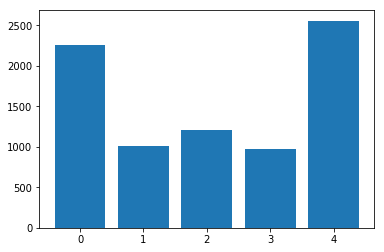

<BarContainer object of 5 artists>

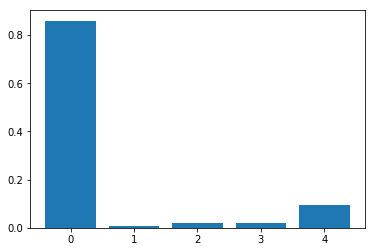

In [16]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL
                               ,cluster=True)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

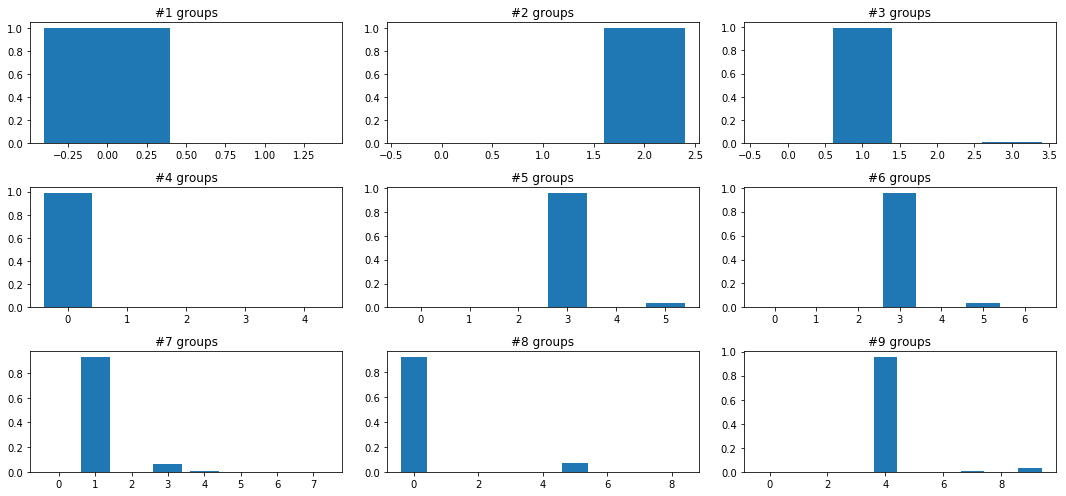

<Figure size 1080x360 with 0 Axes>

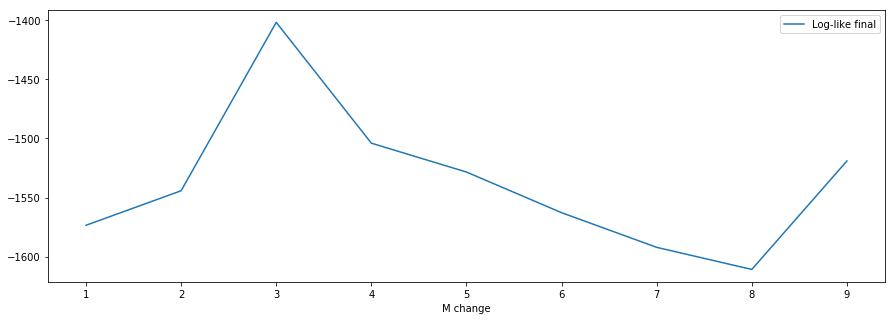

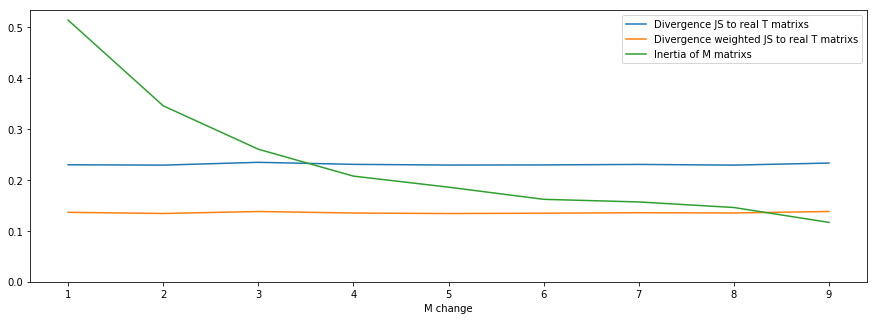

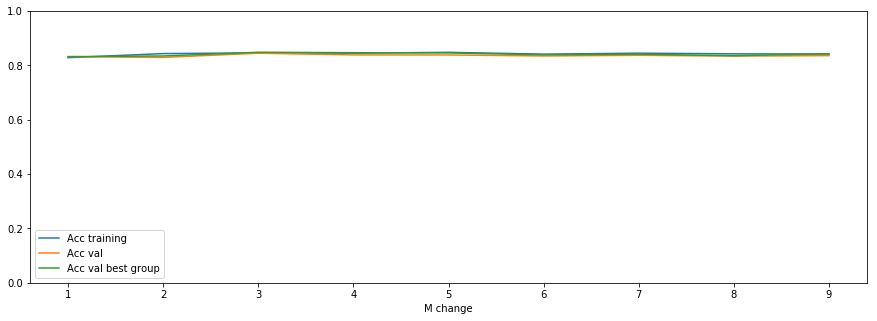

In [11]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

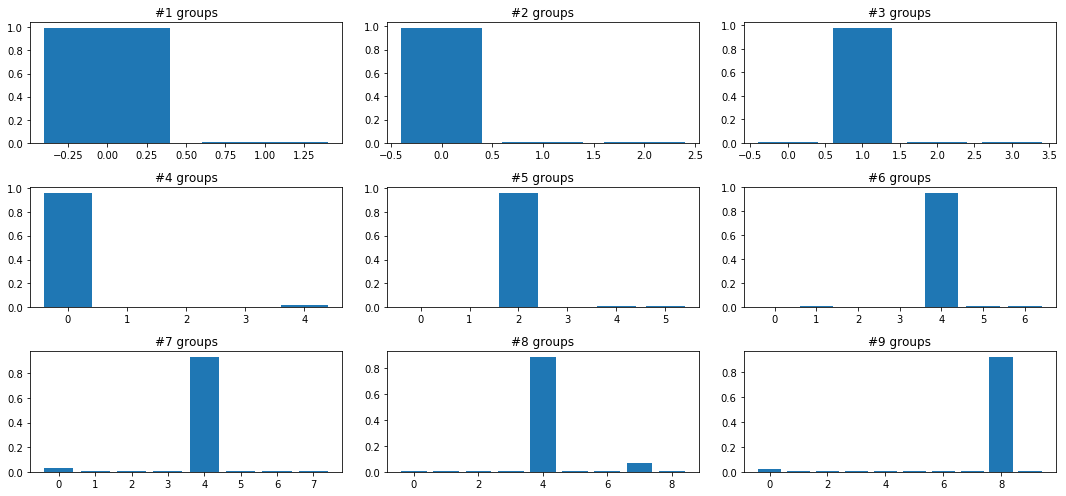

<Figure size 1080x360 with 0 Axes>

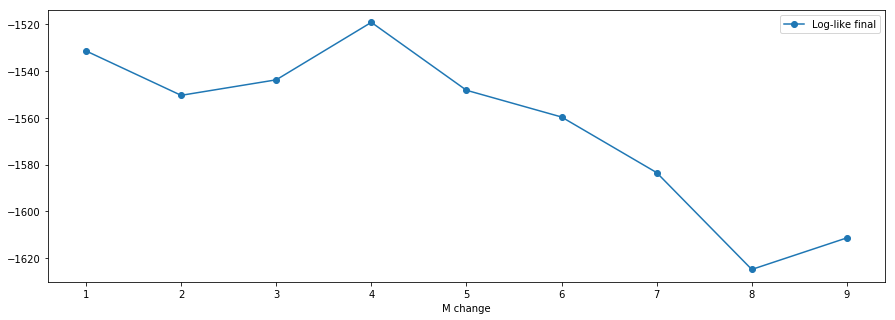

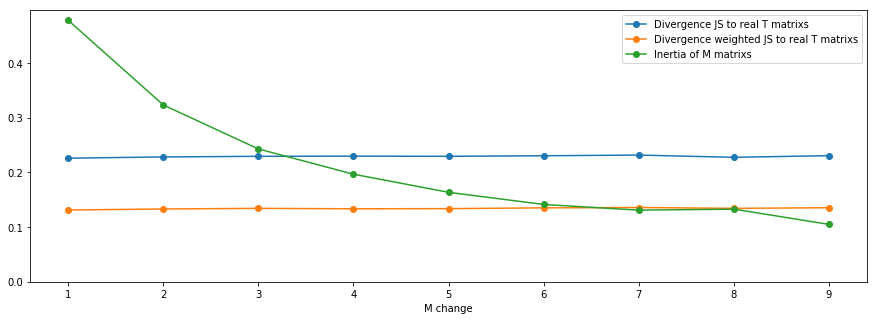

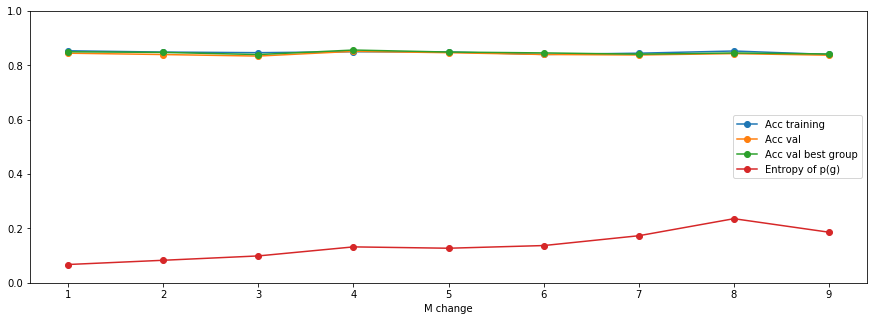

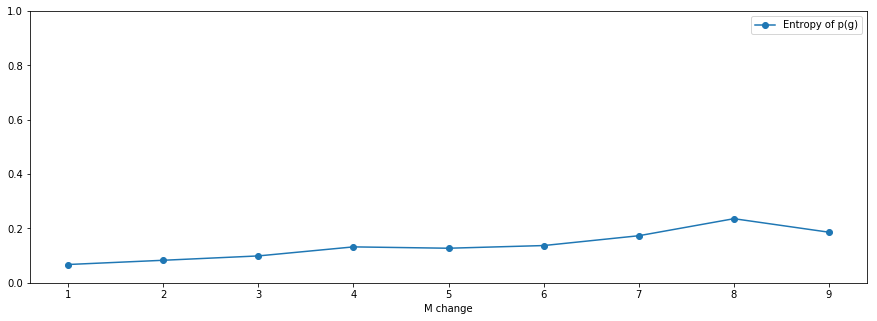

In [16]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

In [17]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

59


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0        1              1              1                   1   
1        2              1              1                   1   
2        3              1              1                   1   
3        4              2              1                   1   
4        5              1              1                   1   
5        6              1              1                   1   
6        7              2              1                   1   
7        8              2              2                   1   
8        9              2              1                   1   

   Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                1                                1  
1                                1                                1  
2                                1                                1  
3                                2                                1  
4                                1                                1  
5                                1                                1  
6                                2                                1  
7                                2                                2  
8                                2                                1

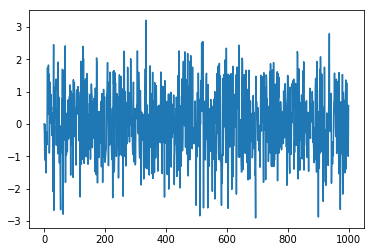

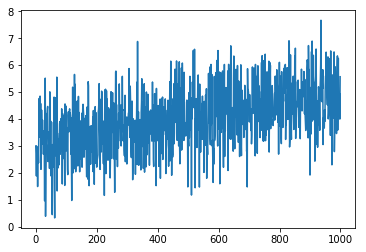

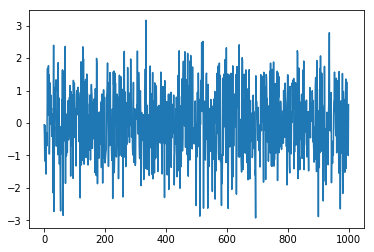

In [21]:
from scipy import signal
randgen = np.random.RandomState(9)
npoints = 1000
noise = randgen.randn(npoints)
plt.plot(noise)
plt.show()
x = 3 + 2*np.linspace(0, 1, npoints) + noise
plt.plot(x)
plt.show()
plt.plot(signal.detrend(x))
plt.show()

1, 2 o 3...

In [11]:
M_seted = 3 #??

In [12]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.005222 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -3077.704	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2134.539	Tol1: 0.30645	Tol2: 0.32157	Tol3: 0.12719	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1924.502	Tol1: 0.09840	Tol2: 0.16594	Tol3: 0.14563	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1833.496	Tol1: 0.04729	Tol2: 0.09807	Tol3: 0.10592	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1787.747	Tol1: 0.02495	Tol2: 0.05722	Tol3: 0.07924	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.928	Tol1: 0.03234	Tol2: 0.05086	Tol3: 0.06518	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1697.573	Tol1: 0.01

M step: done,  E step: done //  (in 0.05 sec)	logL: -1699.654	Tol1: 0.03705	Tol2: 0.03412	Tol3: 0.06272	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1654.043	Tol1: 0.02684	Tol2: 0.02770	Tol3: 0.04966	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -2979.166	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2261.403	Tol1: 0.24093	Tol2: 0.30804	Tol3: 0.05591	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2013.861	Tol1: 0.10946	Tol2: 0.12769	Tol3: 0.10395	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1885.591	Tol1: 0.06369	Tol2: 0.08496	Tol3: 0.11217	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1818.343	Tol1: 0.03566	Tol2: 0.05536	Tol3: 0.08924	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	

M step: done,  E step: done //  (in 0.05 sec)	logL: -1849.505	Tol1: 0.03192	Tol2: 0.04141	Tol3: 0.08171	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1796.762	Tol1: 0.02852	Tol2: 0.03277	Tol3: 0.06895	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1753.628	Tol1: 0.02401	Tol2: 0.02631	Tol3: 0.05188	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -2951.701	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2210.836	Tol1: 0.25100	Tol2: 0.28872	Tol3: 0.07554	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2013.322	Tol1: 0.08934	Tol2: 0.12388	Tol3: 0.13230	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1884.948	Tol1: 0.06376	Tol2: 0.07430	Tol3: 0.10177	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	

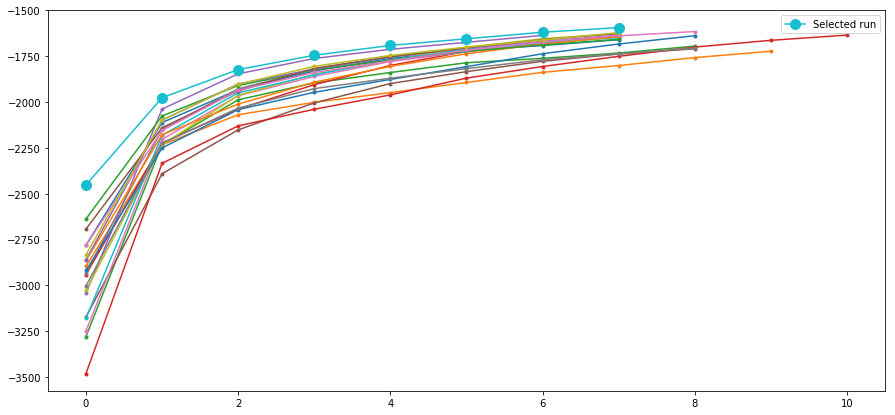

In [16]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [13]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [101]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global       0.979         0.979
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.920875      0.920875
====  ======  ==========  ============


*** Soft-Majority (Train with softMV) ***
Train


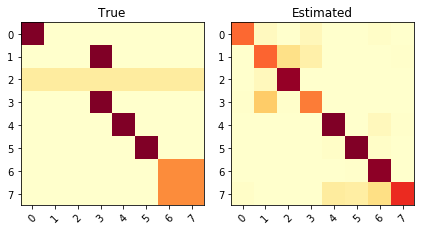

JS divergence: 0.6042	KL divergence: 3.2542


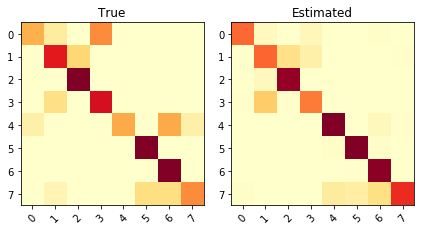

JS divergence: 0.3535	KL divergence: 0.9611


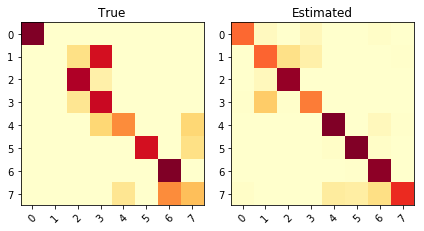

JS divergence: 0.4550	KL divergence: 1.7986


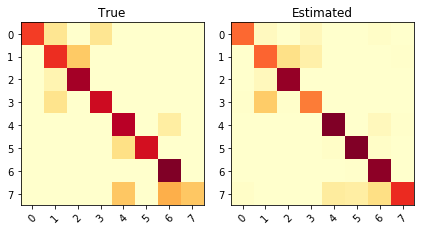

JS divergence: 0.3277	KL divergence: 0.6466


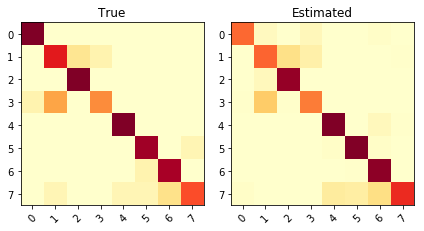

JS divergence: 0.4090	KL divergence: 1.0168


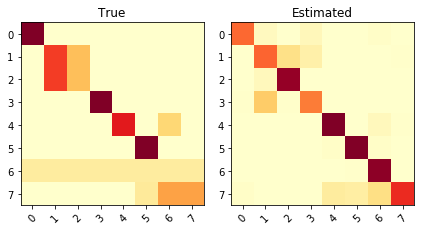

JS divergence: 0.4474	KL divergence: 2.0652


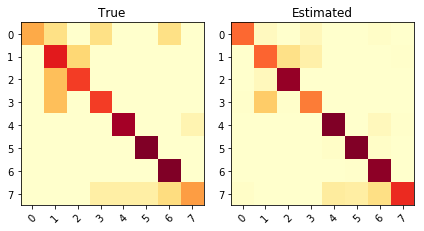

JS divergence: 0.3061	KL divergence: 0.7846


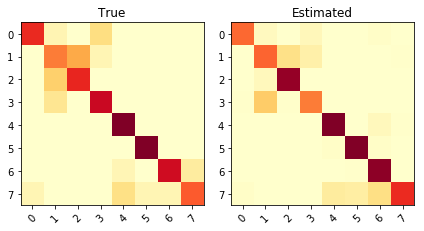

JS divergence: 0.3512	KL divergence: 0.9899


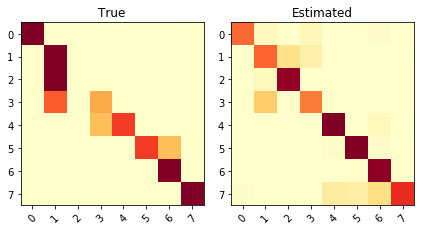

JS divergence: 0.5205	KL divergence: 1.5973


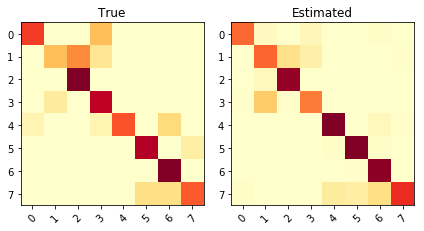

JS divergence: 0.3812	KL divergence: 1.1564


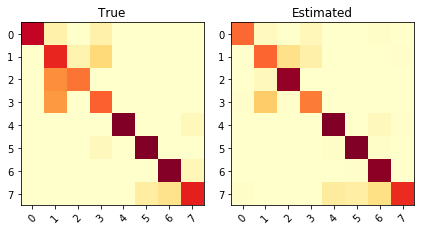

JS divergence: 0.3555	KL divergence: 0.8460


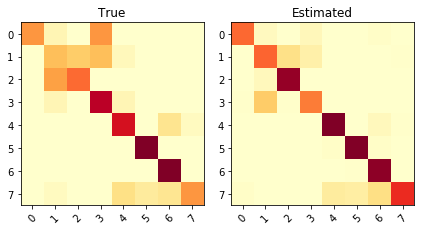

JS divergence: 0.2977	KL divergence: 0.8035


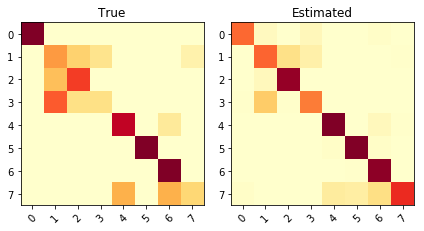

JS divergence: 0.3173	KL divergence: 0.6290


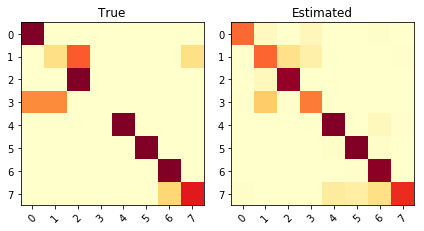

JS divergence: 0.4530	KL divergence: 0.8933


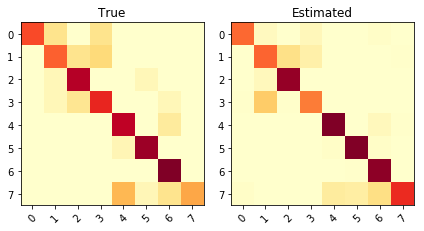

JS divergence: 0.3013	KL divergence: 0.7705
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.827         0.827    2.20961   0.445405     1.13939    0.390029
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.797138      0.797138
====  ======  ==========  ============


In [113]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


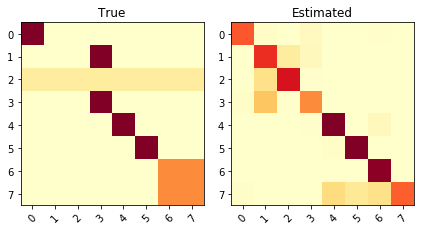

JS divergence: 0.5206	KL divergence: 2.8798


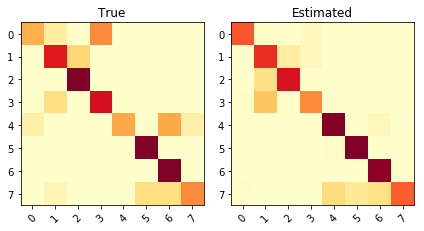

JS divergence: 0.3159	KL divergence: 1.0400


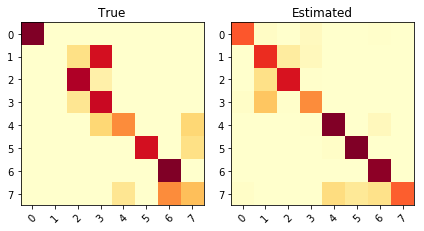

JS divergence: 0.3694	KL divergence: 1.4746


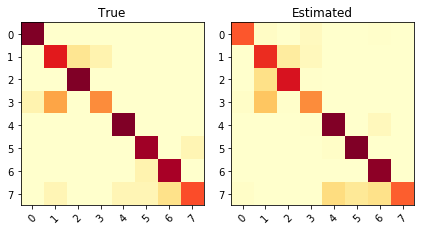

JS divergence: 0.3722	KL divergence: 1.0621


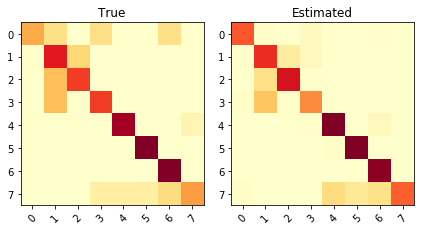

JS divergence: 0.2662	KL divergence: 0.8170


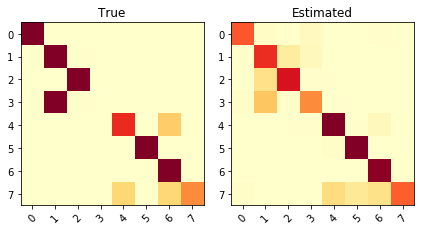

JS divergence: 0.4239	KL divergence: 0.8416


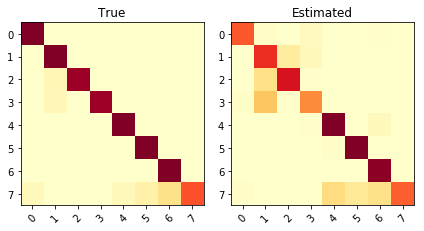

JS divergence: 0.4185	KL divergence: 0.8484


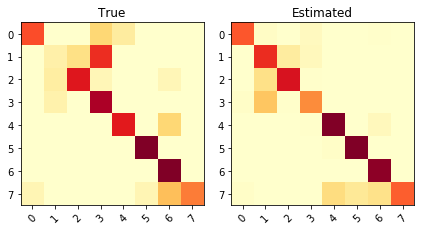

JS divergence: 0.2880	KL divergence: 0.8640


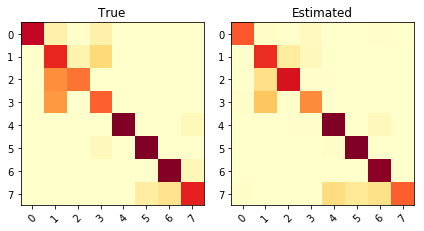

JS divergence: 0.3112	KL divergence: 0.8194


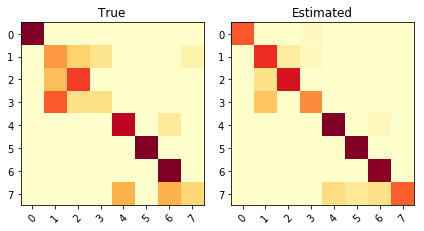

JS divergence: 0.2792	KL divergence: 0.6896


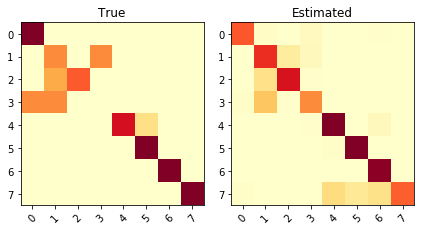

JS divergence: 0.4106	KL divergence: 1.1294


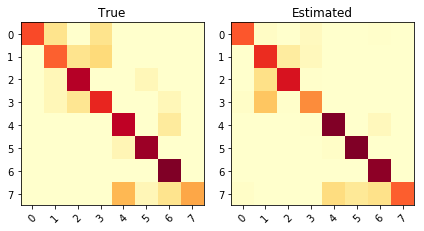

JS divergence: 0.2383	KL divergence: 0.6479


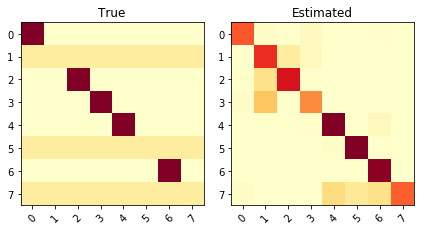

JS divergence: 0.4945	KL divergence: 3.7924


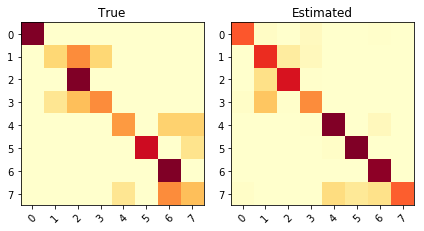

JS divergence: 0.3226	KL divergence: 1.3867


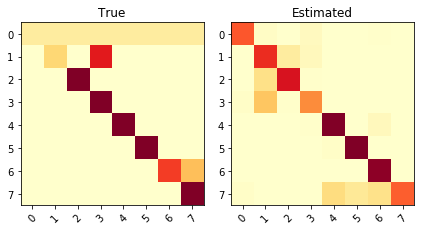

JS divergence: 0.4805	KL divergence: 2.3156
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.812         0.812    2.33873   0.415067     1.16027    0.343895
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.792088      0.792088
====  ======  ==========  ============


In [114]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=1)
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


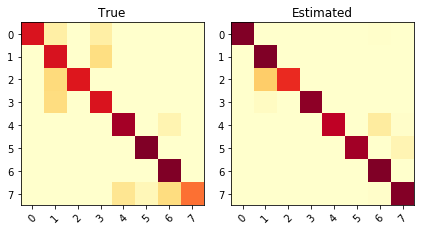

JS divergence: 0.0758	KL divergence: 1.0693


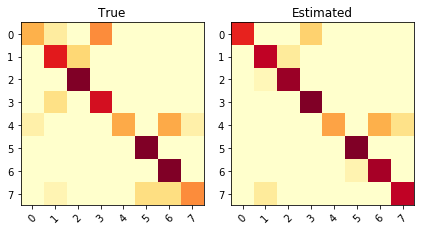

JS divergence: 0.0800	KL divergence: 1.3788


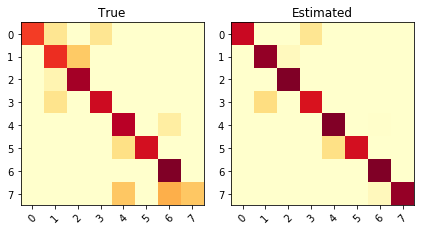

JS divergence: 0.0825	KL divergence: 1.1107


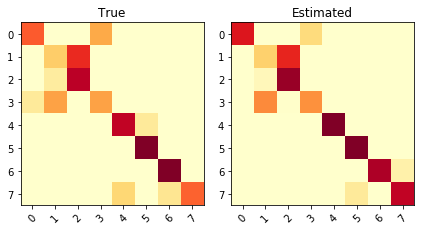

JS divergence: 0.0674	KL divergence: 1.2312


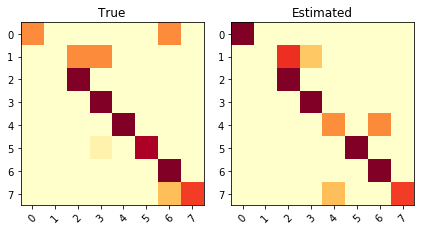

JS divergence: 0.1301	KL divergence: 1.7914


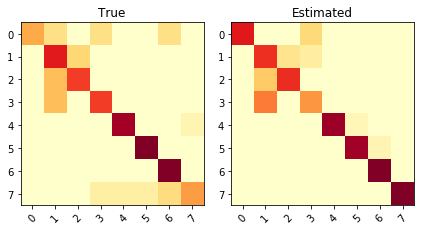

JS divergence: 0.0988	KL divergence: 1.3245


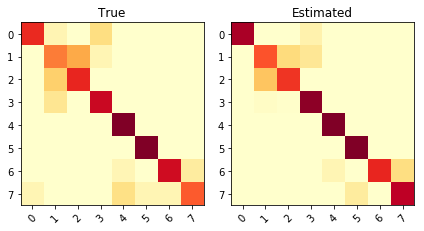

JS divergence: 0.0437	KL divergence: 0.4704


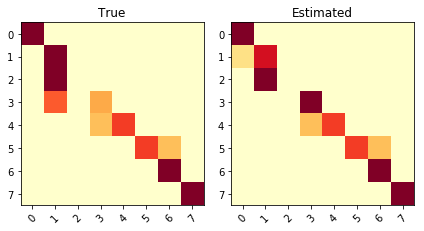

JS divergence: 0.0632	KL divergence: 0.9011


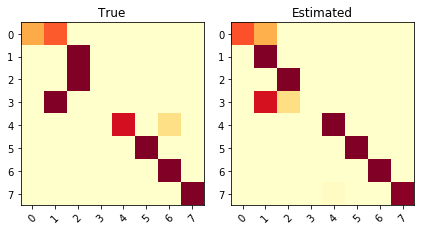

JS divergence: 0.1585	KL divergence: 2.3995


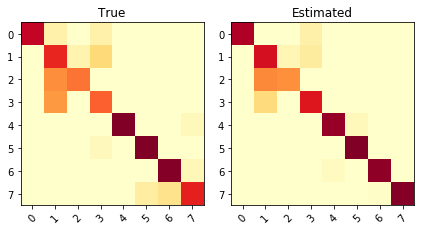

JS divergence: 0.0431	KL divergence: 0.5730


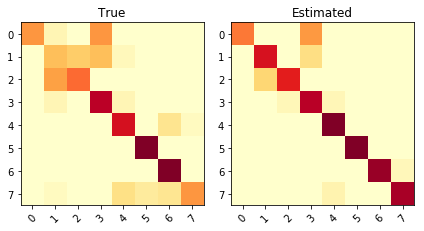

JS divergence: 0.0925	KL divergence: 1.2764


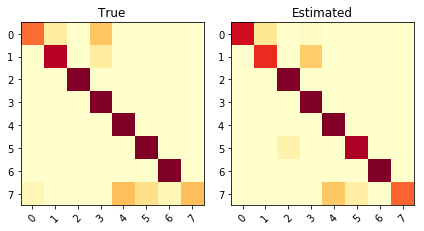

JS divergence: 0.0371	KL divergence: 0.3051


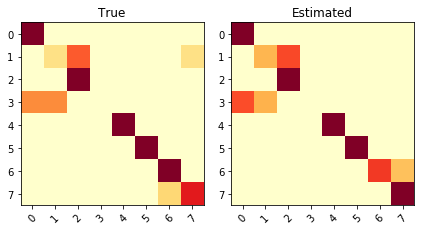

JS divergence: 0.0567	KL divergence: 0.8301


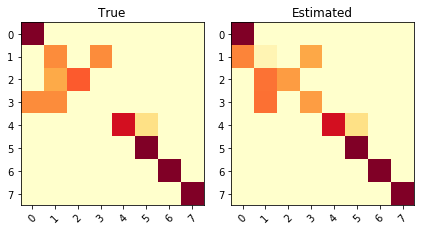

JS divergence: 0.1099	KL divergence: 1.0951


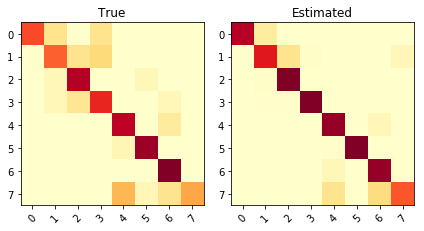

JS divergence: 0.0650	KL divergence: 0.7362
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global       0.851         0.851    1.67215    0.16081     1.08425   0.0850474
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.819865      0.819865
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


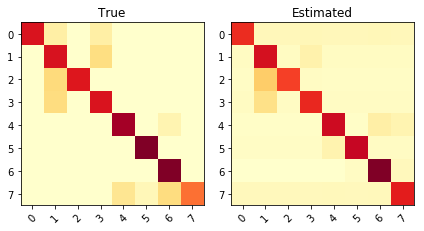

JS divergence: 0.1763	KL divergence: 0.3824


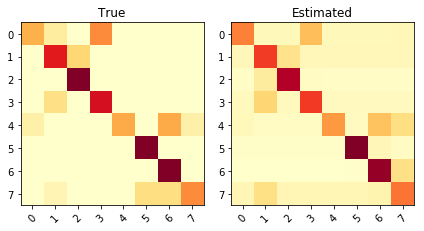

JS divergence: 0.2303	KL divergence: 0.5073


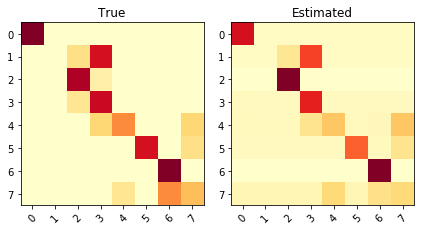

JS divergence: 0.2640	KL divergence: 0.5862


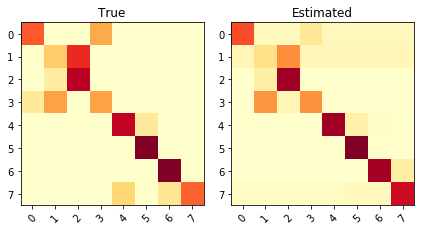

JS divergence: 0.2461	KL divergence: 0.5448


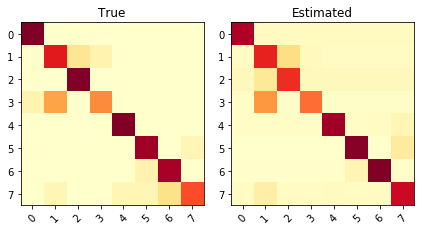

JS divergence: 0.1913	KL divergence: 0.4172


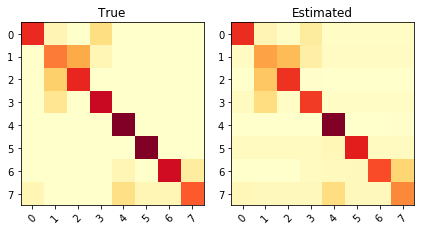

JS divergence: 0.1530	KL divergence: 0.3284


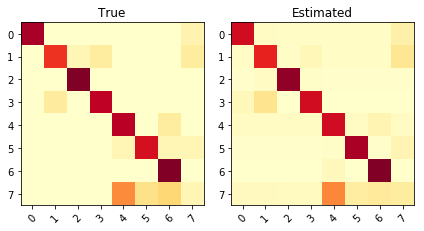

JS divergence: 0.1536	KL divergence: 0.3270


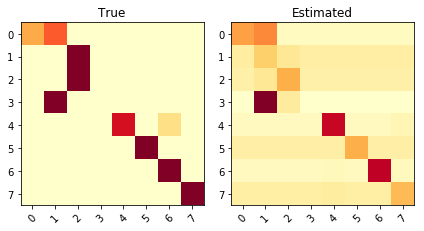

JS divergence: 0.4771	KL divergence: 1.2062


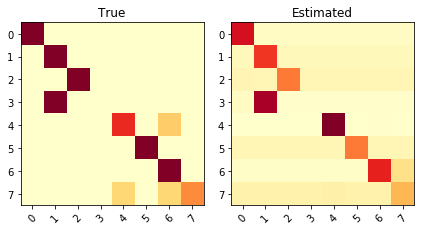

JS divergence: 0.3994	KL divergence: 0.9392


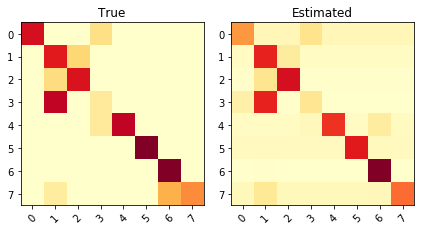

JS divergence: 0.2543	KL divergence: 0.5691


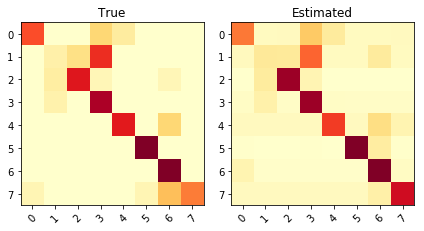

JS divergence: 0.1883	KL divergence: 0.4109


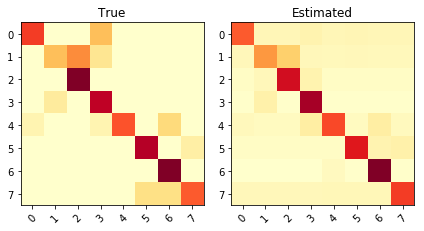

JS divergence: 0.2042	KL divergence: 0.4517


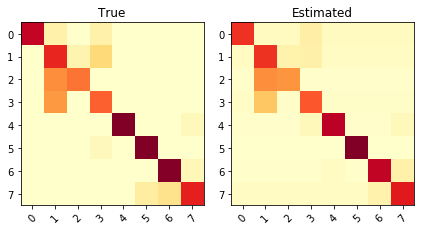

JS divergence: 0.1352	KL divergence: 0.2877


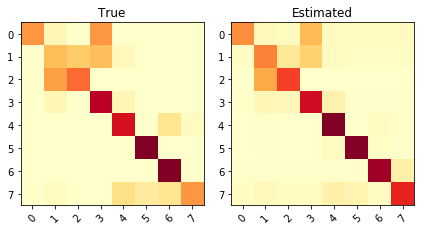

JS divergence: 0.1176	KL divergence: 0.2601


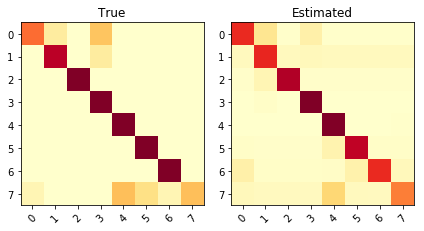

JS divergence: 0.2167	KL divergence: 0.4764
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global       0.854         0.854   0.707193     0.2941    0.541393    0.237015    0.0649323     0.0557519
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                   0.83947                1.1736               

In [13]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


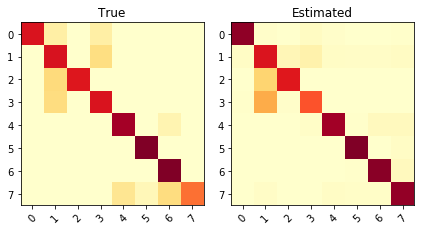

JS divergence: 0.0635	KL divergence: 0.1931


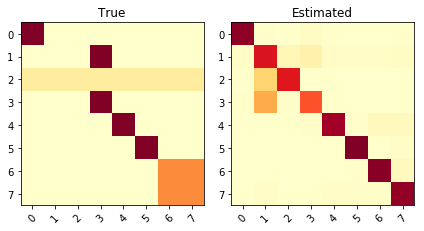

JS divergence: 0.2698	KL divergence: 0.9979


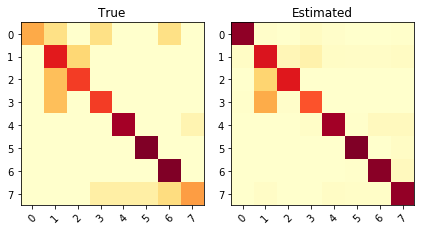

JS divergence: 0.1029	KL divergence: 0.3715


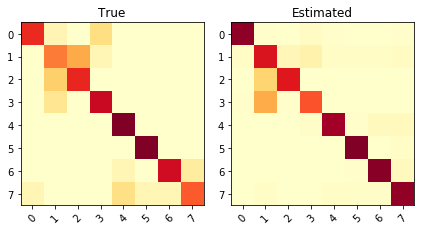

JS divergence: 0.0778	KL divergence: 0.2535


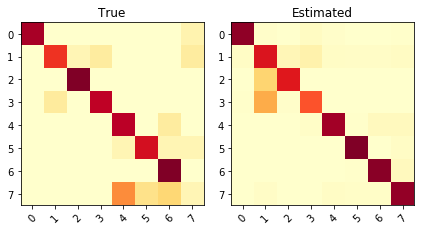

JS divergence: 0.1497	KL divergence: 0.4904


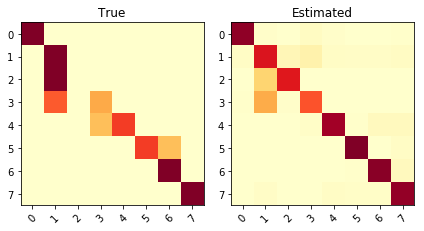

JS divergence: 0.1544	KL divergence: 0.5063


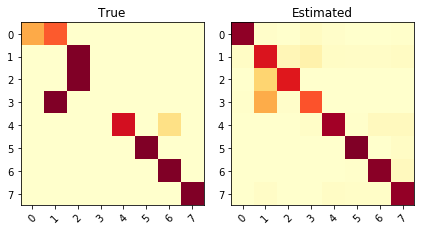

JS divergence: 0.2449	KL divergence: 0.8209


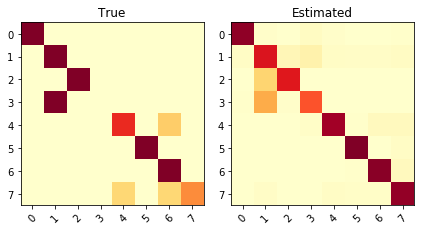

JS divergence: 0.1465	KL divergence: 0.4024


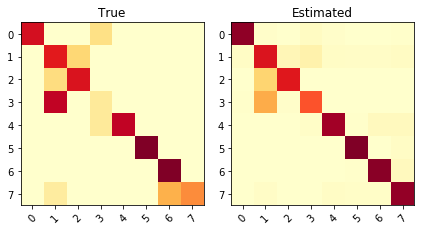

JS divergence: 0.1039	KL divergence: 0.3407


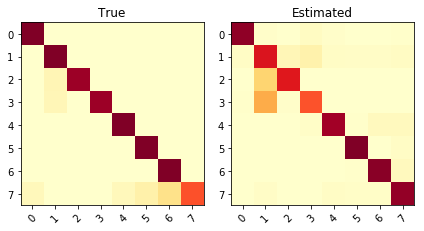

JS divergence: 0.0802	KL divergence: 0.2062


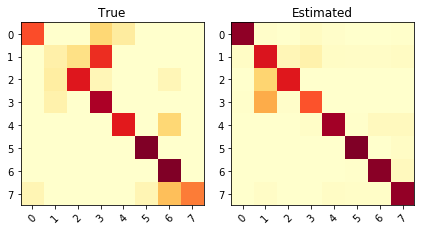

JS divergence: 0.1484	KL divergence: 0.5077


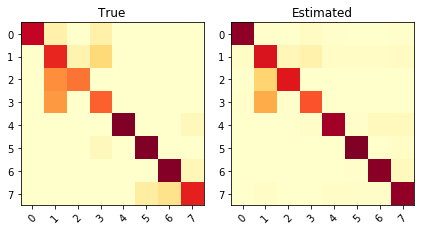

JS divergence: 0.0516	KL divergence: 0.1552


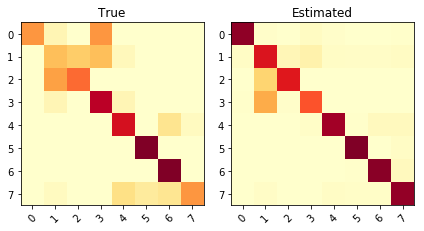

JS divergence: 0.1216	KL divergence: 0.4160


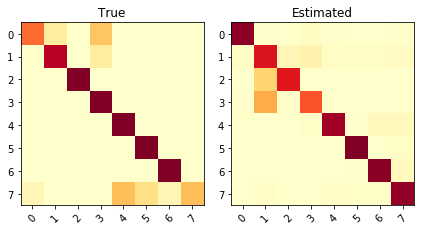

JS divergence: 0.1407	KL divergence: 0.4206


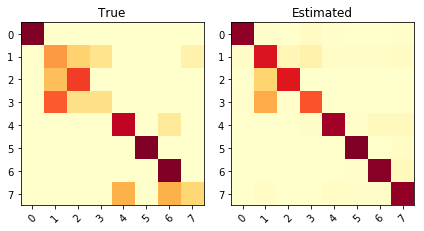

JS divergence: 0.1187	KL divergence: 0.4257
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global       0.785         0.785   0.833293   0.229326    0.478406    0.140692     0.120742     0.0777385
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                   0.75145              0.655563               

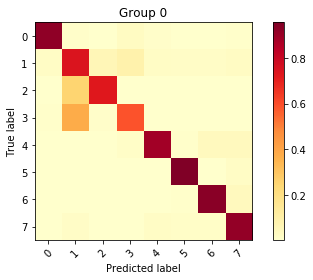

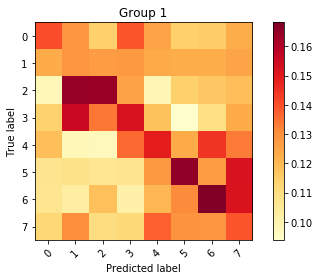

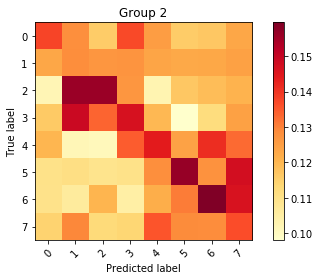

Inertia: 0.31022419822626685
A result
 ====  ========  ==========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups        Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ==========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.984691        58    0.56594     0.83366    0.194147      0.866564   0.809897     0.772727      0.772727
   1         1  0.00809526       0    2.0695      0.150981   1.89454       0.0222689  0.0296929    0.538721      0.538721
   2         2  0.00721397       0    2.07276     0.145711   1.92869       0.0112405  0.0236697    0.580808      0.580808
====  ========  ==========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  =====

In [14]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
project confusion matrices